# DiffuPath evaluation by Method

In [3]:
import os 

import matplotlib.pyplot as plt

import networkx as nx

import pybel
from pybel_tools.summary import plot_summary, count_top_centrality

from diffupy.process_network import process_kernel_from_file
from diffupy.utils import from_json, to_json

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.utils import reduce_dict_dimension

## 1. PathMeUniverse graph and kernel import

##### Import graph

PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


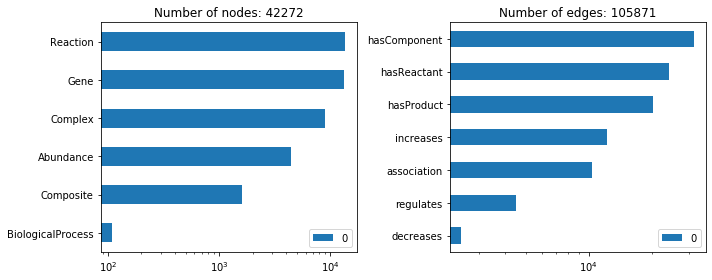

In [3]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')

pathme_universe_graph_no_flatten = pybel.from_pickle(GRAPH_PATH)
pathme_universe_graph_no_flatten.summarize()

nx.number_of_isolates(pathme_universe_graph_no_flatten)
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Import kernel

In [ ]:
KERNEL_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'kernels', 'kernel_regularized_pathme_universe.pickle')

kernel = process_kernel_from_file(KERNEL_PATH)

## 2. Load/import preprocessed datasets mapping 

##### Dataset 1

In [6]:
MAPPING_PATH_DATASET_1 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_1_mapping.json')

dataset1_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET_1)

In [7]:
dataset1_mapping_by_database = reduce_dict_dimension(dataset1_mapping_by_database_and_entity)

dataset1_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset1_mapping_by_database.items() for entity, entity_value in entity_set.items()}


In [8]:
dataset1_mapping_kegg = dataset1_mapping_by_database['kegg']

##### Dataset 2

In [9]:
MAPPING_PATH_DATASET2 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_2_mapping.json')

dataset2_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET2)

In [10]:
dataset2_mapping_by_database = reduce_dict_dimension(dataset2_mapping_by_database_and_entity)

dataset2_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset2_mapping_by_database.items() for entity, entity_value in entity_set.items()}

In [11]:
dataset2_mapping_kegg = dataset2_mapping_by_database['kegg']

##### Dataset 3

In [12]:
MAPPING_PATH_DATASET3 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_3_mapping.json')

dataset3_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET3)

In [13]:
dataset3_mapping_by_database = reduce_dict_dimension(dataset3_mapping_by_database_and_entity)

dataset3_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset3_mapping_by_database.items() for entity, entity_value in entity_set.items()}

## 3. Evaluation: random cross-validation by method

In [1]:
from diffupath.views import show_box_plot, fdr_barchart_three_plot

from diffupath.cross_validation import cross_validation_by_method, get_p_values, get_wilcoxon_test

from collections import defaultdict

In [16]:
metrics_by_method = defaultdict(lambda: defaultdict(lambda: list))

In [17]:
metrics_by_method['auroc']['Dataset 1'], metrics_by_method['auprc']['Dataset 1'] = cross_validation_by_method(dataset1_mapping_all_labels, 
                                                                                                              kernel, 
                                                                                                              kernel_kegg, 
                                                                                                              k = 3)

100%|██████████| 3/3 [00:36<00:00, 12.21s/it]


In [18]:
metrics_by_method['auroc']['Dataset 2'], metrics_by_method['auprc']['Dataset 2'] = cross_validation_by_method(dataset2_mapping_all_labels, 
                                                                                                               kernel, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:34<00:00, 11.64s/it]


In [19]:
metrics_by_method['auroc']['Dataset 3'], metrics_by_method['auprc']['Dataset 3'] =  cross_validation_by_method(dataset3_mapping_all_labels, 
                                                                                                               kernel, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:35<00:00, 11.81s/it]


In [2]:
metrics_by_method =  {"auroc": {"Dataset 1": {"raw": [0.6710334972179892, 0.6766945415635841, 0.6905141978906415, 0.6587696749842726, 0.65582137912235, 0.6698090311156482, 0.6658606094662659, 0.6742340081076945, 0.6670118305232633, 0.6815105264032613, 0.628044623395597, 0.6583449389621365, 0.6633833445104154, 0.64092336226563, 0.6481548550566201, 0.6480295868395719, 0.6433615830760528, 0.6606003522105459, 0.6655016438163002, 0.6635407065948126, 0.6445235299313687, 0.6527566096614893, 0.6600120414938032, 0.6484632806254254, 0.655773140692714, 0.6519938494263205, 0.6408848604876403, 0.692011536075587, 0.6730140954100032, 0.6590061620463578, 0.6386719409121514, 0.6740677468832809, 0.6687538452078504, 0.6512958317629568, 0.657120436150125, 0.6890088344479222, 0.6546095109705904, 0.6633078866088575, 0.6494695185084249, 0.6486360581873933, 0.6508491182930305, 0.6521338868907465, 0.6257951763867083, 0.6760607943407171, 0.6805802953784921, 0.6639936527402458, 0.6554314822797012, 0.6561536998555699, 0.675722003980415, 0.666139344086341, 0.6439736029427319, 0.6797038444654488, 0.6823912917724855, 0.6689111771301366, 0.6459026294981505, 0.6332624987326414, 0.6652667916540329, 0.6482121774494516, 0.6695407695655442, 0.6483027600156943, 0.6676832020406835, 0.6793423767838991, 0.6705080788034917, 0.6483992977440839, 0.6434444205075679, 0.6693498898915923, 0.671096830481413, 0.6623059364387287, 0.6675890683850385, 0.6363505230734111, 0.6578635833895602, 0.6610876944921726, 0.6504420673162534, 0.6492114964120117, 0.6565006903313624, 0.658411501221249, 0.6553975309075768, 0.6657878357035099, 0.6355081696283428, 0.6828857624514753, 0.6525107548710303, 0.6651531393444996, 0.6644195776685737, 0.6575674496379327, 0.674285643142118, 0.6799358030570912, 0.6805568479459608, 0.6718693073386537, 0.6777588825535767, 0.651874926279709, 0.6695707480531206, 0.6431825871852054, 0.6703944992049068, 0.6732870669756265, 0.6782188242110634, 0.6590382837721884, 0.6771380974836895, 0.6724626966983378, 0.6757899776571976, 0.6377658487760406], "z": [0.6885463837357155, 0.679332297395844, 0.6989862851434809, 0.6693087511886373, 0.6637473919027317, 0.6837868333724394, 0.6786653125263138, 0.680907652649241, 0.6715431326507044, 0.6884689992612298, 0.6385039919599664, 0.6646068561985756, 0.6787885379608124, 0.6545201687624685, 0.6592792886016231, 0.6520141087258808, 0.6583976705037246, 0.6650428410951462, 0.6735802182020368, 0.6693003922514746, 0.6617133700943975, 0.663591349480779, 0.6668663986392454, 0.6544928188951945, 0.6632953603054725, 0.6543171948076739, 0.6484626091349184, 0.6979170311870374, 0.6934395427810904, 0.6612825986831244, 0.6547629304248905, 0.6904585011381128, 0.6778095344018209, 0.6585426081745267, 0.6615543127664998, 0.7066790055917402, 0.6704317925594974, 0.6715101957820405, 0.6601468754034983, 0.6583673371190562, 0.6714585238782365, 0.6650382614751458, 0.6385408867273744, 0.6836322918753481, 0.6956374423248618, 0.6780958664465774, 0.6659171070873688, 0.6685028363307675, 0.683692567302973, 0.674279265439546, 0.6555611736569792, 0.6866133163540393, 0.6924837849675166, 0.6745906782791667, 0.6531038444497815, 0.6500035571961046, 0.6774695825353566, 0.659507526472858, 0.6841689967776291, 0.6550756810566054, 0.6819650728118494, 0.6931269832984228, 0.6877648644831846, 0.6560719885806454, 0.6462894759587041, 0.6856906453570932, 0.6794062696273682, 0.6774969087489451, 0.6733994827930455, 0.6485202508715793, 0.6655672098523107, 0.6610682400870727, 0.6659122777389308, 0.6633007650586566, 0.6690228207520764, 0.6631467965088989, 0.6601269840687136, 0.6728685434003374, 0.6474126475115873, 0.7057292509782289, 0.6710166278958836, 0.6738446127139244, 0.6717691776750774, 0.6629532215930962, 0.6873422516006307, 0.6969479994127363, 0.6864608518377129, 0.6752208955911694, 0.6759654162002446, 0.6522487654252922, 0.6779236720276063, 0.6621246816730716, 0.676238158391115, 0.6770883031122272, 0.6898585272114333, 0.6691176915280206, 0.6889539898131547, 0.6856024635731091, 0.6827950332207022, 0.6500138761268838], "random": [0.5017993182627709, 0.5014130323662311, 0.5020936951981867, 0.5160260172609972, 0.5190220432938879, 0.49638541173212425, 0.49406188833841136, 0.5063904711331046, 0.5320346062052506, 0.48963925711240563, 0.5062787729070225, 0.5288014022062713, 0.5092907448080031, 0.49784653624741804, 0.4928913541656771, 0.5072718979318407, 0.4830676698903406, 0.5060527665519552, 0.49927166858631794, 0.5324413926960444, 0.4854644082854347, 0.5188218253720197, 0.48524697674061545, 0.5005895284918334, 0.4819689318618091, 0.48376382017333625, 0.5022150456244543, 0.4945508843926958, 0.49052385221860334, 0.5024561561788317, 0.5193176339241447, 0.4903596651169467, 0.46546841225802693, 0.5054072649349983, 0.49181573619546826, 0.5014030362882689, 0.49848693092152524, 0.49056232551378187, 0.5070370777706164, 0.509346825728439, 0.4821186131858717, 0.5083683005590575, 0.49653013644785615, 0.5067732091331404, 0.49143933972615805, 0.4869396817578751, 0.4915187517892929, 0.48737469588722654, 0.49221550325901087, 0.514261302776869, 0.5216586933102536, 0.47414137898759645, 0.5098448459108742, 0.47436934568636036, 0.509403852839347, 0.47769150001976224, 0.4964285903823884, 0.504748918930972, 0.49177809745990847, 0.5055681480774532, 0.5057832695393825, 0.50252300513394, 0.5337989452807457, 0.49506837302485324, 0.5143087409876584, 0.5009302767598351, 0.49861052491856966, 0.5141861003079796, 0.47993897053903667, 0.48722251491086005, 0.5092680283792349, 0.48911590882680084, 0.5043842478618045, 0.5021841480851545, 0.5032929931618721, 0.5102431200324605, 0.48145702727166884, 0.4965449893902304, 0.5070692955698324, 0.4982133939603278, 0.5073994511077683, 0.48730975862908266, 0.5070180704118363, 0.489265743046805, 0.4719977302186733, 0.492324394163886, 0.5076406783525269, 0.49868689278278977, 0.512810528585495, 0.4890958124869893, 0.4883568853110116, 0.5043854270024566, 0.48826854134233916, 0.5213150360747337, 0.4698932847623124, 0.5040712732509249, 0.50040523525823, 0.5302806060637305, 0.5030701245659916, 0.4754553379940122], "page_rank": [0.4256893971390368, 0.4426777280255168, 0.4669406834668685, 0.44267968705598215, 0.43940056561415786, 0.4401173265736809, 0.42149780295883105, 0.4487387292985289, 0.4368542612980214, 0.41827863860412107, 0.4288979529297837, 0.441597221813722, 0.4318451942389744, 0.43111426442961925, 0.44207558310443207, 0.42612991562919506, 0.4424044654358093, 0.43677624692287764, 0.42699200161992507, 0.44166499501214435, 0.4413757544611524, 0.41497429119139506, 0.4416867289687853, 0.4255610317268427, 0.43710362106180173, 0.4341230647037414, 0.44931468298477817, 0.43645982455303173, 0.4349033759164514, 0.4329562426390334, 0.41045036017955494, 0.4329503989698165, 0.44118786723730025, 0.4365924043313805, 0.44079501298312473, 0.4442588634696033, 0.4363462976793256, 0.4285448460205742, 0.43078155953121283, 0.44375156276217387, 0.4572074023346021, 0.42423190949839346, 0.42958088995252336, 0.45129034609563384, 0.4324546266195043, 0.4253890528835701, 0.4380797107859378, 0.4175813169946099, 0.43934840608459064, 0.44995313611222926, 0.45614593151354155, 0.42705854165266005, 0.45834933888304946, 0.43091274313001865, 0.45792365660028495, 0.4402489693582784, 0.4450832307594875, 0.4208417342587456, 0.4299730761017844, 0.42971318211702825, 0.44290206453851494, 0.4373277519394499, 0.4399581981118018, 0.45344188459285684, 0.4357301528534405, 0.4094161082162651, 0.44167975878018484, 0.45729079425875085, 0.43911009054720457, 0.42385420091420967, 0.4333789963674034, 0.44213005114174014, 0.4284973374051278, 0.43041663584938467, 0.45523413640705795, 0.43839991725740113, 0.4038379267720921, 0.43762334058164487, 0.4389364095870962, 0.4509055727687187, 0.42000600142880595, 0.434208002682733, 0.4368732555617956, 0.43507453141809976, 0.4335514853179658, 0.4278484750859107, 0.43488791329982396, 0.4436251680690493, 0.44786845345321014, 0.4387501248859319, 0.4217536484220503, 0.45199944088031785, 0.44223409989070184, 0.4499017184286823, 0.44408441654127945, 0.4254611970797447, 0.4334125646405033, 0.41780326815244045, 0.4511614898926829, 0.4327206590195969]}, "Dataset 2": {"raw": [0.8879384088964926, 0.8557492581184327, 0.8891336468790257, 0.899548728629697, 0.924439658232941, 0.9164871837352963, 0.8823944431859037, 0.8247204067303, 0.8373518350086953, 0.9438412841172539, 0.9187328335987539, 0.8965017452390531, 0.8424280743989152, 0.9029056511482964, 0.8945412393733143, 0.9170045003161379, 0.8757454036027325, 0.9421974796877166, 0.8729644043364427, 0.8527924388377395, 0.8806182102198764, 0.9133691961080662, 0.8945282782825089, 0.9215273574815361, 0.8787512496182113, 0.8949774082552006, 0.8730461155610856, 0.8902911286405167, 0.8219777272107394, 0.8867471155937701, 0.8973740830028254, 0.8368187397086122, 0.8801375228087022, 0.8361611052316598, 0.8905114671842087, 0.9023567771289718, 0.8910000439550037, 0.8696627073351884, 0.9315868545235897, 0.882141983678042, 0.9162640275631684, 0.9274381784144866, 0.8998462701925343, 0.8113259646714476, 0.8946263317520803, 0.8626856958020717, 0.9399090018720323, 0.9094464937995268, 0.9006921222490085, 0.9314921822081416, 0.904144280608743, 0.9138870762145951, 0.890106292215118, 0.8895207890261262, 0.9508571789227869, 0.9187587557803647, 0.9367391698815808, 0.9069421856456482, 0.9022187133356101, 0.850759238158353, 0.8872103337086416, 0.9347978238892063, 0.8880725280100444, 0.8575204193532754, 0.9303803460273129, 0.8474828998130222, 0.9274573382878512, 0.8416661876698326, 0.8534055547854038, 0.8765101079602511, 0.957132037449663, 0.8577480837309007, 0.8543291733867104, 0.8923389809877704, 0.9033395659274337, 0.8699732099888309, 0.8366147434098489, 0.9120043368936886, 0.8219856165703602, 0.930245099862387, 0.8939467197733274, 0.862807417350505, 0.8798388541944907, 0.876309492815611, 0.897737557071064, 0.9106051026123924, 0.8774624663716046, 0.8533514563194334, 0.8616510626403884, 0.86007769892175, 0.8359587995099581, 0.8645464576211777, 0.8617000893751741, 0.8475110760973817, 0.8268432079939501, 0.8664686437401875, 0.9119012116929326, 0.8948449797187106, 0.8756822887257669, 0.9115354835219454], "z": [0.8372036277529638, 0.858688044577136, 0.8831687274801047, 0.8965648601160187, 0.912558846169885, 0.8473014445417464, 0.8736812090105504, 0.8940887282464997, 0.8443429346839917, 0.9244898120191012, 0.9067703103110549, 0.9057007385567656, 0.8831676004287303, 0.8956823788898769, 0.8639930753963557, 0.8656239187350876, 0.8410739221725945, 0.9593675438507513, 0.8668478965276674, 0.9032415124578623, 0.901394275255249, 0.8606705279446752, 0.8950382690294172, 0.899725112169788, 0.8766532434847977, 0.8687548674531231, 0.8218695302787986, 0.9379907604328328, 0.8013132402614308, 0.9239319215887818, 0.9359564327020718, 0.7065293467272119, 0.8267034536235265, 0.816406148741478, 0.8839013108734536, 0.9275351048326835, 0.920499486628099, 0.8737725001718752, 0.8997476531972756, 0.8680053782891586, 0.874324755345323, 0.8991886357155817, 0.8998445796154726, 0.8676086562053758, 0.8878054168343155, 0.8482605652613464, 0.9084259487800233, 0.8533525833708077, 0.886319963122879, 0.8659710505583975, 0.9232748506375166, 0.926044015864375, 0.8842642214160048, 0.8649792453489408, 0.8839509011339264, 0.8934620876823428, 0.9520924272291104, 0.8439969299120562, 0.856568624467609, 0.8286679041690757, 0.9151916381804431, 0.9405525482068049, 0.8687176747577685, 0.851989978259179, 0.9124247270563334, 0.8174853004324496, 0.9065989985021488, 0.8947953894582377, 0.8421384221956989, 0.8875856418163109, 0.9236591751561812, 0.8646298594228821, 0.8941676218427064, 0.9377332291937863, 0.8622788302559194, 0.8622788302559197, 0.8070397882946698, 0.9048813722075892, 0.8229514995982061, 0.9517312072636207, 0.8755949422442523, 0.8571304595777389, 0.837195174867656, 0.8675725905613956, 0.8681141387467866, 0.8832386046653165, 0.8251841883708586, 0.8750776256634106, 0.8529907998796309, 0.8772133880178661, 0.8468280829645058, 0.8920093184607634, 0.9064152891281243, 0.8921152612899553, 0.840018438560485, 0.9058410564528763, 0.9088429577885448, 0.9253610227314991, 0.8564880402943408, 0.8604687857486607], "random": [0.47706619510837167, 0.5298956012311908, 0.44121807204337793, 0.5035090744541408, 0.6384802388447273, 0.5705945534115281, 0.5259700812942156, 0.49835844967321147, 0.6705448504459179, 0.54059808108233, 0.5315084117479327, 0.4454749450844218, 0.45641861392967875, 0.5642526353278762, 0.5521334518991379, 0.5043678876014206, 0.4336116023176685, 0.5403771790129509, 0.5214010150224677, 0.4299430500940524, 0.5514921596671141, 0.3682989751721853, 0.4191819635714455, 0.5149835844967321, 0.5034020045735744, 0.4301335217763231, 0.4995824274657912, 0.53419755632721, 0.5550480067532918, 0.4714016349007236, 0.505440840509833, 0.4511530299085623, 0.5329724514832559, 0.4606518188918606, 0.6007702269092532, 0.509595151875808, 0.5275738753999624, 0.46040612169224504, 0.5192370763836527, 0.429835980213486, 0.6342109682385653, 0.556473726741886, 0.5498646974825053, 0.48444612750783017, 0.4225507201294756, 0.5302168108728901, 0.472624485641929, 0.4886984923433764, 0.46540684864038157, 0.4366219565386449, 0.4164578803995622, 0.32322030135099644, 0.5944057677981135, 0.543463045676011, 0.4546547785287697, 0.6149733283292252, 0.5173019291738377, 0.4873088379987625, 0.5498827303044955, 0.4247022612031724, 0.5390472583911793, 0.4191458979274652, 0.47068144907249304, 0.6280854440187947, 0.38717821274447156, 0.5295563587675017, 0.625057056975828, 0.4444684882070979, 0.5167169895105328, 0.5949692934853048, 0.5255835026728023, 0.412762278942961, 0.45530621422316286, 0.5476162299906117, 0.4494252601516334, 0.5218597249318415, 0.5718782649269502, 0.4448302716982748, 0.4265179409673031, 0.4909063859857924, 0.4060811183956198, 0.5507719738388834, 0.4061802989165655, 0.5480039356633994, 0.5312165054419675, 0.5260050198868215, 0.39188703338664277, 0.5823992895068135, 0.42058176137842895, 0.5130146257456853, 0.573606034683879, 0.4660222186907946, 0.6033387769914716, 0.5372394679866692, 0.5268536895717317, 0.48993035949557684, 0.5075630782477958, 0.5398542271752373, 0.47688361278572167, 0.5488063962419599], "page_rank": [0.6273517335740715, 0.5818470343333659, 0.5710465010126556, 0.5888950501030688, 0.5991292401081518, 0.5606083147088093, 0.7025378942848353, 0.5247308883080817, 0.5681167309649475, 0.6788128993283901, 0.5690285155268232, 0.5477469679500401, 0.6081693191820763, 0.6843337604858042, 0.6194522304910225, 0.6551775049562084, 0.5839264441191023, 0.5568924263274693, 0.5621129282936104, 0.6071504647396342, 0.5621540656687753, 0.6307283794917224, 0.6709207220792746, 0.626855830969343, 0.6073871455282546, 0.6157047846711997, 0.6031206925505286, 0.6294294527827462, 0.5932849152062898, 0.6269059847555031, 0.6492864074223095, 0.74957763749745, 0.6189777418624074, 0.6249133579255943, 0.5723443006702574, 0.48912620833995474, 0.627517973651793, 0.5750819084586333, 0.6166385467348758, 0.6333797678499579, 0.6344442678730624, 0.694473278175439, 0.6980539203918532, 0.5970966029544524, 0.6725380408015138, 0.5957469589336291, 0.6312879604991034, 0.7540204740152671, 0.626355420159117, 0.6333369398977313, 0.6703143684398566, 0.6423347545451165, 0.6093121492757004, 0.5883585736488626, 0.7164812103630119, 0.6248429172146953, 0.5940766687967938, 0.6715958258525299, 0.6329745928808672, 0.6218646839578887, 0.636851649608744, 0.6177819403541872, 0.7383972878635727, 0.6182197998131349, 0.6998887600293484, 0.5953812307626418, 0.5576526224794904, 0.5235779147520881, 0.5182571052136269, 0.5998404095253873, 0.6062646023593693, 0.602406705504857, 0.5314948871314401, 0.6818660815015931, 0.7300475277564578, 0.6234470640875223, 0.6170200536251045, 0.5941516177131902, 0.6065272053296005, 0.611256876422198, 0.5982495765104461, 0.6145010938033588, 0.5629148253464837, 0.6118491419194361, 0.5676608386840097, 0.6137690739356972, 0.6740635048367409, 0.5604702509154474, 0.5590326968874222, 0.7046871812557831, 0.6429343458762882, 0.635782077854455, 0.6241751392753736, 0.5414016687122649, 0.6092180404859394, 0.6407895671108376, 0.5966249319542732, 0.5947033093609506, 0.5785830935531534, 0.5301700382408532]}, "Dataset 3": {"raw": [0.7573520378779426, 0.8429510262366289, 0.7662456002731972, 0.8038305095061148, 0.7795758004037098, 0.7756142148227543, 0.7152735748153607, 0.7483632396415525, 0.8333693989773137, 0.8672801207297431, 0.8394628022329141, 0.7902726449979769, 0.8157242826599764, 0.7613344739093242, 0.7338687954413026, 0.7829220159342523, 0.8098855930149864, 0.7641053297132442, 0.7997618540445929, 0.7892171613858674, 0.7986900281875549, 0.7588628502453028, 0.8098348757031392, 0.7636894477560972, 0.7854285781908797, 0.7226253309304598, 0.7389811004755029, 0.7206834214123983, 0.8167876556317066, 0.8060214973779151, 0.8445458039313807, 0.7629320692325119, 0.7699992448755792, 0.8024594515091782, 0.7542943474992421, 0.7561055190578753, 0.5896191806111097, 0.8294342991036561, 0.8004318860866635, 0.7429364872738994, 0.8114809342354252, 0.8266854208015364, 0.807493989998546, 0.757082672599465, 0.7978464302338293, 0.8680994870789195, 0.7262516187275364, 0.7142688085150986, 0.7813289288165622, 0.8440538460064624, 0.7616359601519715, 0.7986652330573184, 0.7916921662040121, 0.6782747322971223, 0.7697591829328356, 0.7722026303124976, 0.8450343807021755, 0.752931178861926, 0.7308116685882893, 0.6987250794852982, 0.7153592307198139, 0.7492321962512016, 0.841849897043857, 0.7552467059105956, 0.7841538830864527, 0.7327609039402843, 0.8438509767590736, 0.7579003483715798, 0.7915264896519778, 0.7344886736972132, 0.8354161242731928, 0.7680223967649118, 0.810379241516966, 0.7580885659511017, 0.825674455718715, 0.6547768381926153, 0.7115526147028359, 0.8039465957976762, 0.7827174561098018, 0.7044307770681111, 0.8065388139587566, 0.8838179090717492, 0.7972536012109039, 0.649800342849028, 0.8042475185146365, 0.7595740196625382, 0.8351185827103557, 0.7124379135574137, 0.7882895981047504, 0.8128519922323619, 0.7961096440659055, 0.8015516116271129, 0.814383091524461, 0.8106948159017933, 0.7694841823974862, 0.7047655113263028, 0.6986884503156308, 0.7363911364171714, 0.7698527281969094, 0.7814314904916311], "z": [0.689379569488916, 0.782196758374837, 0.8319526953997144, 0.7392042566476308, 0.8096291888273143, 0.797474503280283, 0.7739850620610839, 0.7768522807575138, 0.8226708638059849, 0.8473127150554903, 0.8310138616048536, 0.6551673614938389, 0.7348482030856412, 0.8169274100021301, 0.7738374183310398, 0.821561281727905, 0.8821340943184213, 0.7414228572781033, 0.708196255709924, 0.6869304868523822, 0.7729166173581691, 0.7997009932703761, 0.7686146622621499, 0.807997218437208, 0.8430614772713184, 0.768064661191451, 0.7376872454977115, 0.7650548704961618, 0.8055746215079721, 0.8064058218965795, 0.7653422685966295, 0.7426834642403505, 0.7497545845632281, 0.7169748588649916, 0.7290083863892768, 0.7371862711617984, 0.653203474473977, 0.7961417650300753, 0.7516440861923809, 0.8045467506545351, 0.7449341858349928, 0.7801314367312805, 0.8563533576551019, 0.7265508508674351, 0.7710665625271198, 0.7926574857061709, 0.8072313870283149, 0.7754541735275918, 0.7980340842876641, 0.7705605164600218, 0.6805423596623805, 0.7650103519668736, 0.8235116441312744, 0.7611603444719821, 0.8760728120269906, 0.7780311764951182, 0.7694841823974862, 0.8019691841613217, 0.6840001532789869, 0.768638893866699, 0.7037303146389322, 0.751956279423085, 0.7748900843147133, 0.8005445912241018, 0.8253425390889593, 0.7401442174938659, 0.8542553515216884, 0.8283117559347708, 0.8402066561400068, 0.7557206310135234, 0.805006024089596, 0.7640850427885054, 0.710312858191015, 0.8082378439056388, 0.8239010403811238, 0.6585547143995464, 0.6891778272929014, 0.8139846788636167, 0.8545686718037668, 0.6670690240073213, 0.7859498394515316, 0.8277099105008503, 0.8264977667477016, 0.6674618014112937, 0.7679835134924956, 0.858129027095442, 0.774697922055381, 0.7223029942373862, 0.7281540814474945, 0.7731758391742771, 0.7702787536164262, 0.8334629442413873, 0.7103630119771749, 0.7434363345584383, 0.749424358510534, 0.7306178157518953, 0.7164220401658569, 0.8136933360833386, 0.7783399885716991, 0.7156494464487174], "random": [0.5032081517371806, 0.5449530075929451, 0.6525154096099162, 0.5084624652445533, 0.5297265435250335, 0.5227422061579833, 0.5195177121758742, 0.5927918302299974, 0.3976496470638621, 0.5213502977106206, 0.4584721015338042, 0.45445979864100144, 0.49804174823700986, 0.4630197538294388, 0.5152743637513229, 0.5474133607432228, 0.5044321295297604, 0.5271095302337166, 0.4948792420804918, 0.4396176590917543, 0.5590050841287498, 0.5185349233774124, 0.4295260410855308, 0.49972781709308656, 0.48657850870816244, 0.48369325718974243, 0.5772204884415246, 0.5029376594073287, 0.4879208268950524, 0.6820125981802627, 0.501545750959966, 0.5295112767125263, 0.5313303376307803, 0.47694785471406137, 0.518701726980821, 0.4818550363981242, 0.5706328731582572, 0.5669271282392865, 0.4710984580810147, 0.5537733116488648, 0.5148077644823283, 0.42537849202780215, 0.5015119394187344, 0.495857522673456, 0.49876193406524044, 0.4707727402338181, 0.4832018627905116, 0.48322440381799925, 0.5183241647704027, 0.47163493453522093, 0.45585734234523606, 0.5543233127195637, 0.4824715334999115, 0.40143090442491636, 0.577722026303125, 0.47817746776351305, 0.47863054241601494, 0.47304036759907625, 0.5965437842553177, 0.5127249735424689, 0.5312435546749528, 0.5151605315625103, 0.5818492884361148, 0.5326241926085716, 0.4818110813945232, 0.4823148733588723, 0.549395844110762, 0.5151143224561605, 0.4187367782785643, 0.5286637340789905, 0.410103564750792, 0.485437932717287, 0.5235412855824206, 0.5695531579415984, 0.3985850997045998, 0.45818357638196217, 0.47923802310680724, 0.5666318407791983, 0.433639778602028, 0.6217401447810196, 0.583178082006512, 0.5010622459203558, 0.5224683326740083, 0.44884257459107757, 0.5455176603315108, 0.4286762443492461, 0.43569890146302537, 0.4417139746481064, 0.5594480153188822, 0.5014893983912468, 0.5060336695327583, 0.5734448663373423, 0.5521233084367685, 0.5901218455240845, 0.46108911482512105, 0.5354440751472774, 0.43696119900233416, 0.5193779578054507, 0.636000725821085, 0.42613361644863856], "page_rank": [0.6508400477418963, 0.5782562486545824, 0.514082506922913, 0.4814301380299818, 0.6120170725742191, 0.5449304665654574, 0.5850208110036279, 0.5322336693073481, 0.6303367291391244, 0.6498195027223926, 0.6275314982682856, 0.6496267769373731, 0.5060314154300095, 0.5394794825932551, 0.5410517192605191, 0.5964254438610075, 0.4944109522344357, 0.6029296573425706, 0.6039017391529757, 0.6030294013892035, 0.4962672058480441, 0.5061345406307656, 0.6429022249121181, 0.5215616198433173, 0.4995852450942271, 0.45203043940351934, 0.5779778669651099, 0.614280755259667, 0.6147749672873338, 0.5816436015602899, 0.6076249533682494, 0.5509134187863686, 0.5381845005640892, 0.584078596054644, 0.5860182514699568, 0.5984749867853225, 0.4816290625975604, 0.6025825255192607, 0.5818583048471098, 0.49135382538142236, 0.5784371404001708, 0.5990272419587701, 0.5488424618859401, 0.6010311393024228, 0.5676918325968052, 0.6031026597285385, 0.5311021097274677, 0.48856493675551216, 0.5553968291536633, 0.6680027860709974, 0.6546928728652238, 0.5984299047303473, 0.5985014724926205, 0.5292109175212534, 0.44165029624545377, 0.5836497530066913, 0.5746987109913431, 0.5153076117668671, 0.5105097540661195, 0.5968785185135094, 0.573231853627584, 0.5181460906532502, 0.6383641525531658, 0.5742287305682255, 0.6132483762007324, 0.4918401480494685, 0.49097569964531684, 0.5040280816120442, 0.49271699401873836, 0.609876238488579, 0.584941353881734, 0.5754600341947387, 0.6574237183453533, 0.5510960011090185, 0.5223787320897448, 0.5939431132089295, 0.58129646973698, 0.4539605148821499, 0.5051207579195083, 0.5459453763280891, 0.627974429458418, 0.6500933762063676, 0.5443765208149483, 0.5098070375341919, 0.6145766062454425, 0.5759102912188047, 0.7096225392242054, 0.6070653723608683, 0.5324168151556852, 0.5567481637515482, 0.6622063608525468, 0.5358278361402548, 0.6241030079874131, 0.6275551663471477, 0.53771282956391, 0.5531483616617696, 0.5114209751023081, 0.5697650435999824, 0.46394731711055587, 0.5245776093211656]}}, "auprc": {"Dataset 1": {"raw": [0.016706702895542214, 0.01729109524590409, 0.017546166161849817, 0.017959269439544373, 0.017844185455171732, 0.016767818881272906, 0.016162551916075858, 0.01808957909035115, 0.017433778619123413, 0.018219070012767347, 0.01595812091445816, 0.017717219619080418, 0.016243538380697958, 0.016349439757964723, 0.016237998857638776, 0.01682835475294888, 0.016214234066749766, 0.017738926253662624, 0.018181418438476336, 0.016900989607606942, 0.015771208617652716, 0.016614177055770046, 0.016745315956899216, 0.016663033944314714, 0.017148510785119826, 0.017433699892274432, 0.017120221764333032, 0.018851462285326054, 0.016755381927130324, 0.01804001975883488, 0.016444770472549105, 0.017547554859001124, 0.016771210482229442, 0.015835438478509704, 0.01748080260060142, 0.018760949581946983, 0.016041838036104435, 0.017074993513265347, 0.016353318516958985, 0.015562100378118185, 0.01627337831082716, 0.01742210387112588, 0.015563773423292956, 0.01843041480253906, 0.017977927422067753, 0.016457707867002194, 0.01734638502217007, 0.01683113204352325, 0.018753893492675307, 0.018013078882144443, 0.016611096325957846, 0.018567421345276502, 0.018219111555340756, 0.017073578958848923, 0.016921186848528252, 0.01475628442113939, 0.01630542916739884, 0.01731613884938057, 0.0166997444731818, 0.016697695828090043, 0.017436999547558344, 0.01746283980858021, 0.01727735148604317, 0.01581529126960857, 0.01682123110186665, 0.018175539474601425, 0.017791296278606802, 0.017278094268757444, 0.018196454550488305, 0.01640303376037764, 0.016691710334488567, 0.019149442027493323, 0.016956602159213754, 0.015709305768413027, 0.01716394779896973, 0.018251496112367985, 0.01677387501602021, 0.017378780357951776, 0.015459287582266975, 0.01870845669129922, 0.015902017809474013, 0.01692075787215641, 0.017017387719995565, 0.01668475253199799, 0.01739125316735953, 0.018915026934752395, 0.018561274322483643, 0.018106541782867937, 0.01793463823444294, 0.01661318661688722, 0.016421828970605328, 0.016168088306101523, 0.017907149131544182, 0.01968170790492356, 0.01824677131026018, 0.0180475129766125, 0.018229882845741997, 0.018010632348919066, 0.017500869063033848, 0.016624611915419727], "z": [0.016808826707911496, 0.016854876914108106, 0.01802798124646237, 0.018007211083017265, 0.017711004052711518, 0.01708685546257384, 0.016584305992209926, 0.018164912669377684, 0.017874792550090935, 0.018061800258938634, 0.01618005771634, 0.017662884673113152, 0.016813865723736367, 0.016516939039184594, 0.016536512856877267, 0.016954786433470065, 0.016225758241302977, 0.017525415332790915, 0.018149022009825433, 0.01720989334935849, 0.015987143618099872, 0.01632013313901842, 0.01661193675823192, 0.016717076682256568, 0.01687290264845928, 0.016831654486458635, 0.016828879048203294, 0.019035779558842884, 0.01695979243424179, 0.01770084466504092, 0.01647656370070181, 0.017769885395753877, 0.017022468101749247, 0.016065972250384385, 0.01700731761987822, 0.0190514719282248, 0.016470036034092222, 0.016910124955603137, 0.016459272863495043, 0.0156891328377818, 0.017447992206239264, 0.017362939331085722, 0.01567536466367948, 0.01839366874901766, 0.018199877980296222, 0.016384155293780248, 0.017103378123910537, 0.016689160536126926, 0.018667573617111594, 0.018221995496890103, 0.016648995991113146, 0.018441131042341602, 0.01892912597398713, 0.016958260742921952, 0.01662174676434825, 0.015374598358887322, 0.016665293851259495, 0.01706973883221668, 0.016919867509674384, 0.01687641590929173, 0.017412715966654363, 0.017704435010612266, 0.018016622553927317, 0.016219756773644237, 0.017154647701443267, 0.018218368328451674, 0.017672007538192154, 0.018137438089227204, 0.017876199956252347, 0.01571094737345747, 0.01681150383482107, 0.018269729772871893, 0.016585243185467897, 0.01583068970210886, 0.017767378364966918, 0.01822211804846279, 0.016410657674361114, 0.017761952506952533, 0.016071084730378632, 0.019466841168194082, 0.01614304876911949, 0.0171758963660864, 0.01751022859693934, 0.016534484794160184, 0.017433941868015845, 0.019594005211615785, 0.018265939986145, 0.017804606333176265, 0.01704214354362496, 0.016440638056685122, 0.01635563209418728, 0.016730299774134573, 0.017981494359786104, 0.019275780024874196, 0.018762816354647938, 0.017747353733422264, 0.01854277393466079, 0.018026921576484157, 0.017496024460598, 0.01677721416314724], "random": [0.008195031512430832, 0.008310876106034691, 0.007864348638681889, 0.008539488417203865, 0.008778843462826863, 0.00823083501468411, 0.008553851572992535, 0.008591172208392664, 0.010207025553688067, 0.008142060875571443, 0.008571348791518493, 0.009284280128743713, 0.008812633303519543, 0.008814290212227911, 0.008113750292495916, 0.008812995861192097, 0.008211710741665096, 0.009486079458129466, 0.008577790169818605, 0.009173042952850268, 0.007612554763314595, 0.008844326128204774, 0.008836244652374016, 0.008518915991357926, 0.008329133687853948, 0.008101202427175725, 0.008617707699355789, 0.008520155396353554, 0.008531766995044624, 0.009203409352122653, 0.009098539969177134, 0.008025741037937855, 0.007565484082253661, 0.008652828540524501, 0.008275227667202104, 0.008225203075871667, 0.00843938180522713, 0.009053850148366226, 0.009245054239176358, 0.008392388803413317, 0.008270273827751874, 0.00917610629580101, 0.008757997539510615, 0.00917283384324339, 0.008101070566840734, 0.008043331882016598, 0.008368416364272, 0.008205559560580528, 0.008425068948763671, 0.009457937402529601, 0.009952984735368554, 0.008190057034099498, 0.008768832226113488, 0.007707880337009526, 0.008732983892260873, 0.0085606694259406, 0.008432589617777887, 0.009473412472245807, 0.007660795534805516, 0.008635813875849772, 0.00866170563700489, 0.008093600802498317, 0.009293994976927943, 0.007883346937111175, 0.009532717042362623, 0.008736537733060554, 0.008552317493483803, 0.009044157707508675, 0.008554549032179469, 0.00788335577630172, 0.008464374286130866, 0.00870509598877607, 0.008251107362938468, 0.00824149834182015, 0.008983444445395188, 0.00936651489064218, 0.008106885360263614, 0.00842324235802341, 0.008735823260773113, 0.008397612987366961, 0.008398363691626476, 0.008327716377490661, 0.009956467025386224, 0.007937818644698759, 0.007964531244459044, 0.008502625427804172, 0.009572698862801253, 0.008914410206366045, 0.008448472712800073, 0.008281600898591096, 0.00782175242489091, 0.00885673793881385, 0.008276202947700761, 0.009360604364271923, 0.007768937198884551, 0.008598060568028466, 0.008446667878292862, 0.01010229409218749, 0.008314057529471118, 0.007976821594032985], "page_rank": [0.009822345535617776, 0.011539363563990775, 0.011835765184839782, 0.008892841995458584, 0.010841531803935552, 0.009068576970769739, 0.008929342324536814, 0.009634456767398953, 0.012370299658188335, 0.010331265616588052, 0.010259616010935857, 0.00952052640763345, 0.0096662400195153, 0.010742695537264884, 0.01079840397707859, 0.010740811684623075, 0.010677129342891292, 0.008678541578639155, 0.010270638157624828, 0.01104896006520852, 0.008673622189416608, 0.008193824298002935, 0.01077608089135578, 0.009275115422881649, 0.01103483692811872, 0.010720008276185532, 0.011847667759031403, 0.011309174680489364, 0.010644317809603246, 0.011012412354416556, 0.00843882436421749, 0.009669568376206772, 0.00980114973807785, 0.010892777954584343, 0.009079642309068953, 0.011971666051375023, 0.009158712066726738, 0.010603472521458308, 0.010929237266740718, 0.010389899875670901, 0.010698279305788, 0.010484063520324086, 0.010108521486829895, 0.011294061149677077, 0.009062150376849251, 0.009914120106203328, 0.010248457436596695, 0.008436943668881484, 0.0105591832264798, 0.010006114268778486, 0.011334392266794899, 0.009791350690386363, 0.010173387206685328, 0.01025483095108573, 0.010978752234313594, 0.008699314990234828, 0.010774020301713906, 0.009408138307102269, 0.008297110748533329, 0.009649306892206529, 0.008714207621932714, 0.009163166261958275, 0.009641023763896235, 0.011014930731047458, 0.010243360304451794, 0.008827321865768971, 0.01060063447242664, 0.0122220176767878, 0.010581517066711801, 0.007969189664621568, 0.011111648835029287, 0.011444253838083117, 0.008892914429401556, 0.008350795305455318, 0.012273830281671077, 0.010586461010015018, 0.010272039507290689, 0.010741735095275241, 0.00982483298556195, 0.009744959857205889, 0.009886965317815816, 0.010999437017857116, 0.009731824312101331, 0.00911399340018539, 0.010664280081770236, 0.008995598330178248, 0.009620134974816875, 0.009338049175475146, 0.011125918270154165, 0.009339097145221987, 0.008058352338756939, 0.011524325305865748, 0.009437678961812579, 0.009997978906694632, 0.009657439029118711, 0.009223689425464641, 0.011083775909407947, 0.00840853667948701, 0.00958996269773999, 0.009493019509336084]}, "Dataset 2": {"raw": [0.011241330096439897, 0.011609165235660317, 0.009092184321168935, 0.007605615064849826, 0.013758833258838928, 0.008263809073732871, 0.007791218656198304, 0.005830567713932407, 0.007387262564983223, 0.014655051372825202, 0.012260439329152918, 0.01237113700178889, 0.006984759673776334, 0.015554785361283333, 0.012709244235648008, 0.008359812417027164, 0.011613369097793806, 0.013954286315131743, 0.008558176081856803, 0.010385320576130307, 0.013774590637600642, 0.013181293192953063, 0.014266065393015961, 0.013925023693237124, 0.01196120421955385, 0.008014641091929916, 0.00908118755771545, 0.009534686651309717, 0.006820013176702046, 0.0091426813353401, 0.01241837363934818, 0.004869224649407418, 0.014005616163017601, 0.005880004367217474, 0.009838669497437844, 0.01461180729220359, 0.013633524976504895, 0.0064999652157539155, 0.009459529271974463, 0.016738460977914912, 0.011592189545209698, 0.012083872744430006, 0.009904230241149588, 0.010432969685027091, 0.01511727348921942, 0.009110253057327239, 0.016802243422597077, 0.00974292407196273, 0.009811728221487018, 0.008915654981320341, 0.009626775524017745, 0.010397520422492423, 0.010780278594162758, 0.016143763598703974, 0.012816456021074963, 0.011281435889664876, 0.009333587112544402, 0.01041417353219908, 0.00967258465965842, 0.00932561009217879, 0.013814007579376985, 0.011761868313809399, 0.012735460853293985, 0.008352081909404452, 0.011330767338628853, 0.007348880733443744, 0.00820884357180512, 0.008829291057017016, 0.007834655858774815, 0.009176238788735275, 0.013463798315459298, 0.012399904494108233, 0.009566408994158214, 0.009173326085944988, 0.01043460094031973, 0.016755625987739765, 0.007117106193646927, 0.01089760483490457, 0.006787435143262305, 0.010673859594070417, 0.009639951559893308, 0.011401400942113164, 0.012989842258085435, 0.008639086686491357, 0.013059525504166869, 0.011181346105721676, 0.010786817890053235, 0.0097400567999595, 0.006404579488397843, 0.01068166562200899, 0.013168099699921802, 0.009951127606339932, 0.010234923014233347, 0.010261943580814392, 0.011429262011265116, 0.010140132484929698, 0.012385156619069509, 0.008447287505561703, 0.00789012996637227, 0.012163556806169974], "z": [0.010429349329848108, 0.010806904896139854, 0.011053606148664097, 0.008783580667056926, 0.015187500819065183, 0.007677890511763244, 0.009951112081731184, 0.00701455363213143, 0.009636355880022764, 0.017347604151195333, 0.012183137986582977, 0.012503392642931654, 0.008944234598451322, 0.022142340511289736, 0.012155356803587288, 0.010667110926322573, 0.014401144682115933, 0.015494591321200804, 0.009483647384916713, 0.011839649539136172, 0.015419398762115158, 0.014405877039202599, 0.01745869200490674, 0.01375333144144198, 0.01833191245757762, 0.00796227135685586, 0.01080227491676066, 0.012091673179293386, 0.00992624615236257, 0.010115283491971777, 0.017646023054570407, 0.008183563213453192, 0.013911282219263988, 0.006335730193337392, 0.010573558233737018, 0.011075230218682697, 0.015111828041998497, 0.008774552266763, 0.010467158527936872, 0.017681275131336965, 0.012011529927815337, 0.01409270261500488, 0.014018190801076717, 0.016186952786761466, 0.02116299911301946, 0.010625944634530914, 0.017159172849293105, 0.012615514499533595, 0.010096212285688317, 0.008732542771923583, 0.012251558223558669, 0.01162458220742905, 0.015212785279533072, 0.01951210831692045, 0.01768134115045907, 0.013226087182209443, 0.00982130152843596, 0.011525731633014716, 0.011571586607546909, 0.010211336118320476, 0.015297328165344272, 0.013430068959428922, 0.014139264908882912, 0.010281835616224411, 0.013761260395938306, 0.010887719395729077, 0.009058972943131946, 0.010233667144201656, 0.0060920158858726505, 0.011336119570764636, 0.013985130602095702, 0.01352391768217443, 0.010436197505930748, 0.012016483395613469, 0.01380284551985297, 0.018810146085021223, 0.010953114257203245, 0.009692266146614571, 0.007835081964596282, 0.011514761312233416, 0.010553037926578685, 0.010931839810045729, 0.01242274959923696, 0.009676303259933364, 0.013591614660262234, 0.01063262479419241, 0.014967480262712387, 0.012620159368965343, 0.007180285125402004, 0.015437012332024994, 0.013934540144546124, 0.011152909756477664, 0.011302649766515321, 0.011473475629671378, 0.01656181693413494, 0.01171238208716189, 0.013021006447291327, 0.010165979869849982, 0.008807783349117713, 0.009579951641438735], "random": [0.0004916127692146539, 0.0006073232702356556, 0.0005273252710753403, 0.000665676944218677, 0.0008642505683065839, 0.0006949403029673378, 0.000578050682991101, 0.001913163030858357, 0.0010775794919385502, 0.0005991180161708015, 0.0010614626889963689, 0.00043356030005257354, 0.003832032060201482, 0.0010032188483328386, 0.0005913253570995535, 0.001709535039604918, 0.00042370721232519703, 0.0006961419119339263, 0.0007578067789173002, 0.00043323791860597893, 0.0008892638441564348, 0.0005609563118645021, 0.0004703718940200177, 0.0006311206789664373, 0.000546528263859916, 0.00042326825790930706, 0.0005326908593172218, 0.0006209871720257933, 0.0008999579567436985, 0.00047969403800773993, 0.0006805946432212383, 0.0006889875335515639, 0.0005377742883390874, 0.0004938105575903272, 0.0015518191597238828, 0.0006617941887235284, 0.0011869534546563177, 0.00048581008826694983, 0.0006973883863490918, 0.000422925225350408, 0.0008610316722993834, 0.0006703316239429942, 0.0006460626380608643, 0.0005498315821764237, 0.0004638445960386909, 0.0008573838130945193, 0.0010466189513555703, 0.0005069058305387252, 0.00048228397491598373, 0.0004768279758123353, 0.00041293494216667877, 0.00035386657306376196, 0.0006881390920604047, 0.0009852526522125351, 0.0004810940361664533, 0.0009194432258402357, 0.0009269943938917274, 0.0004736401492730424, 0.0007784530800391373, 0.0004124877877229232, 0.0007729171809588268, 0.00042135181215810193, 0.0005276755860976662, 0.0009143306415261544, 0.0003973614340284693, 0.0006412733276124774, 0.0009327050496488712, 0.00044617061946312513, 0.0005743896250868923, 0.001025476108991338, 0.000553056252300343, 0.0004358362124515211, 0.0004620968075367264, 0.0005837766551340754, 0.00045277652979386877, 0.0005460217487146163, 0.0008255149563831238, 0.0004497707275537675, 0.00044340177610805625, 0.0006743982488864677, 0.0004193065618032651, 0.0014550815280933807, 0.0005463234463442756, 0.0007257970979257743, 0.0005795113218872265, 0.0005767312539126431, 0.00048211976888603046, 0.0010934027970388553, 0.00045925989296134327, 0.0008256313037083188, 0.0019244335941931833, 0.0005640500336034117, 0.0007047297667549983, 0.000620309792976555, 0.0005329701626230354, 0.0004965052944716441, 0.0005068016578878352, 0.0008245270777626113, 0.00047631565542133385, 0.0006760808067046411], "page_rank": [0.0013674289094313687, 0.0015236443180315863, 0.002112974256092971, 0.003134928328912108, 0.0014878344698422232, 0.0013036526251876805, 0.0031387008225740296, 0.0031929038243637448, 0.0017585890041970952, 0.0019527856196306444, 0.0016525623187709374, 0.0024515998897031415, 0.0032032272450303436, 0.004307195218910098, 0.0016229607547775925, 0.0015674114649986404, 0.0029868990436716556, 0.0023013775378069087, 0.0024607675905863385, 0.003110407037337764, 0.002609202315355861, 0.0017119262727293251, 0.003225676556270812, 0.0013321843393410845, 0.001328590464149008, 0.001448543343377379, 0.0018597350515904693, 0.0038206657906758937, 0.0015530379611558747, 0.0019290589112579636, 0.002791151522342646, 0.002847836575599594, 0.0015018191918050744, 0.001504307491029651, 0.002966639340695134, 0.0010704431361048057, 0.001977854265579424, 0.0014968327127450258, 0.002810180805409036, 0.0015948079564194703, 0.0033738498134691895, 0.0032506754766454355, 0.00382226217597566, 0.0036586209814567336, 0.004119757115267398, 0.0016625108691211308, 0.0028528220748576735, 0.004012998136203364, 0.0014062927865407197, 0.0018550204069307991, 0.0025506112679763927, 0.003339521057896581, 0.002857355659275715, 0.0014828878657861151, 0.0034380853419880516, 0.002817562811784225, 0.002690918456963434, 0.002065960416516954, 0.0034944890033170454, 0.0035614169954599918, 0.0017242500348199135, 0.0029355042641533084, 0.004856104818059501, 0.0028620863149167687, 0.004189183039358124, 0.0032908032645270007, 0.0010723920630333892, 0.002974102948261709, 0.0011098679491280843, 0.003047134792532458, 0.0027021695405145783, 0.0013763666625602263, 0.0014080875013730005, 0.003938697207784408, 0.003411987300071771, 0.0033730851525863195, 0.0044082537277186, 0.0028066764961992385, 0.003781774178059114, 0.0030301331374814676, 0.001575431679644665, 0.0014660889030905157, 0.001123292700300965, 0.0016835288338588736, 0.0013943058552460738, 0.0015098916454203953, 0.003927464152013234, 0.0012016879932307517, 0.0010245076196797667, 0.004353218853976033, 0.0033712642187213437, 0.0016265809355881168, 0.002134164154869033, 0.000880063842638285, 0.0019063498793904757, 0.0017790364914591198, 0.003620939426701422, 0.0033945527221245515, 0.0025112885013531985, 0.0024624322164647806]}, "Dataset 3": {"raw": [0.0058755465836580305, 0.006184434395765463, 0.006361884778140365, 0.005048627161754006, 0.00352250441791745, 0.006300906077129471, 0.007265432193959209, 0.005193975626106068, 0.0059179738018286685, 0.0082401248514661, 0.0060626559040535, 0.005574020454268532, 0.005224676633701483, 0.004733445981173733, 0.006724006128877676, 0.007174275290525154, 0.006363462688357327, 0.0048543870143844415, 0.007675601766126662, 0.006015222081587534, 0.00393612541153417, 0.0049604502866904664, 0.006423975425731779, 0.007347305647335507, 0.005494034269784275, 0.004775430791738599, 0.006384822604068296, 0.003747614943561127, 0.007384291404976108, 0.0069328989529149655, 0.00471098562707276, 0.00428641336505425, 0.006813927978478886, 0.006044258078354302, 0.005447232520644016, 0.004452649213450564, 0.0025647016435181805, 0.007998543758212998, 0.006302166804591129, 0.003226290296476189, 0.006258470293159604, 0.005782172642268499, 0.005382731455062317, 0.0035806817363036995, 0.005779453199806557, 0.00858953116890291, 0.004582611356099437, 0.004581145032831505, 0.007482777811706995, 0.006118377495707191, 0.0048495227077826894, 0.006852647041819118, 0.008382735132538264, 0.005930071346952505, 0.007351887604660335, 0.005653040157820625, 0.008200293629043115, 0.0062392249231184565, 0.005923585073793245, 0.004447867549926363, 0.004608271531577231, 0.0036372529568703613, 0.005967194672431669, 0.00564449548966892, 0.006026988949676385, 0.00517786672064584, 0.007525858429124718, 0.004922106438651512, 0.007879286438828048, 0.005109438315386529, 0.007470051165635869, 0.0064091598906462635, 0.004952124173103273, 0.0038713125620379453, 0.005477903313188067, 0.0047531820793684145, 0.002823313024597048, 0.004465064216050206, 0.00425113722115403, 0.0031416049204271543, 0.006890817442733245, 0.009237928288588214, 0.006025841089686389, 0.002655454710536721, 0.004146230829436857, 0.004391066395149072, 0.005737104207259734, 0.005770494037358533, 0.006332492004870818, 0.007034080775121325, 0.004057345003066429, 0.005357382472157763, 0.005776232604925542, 0.006852607785752956, 0.005761402062161503, 0.004135614951727237, 0.003648676253060374, 0.004551736032407579, 0.004372175952922909, 0.005947515903325899], "z": [0.006845150152041147, 0.00768019746709141, 0.007155625058066568, 0.004873119410970645, 0.004084258536608841, 0.007341538953620804, 0.007560833156833872, 0.005661862541634491, 0.006622593371214435, 0.008066775032772417, 0.006313775043584029, 0.006586458124862608, 0.004965241224571694, 0.005227141741751054, 0.008285985508267093, 0.007194042458804461, 0.0069336542991911745, 0.005462943537991645, 0.008613620672824372, 0.006563117981610909, 0.0038442712975149044, 0.0059416861654334255, 0.006926970502435868, 0.008667092049725496, 0.005864863256487701, 0.004714321686165298, 0.006650008820831815, 0.00464977096668934, 0.008259712108139111, 0.007904716992690774, 0.005576679875400333, 0.004947902680530665, 0.0076268687780762226, 0.006081426620937857, 0.006941192858512076, 0.0046388351799014176, 0.002640638239223143, 0.00813011093329035, 0.005631358160562839, 0.0034858055770714594, 0.006650102509106582, 0.006260008131528932, 0.00732164449529123, 0.003899413217667539, 0.005286633719428232, 0.009220895757801691, 0.005675898147086556, 0.00424837035575871, 0.007624449614293865, 0.0059817994411208485, 0.005244990231961467, 0.006618740477236266, 0.008798373985224506, 0.006515202800045044, 0.008301076669046309, 0.006429336120115038, 0.008461404651502264, 0.007802128409275007, 0.006799283778973023, 0.005783572585725069, 0.004494753789050829, 0.003808434029451249, 0.007126852281206585, 0.007622891568068156, 0.007443382615063019, 0.005846271823247365, 0.007232151830478318, 0.005512213084462869, 0.00905929275437018, 0.00618293204425934, 0.009052345641854377, 0.0067496377208670745, 0.005800688671515858, 0.004373935436206767, 0.005032196555130101, 0.0043624008011663735, 0.002653699204221769, 0.0042366100026822425, 0.004359758135264701, 0.003243429954248619, 0.008824871775763786, 0.008597158993941239, 0.006654088084759034, 0.0033196355786522733, 0.005858124596747661, 0.0053672859565848914, 0.00760475684330582, 0.008121250406368451, 0.005972751202964443, 0.007123897223896973, 0.004475418850222127, 0.005610809505324349, 0.006281162388673387, 0.008041595190712673, 0.005418390700300956, 0.004324117978767955, 0.003254159677481287, 0.0066504623975391, 0.004360958410600367, 0.00555853460488664], "random": [0.0006868466034442827, 0.0006939040297653912, 0.002353015157637925, 0.0005455042913172024, 0.0005231762783072341, 0.0011310781061226064, 0.0005903913453854848, 0.0007476172956073876, 0.00041733747650140316, 0.0006268767985497259, 0.0008195964097311831, 0.0006371844620293076, 0.0006500644494312749, 0.0015072681400720598, 0.0005271447872354031, 0.000637464820849911, 0.0004958553172579589, 0.0007007818787785115, 0.0004994123566520164, 0.00043802585636072255, 0.0009519992324888527, 0.0005985104044409603, 0.0004193166681211766, 0.0004929106794718544, 0.000496146665336908, 0.0004744971431607006, 0.0007160050529218636, 0.0005179052564937779, 0.000506366945414874, 0.0009559390555594065, 0.0005190315590558241, 0.0006595646930810336, 0.0006261640955078766, 0.0008739551157960885, 0.0005773699017792666, 0.0010377763856587049, 0.0006917671534971289, 0.0006022661595873067, 0.0004732129824744805, 0.0005677223501297892, 0.0008024134920406477, 0.0004932626025095874, 0.0005443307656980549, 0.0005034350840466591, 0.0004940550624475332, 0.000622019911544896, 0.00048057486013670275, 0.00046138850815108287, 0.0006790126996589797, 0.0006374232151320127, 0.0004671975001137738, 0.0005978437883406948, 0.0004895997002125523, 0.0005066148149477174, 0.0009191182783042062, 0.0004939983514273147, 0.0005698697207234666, 0.0006107118910506652, 0.0006743107845483113, 0.0006000519660310541, 0.0007319527588245023, 0.0005141572260652024, 0.0008216728129655406, 0.0010140018258838102, 0.00047975059873612945, 0.00047213394234772694, 0.0006031683486281987, 0.0005124833963575546, 0.0005921812125963704, 0.0005398061419025543, 0.00041713968246879363, 0.0011001934682956416, 0.0007620542512596826, 0.0006305099352587732, 0.00040640826061382574, 0.0004532178155967072, 0.0005787289628403694, 0.0006418743142578748, 0.0005212191232030936, 0.000718471130487409, 0.0006830500842793136, 0.0006338295319847458, 0.0006986613561015729, 0.00043881924595706425, 0.0006787029465153737, 0.0004761660269682189, 0.000498108925575724, 0.00044899480475738294, 0.0010365952467326451, 0.0005791178681662219, 0.0005009965151721455, 0.0006125817005418971, 0.0007687962705403145, 0.0010941459167391181, 0.00046549069386486345, 0.0005819777485147788, 0.00047877164851915457, 0.0007123569199997295, 0.0009867057766583809, 0.0005754545549714507], "page_rank": [0.0027309803924715757, 0.0029228799407484936, 0.0021891423557546335, 0.001220920088194458, 0.002482085914645991, 0.003702060409135507, 0.0013051021038817806, 0.003948036018588726, 0.004229061225577469, 0.0028548440489109435, 0.0022410757907034306, 0.004853409449185491, 0.00125517248131509, 0.00109987291829956, 0.0018084345328018931, 0.0012944646283415556, 0.0032779389131777394, 0.0036120164691956797, 0.003230865369898005, 0.005059147404862952, 0.0016701373779899936, 0.0014216110696044382, 0.002147839044303216, 0.002699537372038408, 0.0024494727799718816, 0.001832199612019844, 0.0017736714699092895, 0.003824971964800316, 0.0023874671484445786, 0.003901874685265467, 0.002065882423283589, 0.0015683787167053947, 0.0031553838617773646, 0.002054538384222728, 0.004369090938373898, 0.0018531253022799506, 0.000685890566396517, 0.0019204161426971391, 0.0015471515344014444, 0.0011327518530692949, 0.004663238496253927, 0.002945354860580036, 0.0038178239833370634, 0.002124401521952594, 0.0024970589142868293, 0.0037078880663795207, 0.0017339157743457233, 0.0008177163618325705, 0.0027833167833223368, 0.0023774915824085565, 0.0032754287340173095, 0.001727296194047343, 0.0021218029967495287, 0.0016188704849040155, 0.0007749394571236663, 0.0011857460138105, 0.0023525502618898997, 0.00403924869627788, 0.0022881128384759177, 0.0026624908904770033, 0.0016810689549341894, 0.002550790080331438, 0.005225018370485547, 0.0024516238636915298, 0.0033563707160586807, 0.003911764969371536, 0.001310006324170452, 0.0017844952464372396, 0.0025066202881258224, 0.00227467060964246, 0.0024451998151448296, 0.002754321723226336, 0.005363257167788651, 0.0011077540711350916, 0.0009408525995239544, 0.0017351085020475391, 0.0019096796632182022, 0.0006772303601699932, 0.0019717732352936817, 0.0012277071806138112, 0.002588837660517164, 0.0028465010743972357, 0.0013238173864791023, 0.001494862906421679, 0.003546274905296169, 0.0030744468347217767, 0.004740755875040203, 0.0026242140472902977, 0.002137244994851723, 0.001830189220031335, 0.0026641811228038624, 0.0014131629708426887, 0.0018526078696659812, 0.002778874464526148, 0.0023221041963719965, 0.001691021692594931, 0.0022995343950148787, 0.0022971921355463445, 0.0010454054544131325, 0.0014446475900181859]}}}

### 3.1. Result metrics AUROC

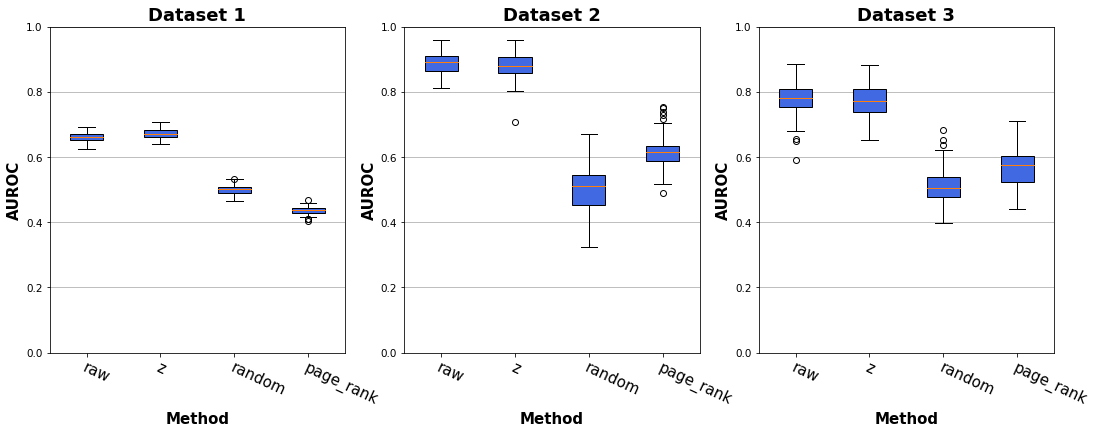

In [4]:
show_box_plot(metrics_by_method['auroc'], 'Method', 'AUROC', color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])



##### Wilcoxon test

In [3]:
df_wilcoxon = get_wilcoxon_test(metrics_by_method['auroc'], True, "AUROC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUROC,p_value,Significant difference
Dataset 1,"('raw', 'z')",4.39711e-18,True
Dataset 1,"('raw', 'random')",3.89656e-18,True
Dataset 1,"('raw', 'page_rank')",3.89656e-18,True
Dataset 1,"('z', 'random')",3.89656e-18,True
Dataset 1,"('z', 'page_rank')",3.89656e-18,True
Dataset 1,"('random', 'page_rank')",3.89656e-18,True
Dataset 2,"('raw', 'z')",0.0214347,False
Dataset 2,"('raw', 'random')",3.89656e-18,True
Dataset 2,"('raw', 'page_rank')",3.89656e-18,True
Dataset 2,"('z', 'random')",3.89656e-18,True


### 3.2. Result metrics AUPRC

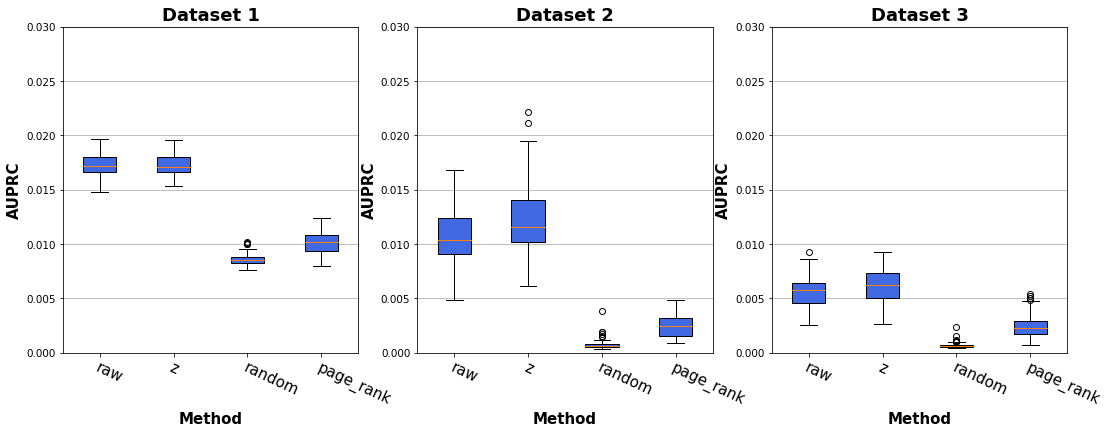

In [6]:
show_box_plot(metrics_by_method['auprc'], 'Method', 'AUPRC', y_lim = [0, 0.03],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


##### Wilcoxon test

In [4]:
df_wilcoxon = get_wilcoxon_test(metrics_by_method['auprc'], True, "AUPRC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUPRC,p_value,Significant difference
Dataset 1,"('raw', 'z')",0.0344666,False
Dataset 1,"('raw', 'random')",3.89656e-18,True
Dataset 1,"('raw', 'page_rank')",3.89656e-18,True
Dataset 1,"('z', 'random')",3.89656e-18,True
Dataset 1,"('z', 'page_rank')",3.89656e-18,True
Dataset 1,"('random', 'page_rank')",2.39579e-16,True
Dataset 2,"('raw', 'z')",3.19743e-13,True
Dataset 2,"('raw', 'random')",3.89656e-18,True
Dataset 2,"('raw', 'page_rank')",3.89656e-18,True
Dataset 2,"('z', 'random')",3.89656e-18,True


### 3.3. Export evaluation by method to  .json file

In [25]:
OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'outputs', 'metrics_by_method_validation.json')
to_json(metrics_by_method, OUTPUT_PATH)

## 4. Evaluation stratified by entity: random cross-validation by method

In [32]:
from diffupath.views import show_sb_box_plot, preprocess_for_sb_boxplot, fdr_barchart_three_plot, preprocess_for_sb_ttest


In [6]:
metrics_by_method_entity = {"gene_nodes": {"auroc": {"Dataset 1": {"raw": [0.6734108582605791, 0.6739869370150542, 0.6551969421909286, 0.6657171969752782, 0.6595824797688556, 0.6721914692128206, 0.6405656114393978, 0.6782559657451526, 0.6773569636389247, 0.6598746953654556, 0.6451977363331292, 0.6623974056481174, 0.6882593822414089, 0.6637687421856808, 0.6533872697033538, 0.6782012143513867, 0.6643075371245786, 0.6855991254987855, 0.6450071286138173, 0.6783946284220694, 0.6526608994950296, 0.6793905602086181, 0.6763529398861244, 0.6628140651465166, 0.65244972696731, 0.6732632421275545, 0.6714281546328191, 0.6534827284203706, 0.6736955059456844, 0.6592837719029219, 0.6602117838861031, 0.6584296176555187, 0.6719247143606585, 0.6943098436641278, 0.678815866969388, 0.6546609806021889, 0.6597111680999722, 0.6660524712201266, 0.6911120190614259, 0.6822815564865414, 0.6567859640994894, 0.6495155238245351, 0.6771605157601213, 0.6824861779277901, 0.6731933436934853, 0.653827669944963, 0.6736440294955139, 0.6707075527979954, 0.6928902967101964, 0.6774727857566949, 0.6492852483768372, 0.6736240759226525, 0.6734990338862539, 0.6462245353825653, 0.6553560641963818, 0.6796813675095766, 0.6636209257644301, 0.6607924669545846, 0.6499815609655046, 0.6683278281683727, 0.6667514357070858, 0.6612077116451847, 0.6656139995346498, 0.6665543833105018, 0.6926059421123199, 0.662858620749436, 0.6612854968898423, 0.6536418554770251, 0.6602245223156955, 0.672832882139418, 0.6289065453222236, 0.6587721199371686, 0.6684190810404402, 0.6400220501686072, 0.6450408537058647, 0.6736561423034493, 0.6498082478540443, 0.6648339781739345, 0.6732858528975034, 0.6396241264766389, 0.6861823570789051, 0.6885858161006528, 0.6815840495351213, 0.6307852696655426, 0.6460532852550922, 0.6654840798796615, 0.6699743440170705, 0.6957340158060251, 0.6569898051344919, 0.683847391065838, 0.6659351485037399, 0.6421363622763087, 0.6731664304376372, 0.6647564298067549, 0.66357054257338, 0.6658788600536174, 0.6430360311858188, 0.6601276692212911, 0.6472079868038689, 0.66943995859572], "z": [0.6843426567707374, 0.6818222553246516, 0.6604754319716674, 0.6809700335862714, 0.6711256517352895, 0.6835021610788239, 0.6481295947315365, 0.6872217258438402, 0.6857609033713945, 0.6758342357986457, 0.6594834486880032, 0.6660922884661676, 0.6967883879514243, 0.6708166406651375, 0.6673576487956319, 0.6858083711179821, 0.672420276065935, 0.6934463236250867, 0.6686503250197822, 0.6930257421541901, 0.6678669589998429, 0.6847400884643491, 0.6905982446339343, 0.6712352363109146, 0.6718202246939551, 0.683204854964351, 0.6774423037187989, 0.6590342233973634, 0.6819610862233514, 0.6669155983561308, 0.6649702749995459, 0.6747653415359943, 0.6799718405938301, 0.6971974886145135, 0.6865052914198674, 0.6741855835802155, 0.6694719220397911, 0.6709157557131462, 0.7028300396513886, 0.6912955797065523, 0.6666693635199215, 0.6674824702910368, 0.685881109444558, 0.6944740687484561, 0.7005349221329955, 0.6591795400840282, 0.6924631434959161, 0.6766466059372, 0.7013212780602849, 0.6904997367366159, 0.6668814983115926, 0.6812420685069055, 0.682973748093552, 0.6568652511702522, 0.6652976350334926, 0.6951949940086835, 0.6797541051784124, 0.6689868691673493, 0.6649828152954257, 0.6694151603704025, 0.6748911909116424, 0.6722735268866681, 0.6700855563454357, 0.6722781424005125, 0.6980101396153555, 0.6753679125423371, 0.6677467122183903, 0.6762174916532404, 0.6671230549094311, 0.6853041887676672, 0.6429389897703048, 0.6772922695252792, 0.6773156481894346, 0.6532962582978092, 0.6575670834415563, 0.6833367503343779, 0.6692722645357394, 0.67325057389258, 0.6857908217131519, 0.6504970732328053, 0.7015636068393556, 0.7007807510323218, 0.690031539443781, 0.6378550428410851, 0.6506763538729634, 0.672196528181231, 0.6869812043326468, 0.7052915477770625, 0.6670661303060681, 0.698081240582752, 0.6765194418414127, 0.6484569483654259, 0.6871856259011868, 0.6771869348695561, 0.6691748139565207, 0.6777032990625224, 0.6443068490535632, 0.6728476878317446, 0.6622637545541291, 0.6880601220429274], "random": [0.5001399878686268, 0.48594063415656136, 0.5201493886353301, 0.5040113119216849, 0.534340520451898, 0.527580498268487, 0.4911843067182873, 0.4889419412270984, 0.48882159488872434, 0.49508461893339184, 0.4747106705924896, 0.485859979852334, 0.5075647897527334, 0.5080420831643486, 0.4866719643814429, 0.4848346028033459, 0.49584349474201794, 0.5019606474453504, 0.4946175367076137, 0.47961376935558475, 0.4791419265752425, 0.5338456060163738, 0.5156282207273586, 0.4734685476242268, 0.4898687419095371, 0.48365344651850817, 0.5115069569429765, 0.5004671629770636, 0.47534922017513087, 0.5044285646131933, 0.5163566988699333, 0.47704684212392334, 0.5011734860149707, 0.4968840062696469, 0.5062008129481077, 0.5040994911170655, 0.5125835345975736, 0.5173048223921934, 0.5202022286493121, 0.5064791257913646, 0.5068243871613888, 0.45695517573402555, 0.5084266078843404, 0.4803994771767251, 0.47219917738497663, 0.5046478977749491, 0.5026541494606638, 0.5068530187165923, 0.49154870420166574, 0.5110990969074701, 0.5175105938098759, 0.4856124156298218, 0.4935567221697197, 0.5069953163181053, 0.5261235187598772, 0.4965465360121828, 0.5166040287013317, 0.49829146828593407, 0.4981182953058408, 0.5031342166897987, 0.5006585800125701, 0.48080351381227876, 0.4745370891595926, 0.49652265772489046, 0.4986654138126202, 0.4871925217032578, 0.5070778546880992, 0.5000981127427846, 0.48554177674544086, 0.4951547929985301, 0.47564547286209835, 0.494463572133475, 0.4951920485901068, 0.4946495037220844, 0.4921280720081638, 0.4936393571575015, 0.5024693586488587, 0.47917432749744815, 0.49458331982603826, 0.48575905070942293, 0.5290209918438735, 0.4996658175104027, 0.5084727303425889, 0.4837226410892663, 0.47128595860928424, 0.49564727653886625, 0.5216321195634843, 0.5156917808626242, 0.49154556572227226, 0.49932494815868717, 0.48742663191385494, 0.5236486058468202, 0.5053492079951953, 0.5317438808264983, 0.4843907786276465, 0.5037728338699212, 0.48299113725728626, 0.4999805916474538, 0.4800321093207841, 0.4972652169126301], "page_rank": [0.4487518997866787, 0.4273616639784865, 0.43144001248358105, 0.43124758210521186, 0.42237814415440134, 0.42417618894202674, 0.45266190897258857, 0.4289168537654705, 0.42953390711057, 0.42438816883935965, 0.45190049175507574, 0.44330966466851657, 0.441169033445908, 0.42853247547887224, 0.4338609811044322, 0.4289859083630408, 0.4412794755189203, 0.4201175602337786, 0.4142541324976734, 0.4367718220025655, 0.4360557405559241, 0.42739149989635405, 0.435597977511473, 0.4204591725751496, 0.418053895413013, 0.4329311064007578, 0.4371117396846778, 0.42541512193660896, 0.4454734569528745, 0.44252775562779856, 0.43158129422839336, 0.4199754058789706, 0.4388076544643993, 0.4541682605858045, 0.4182933218663927, 0.4392657707067425, 0.4441467104833349, 0.4366048727320942, 0.3995596556195154, 0.45579411036858297, 0.44545692358877925, 0.41035371304406565, 0.44520106076863103, 0.42631264244339007, 0.44584046459558413, 0.4490902065924841, 0.4200483916146405, 0.41848829599324017, 0.42446367083327785, 0.42174915082018216, 0.4415733281068579, 0.45916441489774185, 0.4279805736419777, 0.45135366325941084, 0.4345155009046129, 0.4213483337478663, 0.41719968551852255, 0.4420283712985029, 0.45757616321353517, 0.4452227389291291, 0.4264956053350198, 0.43152919853432165, 0.4266205967311831, 0.42557661507425354, 0.4425087007993301, 0.41307417619256026, 0.43255429199387824, 0.43756079077162, 0.435000334485939, 0.43379019040295375, 0.41539752746989517, 0.41669835359155744, 0.444406793921357, 0.4159400781531675, 0.4260272900134303, 0.44897856075916004, 0.43844585587972823, 0.4365579857053132, 0.43686768444049995, 0.4472889957264958, 0.4292386613463468, 0.4333687740528911, 0.45403273036263814, 0.4292202842993786, 0.42844787146308544, 0.448626779482325, 0.4298377938507483, 0.4128471087745272, 0.4357639599174375, 0.43405688216544763, 0.4286809596489554, 0.42862120098346435, 0.44325465045079004, 0.4414839468682794, 0.43801332508740887, 0.4370961701058789, 0.4390819070668875, 0.4455228771912232, 0.42437207912257113, 0.43467836375787294]}, "Dataset 2": {"raw": [0.8685532071695639, 0.9168373866655849, 0.8368626735089889, 0.8747261718829232, 0.9311930792478855, 0.8199782965862761, 0.8865979729958149, 0.8143631298891841, 0.9372519489124629, 0.8268037159489665, 0.9252685881963179, 0.8092161754663529, 0.9023802762621447, 0.8791919366071006, 0.9242493390938656, 0.9242273652326187, 0.9023752053710878, 0.8644415596708654, 0.9287691933226507, 0.9749869847129538, 0.9597776921360621, 0.8254599298188677, 0.9063828996031184, 0.8720031033853268, 0.865924795305031, 0.9834232571347437, 0.8493134013508854, 0.8791370019539833, 0.931497332711304, 0.8200881658925107, 0.8285354252449241, 0.931502403602361, 0.8163695124507279, 0.9125600900590252, 0.9243904788949515, 0.9185733217040899, 0.9193821288276776, 0.9223680385117273, 0.817868805906574, 0.8843608648911787, 0.8612097117705523, 0.9392481896918927, 0.9646516635903261, 0.9001566905336605, 0.8404528643773284, 0.9637727091404501, 0.9307519117259285, 0.9081272861267182, 0.8744058605978242, 0.8852854573605673, 0.9123682413473695, 0.8927210739471141, 0.864708626599866, 0.9445092391635058, 0.9452512795548434, 0.8268611860476123, 0.8823671595572773, 0.9863812769179799, 0.9063930413852321, 0.9046165392182716, 0.8734914099105495, 0.8509817245086306, 0.9280491267925599, 0.8701074352785272, 0.9196187704103365, 0.8455930576120836, 0.898894883808983, 0.9073886263294186, 0.925863572747003, 0.8267504715928682, 0.9139875458915641, 0.8265104494161715, 0.8107163140707085, 0.760686902902578, 0.8944671507677329, 0.924507109389262, 0.9878011264139335, 0.8686461735056084, 0.8576076888230799, 0.8602039850442519, 0.852968668654456, 0.9464885769727456, 0.973638127691798, 0.8506478908473798, 0.9212068044596797, 0.9318252503329885, 0.878122823742588, 0.9767161585633827, 0.8995515642008615, 0.8253280866513864, 0.8718915437820733, 0.9145825304422492, 0.8172484669006037, 0.8831015936120294, 0.8234366442871341, 0.8787161179962543, 0.820434676781404, 0.8579913862463912, 0.8631197474020136, 0.9178143783425623], "z": [0.9297622428213086, 0.9491372724015064, 0.8149885397862112, 0.8971471166913452, 0.9619598655875811, 0.8835892443020087, 0.9149679181625796, 0.8850395191443041, 0.9644327701263666, 0.8943175594815521, 0.9328563315145737, 0.8817535817393832, 0.939299743750972, 0.9466271813283029, 0.9489834553727781, 0.9588750735279203, 0.9181000385387721, 0.9205780139686146, 0.9602678782715699, 0.9184921874471783, 0.9583831970953938, 0.8882510834803892, 0.9154564140010683, 0.9067057463337458, 0.9114875966004746, 0.9858894004854533, 0.8945930778956478, 0.9437587472870732, 0.9639290616147069, 0.8854046233004063, 0.8938763919595951, 0.9624973800396206, 0.8758274003907967, 0.9477715124101607, 0.9547406070194655, 0.9309107996457138, 0.9257875093811484, 0.9313874634050695, 0.7483367477333117, 0.8943496751249129, 0.9027758057645889, 0.9459223274713833, 0.9703166940494784, 0.9345973374441358, 0.7845462904741621, 0.9239805818678457, 0.9604707139138489, 0.9044999087239609, 0.910566384725124, 0.9392017065238703, 0.945117746090343, 0.8781211334455691, 0.9039184465494277, 0.971026618797455, 0.9682274869340042, 0.8940775373048553, 0.9449081492599879, 0.985754176723934, 0.9487316011169483, 0.8866453013123465, 0.8750752182173451, 0.8973076949081491, 0.9343809794257046, 0.7764700513174175, 0.9357940677335822, 0.861473398105515, 0.8561962908122214, 0.9159144844932152, 0.9313198515243098, 0.8830331365827604, 0.9230475379133621, 0.8887716949622387, 0.8250610197223857, 0.7743301352913734, 0.8976153289656057, 0.9567216351257244, 0.9898058186784582, 0.909253023941367, 0.8964101471910644, 0.9029566675456211, 0.8965960798631535, 0.9681919906966052, 0.9770998559866939, 0.8946623800734266, 0.921778124852099, 0.9616978695496373, 0.9458547155906236, 0.9259818935383326, 0.9129040655023901, 0.890891327424055, 0.8739782154520193, 0.9543247939527933, 0.8825091445068727, 0.9370516487157123, 0.8127556574241226, 0.9142529225235458, 0.8878454121958311, 0.899966532119024, 0.9034062865526731, 0.8984841416333678], "random": [0.5453946167420538, 0.4864269149374928, 0.5465085224775698, 0.4257638452228825, 0.4201976971393413, 0.6057331494290177, 0.5299402310974084, 0.42456035374536016, 0.5108686098321197, 0.37608094494364547, 0.5017849536520558, 0.4719545918608818, 0.4085481700844472, 0.46505987032041274, 0.576053224072534, 0.571741276377085, 0.5550124067801194, 0.5275788861618764, 0.5745978783391816, 0.5216391824371378, 0.3677089038085773, 0.6178779335104765, 0.39859063034556436, 0.5367859340243266, 0.4271042507589433, 0.4802066219076016, 0.40415339783506754, 0.5088199698451012, 0.5591739180408781, 0.5536043893632989, 0.56718761620792, 0.49901793743196554, 0.5378609629284058, 0.37890374096536245, 0.45106421100315747, 0.4519955646606222, 0.43656146258020456, 0.5546743473763209, 0.5212740782810354, 0.530467603767334, 0.5571134459747267, 0.6488052980669764, 0.4591793269913389, 0.4825358511997728, 0.5440153343745562, 0.40156893369302854, 0.41936269041195917, 0.4237050634537501, 0.45691601928290837, 0.4730921617546635, 0.4353123330831693, 0.45180287080045706, 0.45362501098693064, 0.4847349276214817, 0.6309811160017038, 0.566313732649101, 0.3690019810281062, 0.350690993421364, 0.49517420201077733, 0.5387821748037565, 0.47256309878771896, 0.5441099910076199, 0.4103736908649588, 0.5529248899616641, 0.6556104338654388, 0.46536919467488824, 0.433878961211064, 0.475570137184506, 0.4917530408443372, 0.5735025658708748, 0.5117103777475778, 0.6299432736320425, 0.46897628851341755, 0.44149036868758573, 0.4733710607627972, 0.48294828367240694, 0.40299216378301994, 0.5831034529387504, 0.45408308147907755, 0.4793530219130106, 0.5009922043501485, 0.6575475142492039, 0.523118192328756, 0.6271187873133066, 0.26625389613462874, 0.3935974929514614, 0.37397145426394324, 0.4326467346842187, 0.3607938987038803, 0.5585265342826041, 0.36002650385725776, 0.33963983151119315, 0.5362501098693062, 0.5357633043278365, 0.5327985233565241, 0.5306028275288535, 0.5407243260785786, 0.4400367132512525, 0.323669905275755, 0.6280315477035625], "page_rank": [0.5837660493701953, 0.5718071979608257, 0.6012234369823466, 0.6124757442377775, 0.551192335517197, 0.684637059424082, 0.6689460321967777, 0.6363317512153236, 0.6918622340317642, 0.6336002312326322, 0.6182489537061453, 0.6137569893781736, 0.598314435812661, 0.6519737598290771, 0.5660407496805339, 0.6692181700168354, 0.6650439815284342, 0.5203494858116469, 0.6424979547406071, 0.7111966964835061, 0.8012464250218048, 0.5273413994307079, 0.7659792228690425, 0.6880827298972976, 0.6569415427678952, 0.7209666132532809, 0.6654893747929386, 0.5927567392142147, 0.5580760701270427, 0.5524710452120647, 0.6544551158529577, 0.6631914159956187, 0.5082621718288338, 0.6798306998505778, 0.71004982995612, 0.6807206412310771, 0.6273689512721176, 0.6545869590204391, 0.5767935741668526, 0.6647295862829016, 0.5877889562753966, 0.6020271732148773, 0.709825020452594, 0.5670219671000589, 0.6570438057375442, 0.6599815419565526, 0.5862026125230725, 0.7790325415982096, 0.5507139814608223, 0.573499185276837, 0.6185143303381271, 0.5874585032081837, 0.6739417050364089, 0.6384234937763263, 0.5069505013420958, 0.6154151707538049, 0.6270013116704867, 0.6151878258047505, 0.6846210016024016, 0.632659580941563, 0.619492167163614, 0.6553154770356248, 0.6145269196703245, 0.6007788888663516, 0.687778476433879, 0.6466687626349703, 0.740161626200956, 0.6116229893916959, 0.6221501592259792, 0.4993095136677417, 0.6656043149902302, 0.4988049600075725, 0.5409897027105603, 0.5611912875330454, 0.6541914295179949, 0.6651014516270799, 0.7504082067300867, 0.647782668370486, 0.6064464547710324, 0.6140620879901016, 0.6289688174005936, 0.6390962319898853, 0.6685707862585614, 0.6364238724028586, 0.6668399221111134, 0.6419950913774569, 0.7345566012859779, 0.8397175851740668, 0.6232437813972671, 0.6296221171984341, 0.5347347585917798, 0.6406800402966809, 0.47104943780721154, 0.6395652894126556, 0.6145252293733054, 0.5674217223450505, 0.5989288587790647, 0.6895406110761784, 0.6914962847271523, 0.6675261827008242]}, "Dataset 3": {"raw": [0.7629351208001838, 0.8638601766585228, 0.840065568293345, 0.7816541028907126, 0.8276145530984846, 0.9350143039111278, 0.8545755114257275, 0.78598216709474, 0.842780875218387, 0.8106767733717555, 0.8001524358412161, 0.7462068533483681, 0.8160711924102264, 0.779259676891701, 0.854071568279424, 0.8171013524330568, 0.8597652905677713, 0.8740469279653644, 0.6861714938016386, 0.8230929858631418, 0.6867714924095304, 0.8503031315472586, 0.8690791900714847, 0.7709898584922076, 0.9034064886160357, 0.8392212547070657, 0.852808926197387, 0.9018626406899288, 0.8033549806148942, 0.7621659810534083, 0.8835870450416587, 0.7830949348145364, 0.7945380637167896, 0.8526592745724488, 0.7441360924916648, 0.8280516750541183, 0.8125359337913369, 0.8790494685627179, 0.8491984937389936, 0.8067113533379273, 0.7959065060173873, 0.7367989865452748, 0.7280495868919097, 0.7923587184252472, 0.8016231980900277, 0.8127036828220816, 0.8261034197136432, 0.735445161380136, 0.7470957143950943, 0.8900123201570298, 0.7933338901765888, 0.7381757814947065, 0.8741304544537021, 0.7657715411333152, 0.8358335595509059, 0.7807394878434156, 0.8541390855241635, 0.8451224011081181, 0.854276208175851, 0.8187496084695859, 0.8080825798548031, 0.7650692225772098, 0.7996401400460788, 0.841340043294563, 0.7513882798415781, 0.8290560810763781, 0.8144723562126306, 0.8352572267813764, 0.7441360924916647, 0.8578413971197283, 0.8244746531910598, 0.872008185595857, 0.7557386177758287, 0.7376704462402639, 0.8343398275178016, 0.861368303089784, 0.7568613529899002, 0.761190113247997, 0.866971538349099, 0.8138570444152101, 0.7718738471604474, 0.8029345639569282, 0.7700251275519083, 0.7631341922640551, 0.810007865410985, 0.8005039431463036, 0.6958271558534668, 0.7930345869267125, 0.816102514843353, 0.8173721174660847, 0.6990053387347129, 0.6669047171584288, 0.8667829076962699, 0.7713733842844912, 0.8175802376328593, 0.8795923907369124, 0.8012452407302999, 0.8333848413344749, 0.7979125338456291, 0.820934522193684], "z": [0.816435924742634, 0.8372291479602136, 0.7951088280537633, 0.7768408890002575, 0.8184579618144737, 0.861281296331099, 0.8485066159939305, 0.7591423221755865, 0.8689239700139906, 0.8843304307878637, 0.7384931821503894, 0.7320525938454899, 0.6996491887489821, 0.7937772766188478, 0.8750158352300808, 0.8080241113129667, 0.8530574175001915, 0.92072570597284, 0.7755385718362602, 0.7959301718557497, 0.6827629170233943, 0.8498486082398882, 0.9242727975109106, 0.8829779977308638, 0.8343210340579256, 0.8235976250635149, 0.8539713364934187, 0.9059081069417472, 0.8438367892417882, 0.7487815573513751, 0.8024452379460836, 0.8312890225312702, 0.8312054960429326, 0.9204027368846012, 0.7311693012313196, 0.8147333764886857, 0.8291785865926065, 0.8296365901703244, 0.8825798548031211, 0.8043503379342505, 0.8074380337864646, 0.7420917816896015, 0.7893141779253412, 0.7913473518622925, 0.9051083408159146, 0.8385697480980323, 0.7761671086610008, 0.807980955960659, 0.7845810102528765, 0.8494393284470337, 0.7400892341317074, 0.8062394286788197, 0.8627993902566352, 0.7903902775167574, 0.8813993471012829, 0.7735708269818398, 0.9187356873881962, 0.8165131867443464, 0.9108584434838898, 0.8606966109127356, 0.790685404442217, 0.7529488330653524, 0.719970487307454, 0.8746629358168542, 0.7814042194797692, 0.8399569838585061, 0.7488977983809783, 0.869006800448259, 0.7934257693137603, 0.8860385474743677, 0.7951958348124482, 0.8332073475467574, 0.8268600304871684, 0.7000069605406948, 0.8733160711924103, 0.8789742947232142, 0.7552026561423291, 0.706494880522319, 0.7684360361112851, 0.9142489228563275, 0.7687819749838167, 0.7873666186389359, 0.901731086470797, 0.7747986663604027, 0.8493411848232371, 0.7323769550418677, 0.7302672151572733, 0.7642047234229155, 0.8936150960206588, 0.7475182192152686, 0.7847167407964251, 0.664048807311352, 0.7864443469968746, 0.807250099187705, 0.9035282980781947, 0.8569434873700988, 0.8176679404456138, 0.8326331029394363, 0.7309034085767783, 0.7922055865299615], "random": [0.4652369716079545, 0.4585659894060571, 0.4446323790432041, 0.4726388105828061, 0.6949014039410581, 0.47467964111452177, 0.6103920872573382, 0.571818162834889, 0.46169823271871757, 0.39997494205349876, 0.4299205802306723, 0.3761197769842762, 0.5422302964494282, 0.5397439913132452, 0.5354813561917491, 0.5650998489562669, 0.5141723569086847, 0.578330444708945, 0.47095992816722, 0.6522597395365672, 0.4906206714137554, 0.4753993610223642, 0.4751418210166566, 0.5587072883821615, 0.5367732325447041, 0.4898104644768806, 0.43493356163906816, 0.4273312590922063, 0.48758448356268314, 0.4861283384493308, 0.520776517919912, 0.5014039410581415, 0.4151210786053861, 0.48753715188595853, 0.5151524010385127, 0.5603430154454399, 0.5422831965587087, 0.4740935635880195, 0.47120076287526014, 0.3113630826842629, 0.4932434031475565, 0.4292523683239714, 0.5668901000229698, 0.4559195918338937, 0.4309688376593094, 0.6078264319572345, 0.49985452469947866, 0.40031322433126604, 0.4633256071331621, 0.3898041999902552, 0.49313481871271764, 0.4921408535015, 0.6390124384862216, 0.5718975129988098, 0.49912645214280243, 0.42063521894380757, 0.5084786346203373, 0.36070913988598635, 0.4420903895814627, 0.4953663680594709, 0.5232934494351521, 0.5437268126988104, 0.530717562140227, 0.5952626560031183, 0.5692678207243138, 0.48756220983245985, 0.44098505571912827, 0.45470010510416453, 0.47506664717715275, 0.41530344477158987, 0.5921874891241552, 0.424925696228083, 0.5674358064134422, 0.4989162438138195, 0.2939060466217016, 0.6029832877417918, 0.3894756624694606, 0.48739933318020146, 0.5272887997939679, 0.5242303382126723, 0.5885749685035534, 0.4390082621618047, 0.36619683016976756, 0.48163461337676716, 0.5391537374623262, 0.4431456075507945, 0.46037433787856646, 0.45565926761190806, 0.5056637919633598, 0.4325015487203046, 0.49225361426075576, 0.5660367377337872, 0.586627409217148, 0.4445530288792834, 0.4344783422776281, 0.5248943737949564, 0.45268154830267215, 0.3352043266720959, 0.48763181523940785, 0.4522820132667906], "page_rank": [0.5668392880758977, 0.5224331266052747, 0.4068651812872824, 0.5428275108410421, 0.4760849742808021, 0.5933241454196162, 0.5316391377282188, 0.5979772668740908, 0.5866670842991084, 0.5565014930359791, 0.5722984401428303, 0.5968099841995727, 0.6381778696569149, 0.5475453653239784, 0.4803845002679808, 0.5307843833308972, 0.6023345653490363, 0.4397182373126745, 0.440119164456695, 0.6362658091280531, 0.4518330583919759, 0.46914322704587685, 0.5205078410490926, 0.40205962399159173, 0.6205036647246758, 0.5834227762812616, 0.5084396555924464, 0.4551260901946863, 0.5396576806086297, 0.4677789610696959, 0.6346781097955689, 0.5120062366444625, 0.48843018925710147, 0.5043740037726131, 0.5116770030695984, 0.4555868779886822, 0.4875009570743455, 0.6440762318416895, 0.6353504980266867, 0.4892696304648945, 0.6244656044881567, 0.5251832362337906, 0.5780715125950984, 0.5998941997814391, 0.47601467281978466, 0.5195716483256418, 0.6306403001385147, 0.5461852756722142, 0.5958348124482309, 0.5828457474576625, 0.5887364530476727, 0.5228034273702381, 0.5548789910000209, 0.5135647017060285, 0.485770566657618, 0.5335901772849716, 0.5592843172057606, 0.5253746511028976, 0.49771485448989683, 0.5094663353449296, 0.5194748968099843, 0.5648283878691697, 0.592630875566414, 0.4932559321208072, 0.531684381242735, 0.49388725316182563, 0.6022531270229072, 0.41810367029310835, 0.541606632003174, 0.5449094085628572, 0.614269804478412, 0.5380136008965177, 0.5093723680455498, 0.5921373732311527, 0.5698441534938434, 0.5269338122185332, 0.5281324173261779, 0.6281713963540688, 0.5833998064969687, 0.4377999122971873, 0.6060368769446011, 0.680394941079023, 0.4587400029234271, 0.6236964647413812, 0.44040385057111237, 0.549201974009341, 0.5416010635706181, 0.5345027041700599, 0.5935461866677803, 0.6442934007113673, 0.43259133969526753, 0.5515970960624221, 0.5116658662044868, 0.46408012974447854, 0.40253294075883816, 0.5272720944963005, 0.454174584281707, 0.4720757028405967, 0.6185804673307023, 0.6044561381528117]}}, "auprc": {"Dataset 1": {"raw": [0.018478539210641978, 0.018243403310862154, 0.01753427127690691, 0.016008980988178347, 0.01798139912410702, 0.017100258121959568, 0.01610083863615075, 0.016577627165608916, 0.01758975012139012, 0.016939576319449864, 0.015728179171015287, 0.017338111896841604, 0.017136400465086143, 0.01760534194341974, 0.01622015315063569, 0.019057624301410864, 0.01785689555662693, 0.018261625912292787, 0.016197602405833025, 0.01906258745030139, 0.016293280054301442, 0.019424403086269276, 0.017730899481794238, 0.018232810534181458, 0.015586938180490109, 0.017396325809341133, 0.018029816813593308, 0.015559323070530737, 0.017593848601183175, 0.016463531387644018, 0.016452839966771046, 0.01702744914891797, 0.016787385260350493, 0.01863432386977955, 0.017925133090686454, 0.016720221896801807, 0.01690152473417655, 0.018033472581783616, 0.01853596372679324, 0.018197585762159654, 0.015913115730492058, 0.015997345056767826, 0.018509463240241632, 0.01907371998734419, 0.017060766463942466, 0.017045026393550697, 0.01754130294809917, 0.018172868822270434, 0.01858164575896409, 0.018106753197520815, 0.016706401443075003, 0.01695309129185437, 0.019505536683079864, 0.016379140474105082, 0.016052892903558616, 0.017330252855188015, 0.015634149794451983, 0.017580150231195545, 0.01694104747402078, 0.017998943948721532, 0.018084641155547296, 0.016505198350732407, 0.017686605692723404, 0.017354988079807676, 0.018549687977833473, 0.016934429006151594, 0.0169022780775285, 0.01702332592763029, 0.017346251125704565, 0.01747425263461449, 0.015076679184127313, 0.016756693063977143, 0.01729716705904105, 0.01643432726830584, 0.016313716747421273, 0.016439951621080064, 0.015628337832837375, 0.016590358475050564, 0.01799725483549345, 0.016647388975224157, 0.018274582593873264, 0.017958483261527644, 0.017415416889995983, 0.016245338681926996, 0.016073487479580484, 0.018902131010592748, 0.016279646809026122, 0.017756840321457218, 0.016626245116210678, 0.018042334014405314, 0.016912139516250663, 0.016667851898017998, 0.01860150106262634, 0.01748930711109694, 0.01624181813194042, 0.01815485916399654, 0.017323488711013454, 0.016340616758558205, 0.01556232573359692, 0.01838265658413287], "z": [0.01920352309905259, 0.018092982759967458, 0.016925672534663875, 0.01608703945083897, 0.017823511218613558, 0.01707609572865658, 0.015818084533339483, 0.01676272442565958, 0.017620341553942685, 0.017143405684263386, 0.016267001019509845, 0.01702389953681898, 0.01710040725476753, 0.01724445451018613, 0.01664300069374735, 0.018433421515510973, 0.017659017477936086, 0.01789319240092164, 0.01643806782628065, 0.01938651212088923, 0.01657432713089555, 0.019359848195949384, 0.017799439944650785, 0.01783907154948653, 0.015707807308744985, 0.017288058578608594, 0.01783008736873442, 0.015389493717507174, 0.01769443901649222, 0.016197502679448972, 0.01662991935442283, 0.017693380396838754, 0.016979050623201628, 0.018879820206522784, 0.01774033439522741, 0.017299529653849982, 0.0170748741735558, 0.017927600737619932, 0.017954319509935063, 0.017774251233624107, 0.01609126128244672, 0.01624441641742788, 0.01880544597474388, 0.0192742163822641, 0.018550112133533067, 0.01726727714347418, 0.017792096287949997, 0.01797472604490825, 0.018188863182543, 0.017925284039569608, 0.017091004396462856, 0.017328477549226715, 0.019336875026807858, 0.016561108731877463, 0.016332793688445098, 0.017471465130318994, 0.01578934606708552, 0.017300945556759817, 0.016976124870838757, 0.017784497267958728, 0.017792416920573914, 0.016054027187979665, 0.017631750474471353, 0.017079143769645547, 0.01831205360833042, 0.016313762261815423, 0.016738302601933996, 0.018042227888358898, 0.01722061084708055, 0.017631339376958488, 0.015012230327814624, 0.016915317525266226, 0.01797547337378736, 0.01660989828415644, 0.016514460576535155, 0.01697467450165311, 0.016247522296776902, 0.016798925368888554, 0.01858033413850499, 0.016866292101359676, 0.018619584955371617, 0.017984563587185223, 0.018009792687739244, 0.016343475311778766, 0.01588583871779896, 0.019493145599002858, 0.017012966444563918, 0.01745815656385364, 0.016989025648124587, 0.018089558493229727, 0.016949439108342526, 0.016359148398196598, 0.018363034971648803, 0.01776107293881567, 0.016374670827566728, 0.01818016690186096, 0.016807494469224273, 0.016918070803702834, 0.015927568805103896, 0.018600539928771292], "random": [0.009642837429169885, 0.008453281064563655, 0.008791248003838858, 0.009005146712886249, 0.009249481857683678, 0.008876889910273265, 0.008491604607548305, 0.007766726450427206, 0.007953043026726303, 0.008616448992819577, 0.008537862666596513, 0.008179013072920736, 0.008589216348598501, 0.008765798468944479, 0.00920741951749157, 0.008381846369099881, 0.008354373299339092, 0.00831240453986879, 0.008203290331843048, 0.008603965582701115, 0.007333689420877692, 0.009506913670365467, 0.008387036460975316, 0.008116047180015866, 0.007970765041203667, 0.00783971856640967, 0.008592867218273752, 0.00801885299862124, 0.008010432016870366, 0.008607581464477102, 0.008652316188213556, 0.008209297952320418, 0.008574965378316843, 0.008200872869471628, 0.009043831167448231, 0.008456842106358348, 0.009506029092696409, 0.008930989033372841, 0.008497421910701356, 0.008451877345420578, 0.008052980150733597, 0.007331393056617167, 0.00815092769158329, 0.007778775893945768, 0.007152780367846465, 0.008569049004766502, 0.008139963825831643, 0.008840699415736052, 0.008602593176702925, 0.008857045454659663, 0.009307710142775963, 0.008170498640986023, 0.008550734371202287, 0.008844854446984175, 0.009594164927770012, 0.008204678053557802, 0.008274301037139371, 0.00787476080091784, 0.008031662930702295, 0.008522269022631764, 0.008262841303225953, 0.0075210220351150875, 0.008719413870087548, 0.008581497962340878, 0.009229413136111012, 0.007824264861964983, 0.008462436668880677, 0.008382380836256727, 0.007947610850890342, 0.008726716055154446, 0.007441584764470898, 0.008865964558070878, 0.008560444594712937, 0.008294029009062807, 0.008075487111524757, 0.007874672776298422, 0.00848458426692, 0.007493904544833988, 0.008474980143020542, 0.008271315497052593, 0.009290390156458194, 0.00888933203892824, 0.00826676134879135, 0.008200199822787706, 0.007689766379919484, 0.008980703534081919, 0.009463169119901775, 0.008575409576412944, 0.008632860506328041, 0.008425776858763384, 0.00813303393650691, 0.009713816402689271, 0.008956351780876948, 0.009360960162142681, 0.007717103239687871, 0.008393473351890869, 0.008105770503817316, 0.008388651737635358, 0.008230876640907051, 0.008295671162831347], "page_rank": [0.010401866061575943, 0.008949139144772017, 0.00888583733578319, 0.00842222332284762, 0.009345685513210689, 0.008385066958214789, 0.00945003189520303, 0.008411337768104167, 0.008336807222617816, 0.008835542377746308, 0.009515927387834347, 0.009108452076601705, 0.008569826053868211, 0.008430420579446523, 0.009085992366465763, 0.009629959175650002, 0.008846342782112533, 0.008250451150158131, 0.008571104846899021, 0.009519973900323032, 0.008483439200590913, 0.009081349568472005, 0.008450035290294922, 0.008523564486086753, 0.007776391444661519, 0.00918958359803741, 0.009244936388979127, 0.008603650336010247, 0.009315958481654113, 0.008248585807196158, 0.008168247959042117, 0.00928379970092489, 0.009036208053854968, 0.009660891511410367, 0.008225455280045535, 0.009005059088781612, 0.009139995185331788, 0.009181324338768582, 0.0076764041145905414, 0.008823553541763323, 0.00900707154175594, 0.008540391907518525, 0.009137804496593006, 0.00939995940263981, 0.008938648764569106, 0.010071404067685419, 0.00843071046559602, 0.009295829153428845, 0.00819930290982428, 0.008695204677450016, 0.008861182478138219, 0.009513424817019032, 0.008833736684481286, 0.009857689607196088, 0.009013915954128687, 0.008075744164324376, 0.00795908702897972, 0.008568053963197082, 0.00938666414413759, 0.009828481166451778, 0.008338564571625717, 0.008132521461332832, 0.00893040527912687, 0.008870465320038257, 0.0090219282080333, 0.00762061678427836, 0.009317485461617703, 0.009889548827872796, 0.008808699097870033, 0.00858763309294999, 0.008028754179455302, 0.008223581559083936, 0.010090368116810246, 0.009191156031486252, 0.00878269579872343, 0.009338215080187605, 0.008817398796123534, 0.008544545764326722, 0.009333583835550819, 0.009430133205030023, 0.00919244679486971, 0.009238192300686184, 0.00921818068916675, 0.009168640936264063, 0.008831021949583339, 0.010638235497963295, 0.009280539403287097, 0.008282791725376212, 0.009951718569742524, 0.008287127810118417, 0.008708766900816003, 0.008268778718759414, 0.009461457084728793, 0.009360724048274122, 0.008746448900601795, 0.00881881924628416, 0.00912541115719195, 0.009700227005495856, 0.008438927366016794, 0.009057642219510423]}, "Dataset 2": {"raw": [0.013932439751786358, 0.01086735147824364, 0.0017408908272369275, 0.009894789931559131, 0.014662696434899918, 0.011374926309870147, 0.0171341349026664, 0.009160909443884294, 0.019095917648031844, 0.01385145072115499, 0.01950335896943248, 0.008544807863267986, 0.015420911164978736, 0.009540568284476336, 0.00784128353948146, 0.018886336362380962, 0.014674241112005711, 0.007683319346319114, 0.016173785020062777, 0.012914010963620793, 0.00691427307956751, 0.011780513520687362, 0.011027396774494365, 0.00872766395658664, 0.02364575924350827, 0.01984212347146014, 0.010300174847324508, 0.010670866058158774, 0.014894553828395832, 0.011200043183452343, 0.015135827158354364, 0.02054615428463354, 0.011288599913608647, 0.011829723928719687, 0.013901930494167086, 0.014026711576921603, 0.016387578472921195, 0.016928024945481603, 0.011924810145923647, 0.012945351434889778, 0.01268649871621373, 0.017717274511507314, 0.015811256577854683, 0.006860042688480008, 0.010075833313528182, 0.014116904780739606, 0.012535012248280415, 0.015330116137418949, 0.009685488410074222, 0.014275870619877947, 0.011890938141073192, 0.009329724955478985, 0.012267834394702967, 0.020518798495450675, 0.015366306652662517, 0.013505033956995377, 0.012831815577620306, 0.015699328279721248, 0.007588754260275784, 0.016181521712592982, 0.009134062082736275, 0.012956838673160146, 0.02629419116258695, 0.00686104998894646, 0.012033498647146791, 0.006936227146305328, 0.01114117836841986, 0.012697405233212535, 0.021172245168464634, 0.01274193568727938, 0.01291586306711018, 0.0088645709325368, 0.008539207726825747, 0.006691828121864515, 0.008013834916539788, 0.008815228555629174, 0.01817425796301273, 0.01752512539286282, 0.012023518497003274, 0.010497160527420276, 0.008746743238981208, 0.020115620759374182, 0.010797509161279889, 0.010358059561329971, 0.014419586940506298, 0.014439700167052273, 0.011107724441831052, 0.01757799819841289, 0.0128978229594576, 0.010324134549635803, 0.011148601431874655, 0.012905073665828165, 0.011697685770886701, 0.015663885238454103, 0.007467754508444318, 0.016869731983512666, 0.011244767604578572, 0.013907076042460479, 0.010026391157325952, 0.012975580481928902], "z": [0.01373734681737123, 0.012551333773982347, 0.0020729412204614933, 0.010808807314546797, 0.01565463858864671, 0.012328429668772544, 0.018068327829905126, 0.010629833450453574, 0.02000260788424029, 0.01739482664834704, 0.017811521463186833, 0.011657215862916438, 0.012985082211761848, 0.01023819027377127, 0.00895358492014138, 0.020523653403770294, 0.012040286579845615, 0.007817686160057919, 0.018465246235212864, 0.012911010789730129, 0.007542715422969117, 0.013161634755032972, 0.013558666913844629, 0.007689658965702678, 0.02155907596987008, 0.018297846931483966, 0.00959320024621463, 0.011882502135840817, 0.0141415309838443, 0.011785231127206235, 0.020587329963060487, 0.0233568016849405, 0.010985305574162886, 0.014217838535779884, 0.019262956529608927, 0.014816592735407383, 0.014635158890653126, 0.017918825877047802, 0.010250804860809964, 0.012982183530677956, 0.010696549858299766, 0.01888985320813218, 0.019048632963074425, 0.009384666975646381, 0.011741363983283548, 0.014696919883875881, 0.012666421611432097, 0.018333042812484487, 0.009936689528928818, 0.013548440823201207, 0.011302015910226589, 0.011519155357574003, 0.01861086448765839, 0.021047270014269627, 0.01440516699565681, 0.014944076227598437, 0.013222936283040628, 0.014870586980028216, 0.009892741665431533, 0.01805173527456786, 0.013986086716806774, 0.015315965059992715, 0.025174002556906837, 0.007156381687651461, 0.013216087044979598, 0.008801315667498652, 0.014515221664595799, 0.015630341821252784, 0.021280059159145076, 0.01142901578749764, 0.014621472745125718, 0.008000136472767129, 0.010992798290714938, 0.0092744239913099, 0.008431370704847892, 0.00757009941693004, 0.02107366900261826, 0.017810287799164923, 0.011525574286844717, 0.0139834615011775, 0.011718524974432524, 0.017089268109824942, 0.011474342645370237, 0.008196044274195532, 0.013996822955044688, 0.0168796565113963, 0.013820695680996382, 0.023747729808942408, 0.017729997021037947, 0.012067000319671367, 0.011648443238662553, 0.015927023972141244, 0.00929486638516197, 0.016626773624810822, 0.006867519818484765, 0.0145743388967604, 0.01154657621655444, 0.017175016230131308, 0.009256470706670378, 0.013111387588827786], "random": [0.00046259515900519996, 0.0003603287461100385, 0.0003838505793047944, 0.00030221509719476503, 0.00045580767187289464, 0.00046453201484978615, 0.0003661307200569666, 0.0002903411236486326, 0.0006267340056658413, 0.000289947687581383, 0.00041966751649393484, 0.00032548903765673807, 0.00030138503489051023, 0.0003199920453404024, 0.00044289206367610054, 0.0006316059803952671, 0.00038086369883073027, 0.0004836614508944398, 0.0005055357754977608, 0.00039118155370462197, 0.0002574193719788869, 0.0010286287329285698, 0.00028400146219956815, 0.00044243844421143594, 0.0003047661497835857, 0.00032929019244025014, 0.0015345107708222604, 0.0007408426882617059, 0.00046485774098806447, 0.0005579417175609917, 0.0004989768270865608, 0.0006329363282422456, 0.0007784837219690921, 0.00030872263103107526, 0.0004440270590205023, 0.00031403524256579096, 0.0002958825659643388, 0.0007565133236752633, 0.00043862463121750294, 0.00043710141711438623, 0.001386174576483371, 0.0005586913656770213, 0.0003046462476225975, 0.0003364411927549412, 0.0008643303739662464, 0.0002751522089614391, 0.0004130251855385833, 0.0003886473471935207, 0.00033897551159259797, 0.00036036006404869045, 0.00029678321134683604, 0.0005421517886913642, 0.00032887671068077733, 0.0009285860480473638, 0.0005485391852217836, 0.0006841570908686383, 0.00026017038646136107, 0.0002520996277146319, 0.00035666182518097095, 0.0004760863308997168, 0.0010403739318879824, 0.0005810217975039952, 0.0002920421590399404, 0.00046988699797621266, 0.0007739285001070006, 0.0003507964163455778, 0.00028978263719883513, 0.000324920942142494, 0.00032876573821099154, 0.0005296652225974102, 0.00034702926539453567, 0.0007880623478035664, 0.0004616597067502642, 0.00033628928447130895, 0.0003883977570067851, 0.0003489157604939141, 0.00029638006150514294, 0.000486199112295769, 0.0027564896401900867, 0.00036642219827858933, 0.0004284832919163014, 0.0006074118629353432, 0.00048204020835983865, 0.000499273853558373, 0.00022127439459734165, 0.00035340362295619083, 0.00026007905872222806, 0.0003118025023967156, 0.00028350973719944183, 0.0006084504203408201, 0.0003571065014318923, 0.0002460318922586342, 0.0006025515713569218, 0.00041474572240218354, 0.0010124879282085563, 0.0009102747184694832, 0.0003706347170432942, 0.0002943678686013919, 0.0002433231869980403, 0.0004918996187264944], "page_rank": [0.0007937526592326662, 0.0010391489804736022, 0.0009638057461065381, 0.0011190693952543654, 0.0007558367187451051, 0.0010792465401733985, 0.0011825680543001936, 0.0011850008836335679, 0.0008248126706907336, 0.0010510088903206956, 0.0006930323251887606, 0.0010193230438514812, 0.00084085429506287, 0.0009375145686879873, 0.0006856160083506928, 0.001164522763038198, 0.0009603437384259175, 0.0004531890492965702, 0.0010589355872973201, 0.0010676981865514463, 0.0014943799214000512, 0.0006295257424422501, 0.0011416759929818916, 0.0011677721692527569, 0.0009213937465795001, 0.001158279230402189, 0.0010668768440173912, 0.0009139414374604654, 0.0006268560078985679, 0.0006601354037536209, 0.0007995898910032684, 0.0009670375438636079, 0.0004632304867625463, 0.0008807325213865985, 0.001147589583970983, 0.0010921450578698223, 0.0007166162111502737, 0.0009632566943685143, 0.000603443103642859, 0.0010666361285240774, 0.0006434360861418029, 0.0007318893548818772, 0.0010749430335044213, 0.000790105821619621, 0.0010211348812289725, 0.0008511329068383018, 0.0009633384420418265, 0.0014632473339579151, 0.00069459981988445, 0.0007662501020401644, 0.0008577732336763043, 0.0010613299920767285, 0.0010971125546979038, 0.0009270507398165259, 0.0008204719716268888, 0.0007946104060031808, 0.00093876521817467, 0.0009887442895231647, 0.0013085135838209363, 0.0009589953758372433, 0.0010846093886588805, 0.0011104633606362074, 0.0008461680906643403, 0.0005837039188461033, 0.0009378820478702477, 0.0009638872688282299, 0.0015423404691869169, 0.0008634804474217264, 0.0009458483852924828, 0.0005653426824050863, 0.0007892133389207798, 0.00043700103919592007, 0.0007099814191391357, 0.0007698736398047371, 0.0009568028936986367, 0.001107648766676352, 0.0014179523397615723, 0.0006622321825343328, 0.0008686670743946252, 0.0009853623322310674, 0.0008846878001355148, 0.0009212209385351263, 0.0008720228205079077, 0.0010720070236289072, 0.0012716881579280014, 0.0008470145074345258, 0.0011041855308822615, 0.0017975206593953234, 0.0007906016570970664, 0.0010598946496179812, 0.0005803705838175095, 0.0007927603863668688, 0.0007033808618258924, 0.000990347042214737, 0.0007876658195749426, 0.0006919767523936797, 0.0010481538209672773, 0.0009169128376766693, 0.001278875678283991, 0.0011810533686862513]}, "Dataset 3": {"raw": [0.006446357231572951, 0.006778505818298147, 0.00593713816911431, 0.005042097685057955, 0.005892261834785725, 0.009609266744314175, 0.0060098853152171575, 0.007431424706230578, 0.009754896942807111, 0.007182555402294299, 0.005575971509685036, 0.005626148806422531, 0.005845819370176409, 0.006284916790122232, 0.00499656427601779, 0.0065556559186985665, 0.008301792438534017, 0.010602489618745487, 0.007194390633827403, 0.009924445053814956, 0.0041772251872548944, 0.004934962402769561, 0.008766313437032987, 0.0037428420721167914, 0.010030759348406639, 0.00877611440210863, 0.009429686516686402, 0.00836574159823548, 0.0056507009292812525, 0.0034296643872324087, 0.007389632332000685, 0.005155009548286696, 0.006405190326530478, 0.007959436393719793, 0.00590119435926875, 0.00861417763999193, 0.006617082792868453, 0.006098986005379781, 0.009616645180475376, 0.008082384469810244, 0.009518388791544824, 0.002966899626539013, 0.006013745883529798, 0.008847219433354607, 0.006489851696320654, 0.010316788988378104, 0.006030718262547114, 0.007936394779447225, 0.0050386137269524634, 0.008527372928673501, 0.008159822482797717, 0.00672667950020329, 0.010817348233016813, 0.006115545221368073, 0.006808161706169324, 0.005819207522911959, 0.009179721674809762, 0.008646217876043737, 0.008609793400375189, 0.006806912843467715, 0.006340184319678741, 0.006604222444039997, 0.007072350501285482, 0.007435469166787155, 0.007227450246701945, 0.007384376478483455, 0.008783999351326026, 0.005486902913327154, 0.00449395766060526, 0.005041679515727863, 0.007849070462395498, 0.008098138347831855, 0.004273504221749865, 0.004593413388095343, 0.009449904572451779, 0.007314870244560102, 0.005578365445943991, 0.009581040216927957, 0.00941316789980609, 0.006402570543227146, 0.009134824557201653, 0.006099984187240327, 0.00537524450187712, 0.005152995648387594, 0.009508771771690627, 0.007012320042734033, 0.006965424477408518, 0.006396537100283316, 0.006902836158908792, 0.005762073255538533, 0.006523809871044372, 0.0037036486207882033, 0.005906580940724145, 0.005349802196302855, 0.009715596290896213, 0.00846488816256109, 0.004778809827809428, 0.007072179260739157, 0.007266210247681109, 0.005834527827244538], "z": [0.0058713119101174265, 0.006305000958110538, 0.0054651772847095015, 0.004795815905888408, 0.005673200480513952, 0.009707924065935479, 0.006107300176214059, 0.007728319153056038, 0.010512604136143088, 0.008396533876571577, 0.0055957061261601914, 0.005761053516255844, 0.006795260681849124, 0.005744554268156452, 0.0058814650347756535, 0.007261042432842588, 0.011158565360477496, 0.011170779133653871, 0.007699273018474094, 0.011291033132651767, 0.003807243822679579, 0.0047879252074708055, 0.009142146942567254, 0.0045514319259369095, 0.011098072163922305, 0.009299214886906614, 0.008939834234968172, 0.007887909113991487, 0.006799753081398794, 0.003837588844059555, 0.00806508073706332, 0.005836328957462765, 0.006871401251846183, 0.008406844512890827, 0.004989746076175448, 0.00741154269991865, 0.006437103475758953, 0.006687304774932199, 0.01246317270013672, 0.008562423998443066, 0.011030694603887725, 0.004838874557554272, 0.006466957441208298, 0.01077147750709708, 0.007964760260341996, 0.01098070015978974, 0.006603478556742728, 0.008931472846509025, 0.006633107215463292, 0.008592473132072826, 0.011655641214006534, 0.007728103096955815, 0.011246114300269195, 0.006007045258812857, 0.007208737925633779, 0.006413698227927087, 0.011142011796501549, 0.010125502460201956, 0.009242553322674695, 0.007190758620118002, 0.005989381755785705, 0.00884657781910303, 0.0071255036903839376, 0.007818673132738655, 0.0076847299491379925, 0.007502988579030212, 0.009084609940544098, 0.005522508910662845, 0.004933736249583708, 0.006859196080313881, 0.008994041744303499, 0.007969688939488205, 0.005181023770035956, 0.004872510271616312, 0.010526783234472547, 0.007625701659006713, 0.0055149493139449255, 0.01301219277137675, 0.009988816134474372, 0.007174875489262679, 0.010800352496119712, 0.006936206931344359, 0.0054398469826157925, 0.005263560978349976, 0.009128981770419098, 0.006463478801570326, 0.007609336476304602, 0.0069085028006635515, 0.008162805638709147, 0.0054590420941078, 0.005926325818301327, 0.004782706068564534, 0.006478543117889324, 0.007160932434600647, 0.008340516406230165, 0.008018785436841444, 0.005404283894861743, 0.006279502223797041, 0.007369046568960656, 0.007454506871491475], "random": [0.0005320445051454535, 0.000406249330679834, 0.0003855782753696002, 0.0003987383902159156, 0.0015995409543281846, 0.00039563768576880785, 0.0006714268357053635, 0.000642089071525856, 0.00036964302884661234, 0.0003322046917863364, 0.00035029814931425115, 0.00031248383340906974, 0.0004981754836686308, 0.0005187816641666462, 0.0006415551356450032, 0.0005655014271840552, 0.0004419499271334274, 0.00047136358724509357, 0.0004245589654040071, 0.0008525314592790197, 0.0004232111993169353, 0.0004699151924895804, 0.00041038560387688327, 0.0006465966696855758, 0.00044348652398431876, 0.0004822488785312622, 0.0003505372639376287, 0.00037442439506761403, 0.00038644774069905536, 0.0004749473003762455, 0.0008355152592679642, 0.00041236322016105454, 0.0003956353432503912, 0.0004039327619265065, 0.0005897146324161938, 0.0004891123687287944, 0.0004912632592558727, 0.0005856282965824569, 0.0008684097658062914, 0.00028681696807174436, 0.0004669837042573465, 0.0005271277807142837, 0.0005239858360465447, 0.00042772251031675756, 0.0003547122038346315, 0.0006339912028144234, 0.00046157275968925957, 0.0003589212116505763, 0.00042097435785550273, 0.00033975123648355014, 0.001388943523683681, 0.0005675525097582786, 0.0005753537444727051, 0.0005450497055743548, 0.0007590439490766556, 0.0003448377851171069, 0.0005441700326719347, 0.00030732406509832206, 0.00046954758924193016, 0.0004857999648385399, 0.00043253115877481035, 0.0007873972554177588, 0.00046859400983931536, 0.0005797766225375589, 0.0006167350820278415, 0.0005514352520714504, 0.00036292670167491957, 0.00036761738812019813, 0.0005179004723661646, 0.0003730286842595913, 0.0005369810272696941, 0.0005117035611431114, 0.0005010337521220728, 0.0004869596088929308, 0.0002894036998923921, 0.00108973481554277, 0.00034001062508128737, 0.00042020284774642346, 0.00044884451842597684, 0.00046339661637713285, 0.0008502969812145989, 0.0003564569678376143, 0.0003251233437528223, 0.00047211980659503237, 0.0011268551949871132, 0.0003536450482875893, 0.00042977970363598344, 0.0004869067691340472, 0.0004478424818056133, 0.00034886263404275235, 0.00042410694120272675, 0.0005686689195672789, 0.0005595013414644324, 0.0023325802992087362, 0.0004366317119593252, 0.0007475164472893288, 0.0003808828268056255, 0.00029305413534529774, 0.0004110336486791134, 0.0006810306821684806], "page_rank": [0.0009813842043818475, 0.0007951302624312964, 0.0004790572482473946, 0.0011089187967806922, 0.0007977103290680212, 0.002016910538132484, 0.0010801480785108918, 0.001298141083889337, 0.001209550213600179, 0.0024258576242467984, 0.0011285802389122911, 0.0007401323654635914, 0.002676072159778252, 0.0006648351002098336, 0.0019679568381178575, 0.0012400891241050483, 0.002219860902324264, 0.0006813334401020805, 0.0006080777666842444, 0.002336853577163867, 0.0005344757419671953, 0.0005691459010805305, 0.0008498306222215709, 0.0016404236600621879, 0.0022760070835298302, 0.0010883042561600444, 0.0008231191069448647, 0.0006850092192417844, 0.0020463536395497113, 0.0005494624116221009, 0.0013335798557149434, 0.0008781322708539079, 0.0017137562894944853, 0.0022194932237397593, 0.0006154813408608291, 0.000644970215482494, 0.0006861635339796789, 0.0016720958657414574, 0.0024451728713532723, 0.0007204062115132779, 0.0023116096413213633, 0.002071219281988389, 0.000899906125061178, 0.0020757918540903354, 0.001812940893923391, 0.00139275879850118, 0.0024954158813480986, 0.0007617694224547149, 0.002288735210116721, 0.0010905191647570317, 0.002421433436725681, 0.0023755135280891463, 0.0019205755504759726, 0.0006598660355945629, 0.0017463282921731708, 0.0008569353313326346, 0.0010543197333644368, 0.0014596094297238673, 0.0007889472771648719, 0.0018604766689808414, 0.0007968611773885937, 0.0012756261495010376, 0.0011166192042655675, 0.0008148666198018234, 0.000901778706890118, 0.0007004468456856518, 0.00252101932125974, 0.0003847517735697388, 0.0018227006847009101, 0.0020479570077427097, 0.002523452867435849, 0.000881474162747476, 0.0017623236540379732, 0.000989448333358171, 0.0008789556300367121, 0.0019077565896149745, 0.0018671239553231611, 0.0027814043523288466, 0.002308822560528383, 0.000658304481161095, 0.0023705711915667587, 0.0026737463552341132, 0.0005570384986270229, 0.0021910906907065333, 0.0004963020280523769, 0.0009527350552010338, 0.0008977834617905538, 0.0018114136979741821, 0.0012418121798991651, 0.0012589654221172174, 0.000472028622061685, 0.00198927647017441, 0.0020100752569530544, 0.0016664900422080327, 0.0003576087647061284, 0.0006978024159736403, 0.0006594873902967559, 0.0008425571290798912, 0.001402353270035715, 0.0024612933657810632]}}}, "mirna_nodes": {"auroc": {"Dataset 1": {"raw": [0, 0, 0, 0.06392089139126111, 0, 0, 0, 0.02543114664900281, 0.02543114664900281, 0.11147122140474552, 0.02543114664900281, 0.02543114664900281, 0, 0.02543114664900281, 0.02543114664900281, 0, 0, 0.02543114664900281, 0.02543114664900281, 0.02543114664900281, 0, 0.02543114664900281, 0, 0, 0, 0.06392089139126111, 0, 0.02543114664900281, 0, 0.06392089139126111, 0.06392089139126111, 0, 0, 0, 0.02543114664900281, 0.06392089139126111, 0.02543114664900281, 0, 0.11147122140474552, 0, 0.06392089139126111, 0.06392089139126111, 0.06392089139126111, 0.06392089139126111, 0, 0.06392089139126111, 0.06392089139126111, 0.02543114664900281, 0.11147122140474552, 0.11147122140474552, 0.06392089139126111, 0.06392089139126111, 0.06392089139126111, 0.02543114664900281, 0.11147122140474552, 0.11147122140474552, 0, 0.06392089139126111, 0.06392089139126111, 0.02543114664900281, 0.11147122140474552, 0, 0.02543114664900281, 0.02543114664900281, 0.06392089139126111, 0, 0, 0, 0.02543114664900281, 0.06392089139126111, 0, 0, 0.11147122140474552, 0.02543114664900281, 0, 0.06392089139126111, 0.06392089139126111, 0.11147122140474552, 0.02543114664900281, 0.06392089139126111, 0.02543114664900281, 0, 0, 0.11147122140474552, 0.02543114664900281, 0, 0.06392089139126111, 0, 0, 0.02543114664900281, 0.06392089139126111, 0.06392089139126111, 0, 0, 0.11147122140474552, 0.06392089139126111, 0, 0.02543114664900281, 0.02543114664900281, 0.02543114664900281], "z": [0, 0, 0, 0.09361027654893428, 0, 0, 0, 0.06155520333088882, 0.06155520333088882, 0.11774029476473236, 0.06155520333088882, 0.06155520333088882, 0, 0.06155520333088882, 0.06155520333088882, 0, 0, 0.06155520333088882, 0.06155520333088882, 0.06155520333088882, 0, 0.06155520333088882, 0, 0, 0, 0.09361027654893428, 0, 0.06155520333088882, 0, 0.09361027654893428, 0.09361027654893428, 0, 0, 0, 0.06155520333088882, 0.09361027654893428, 0.06155520333088882, 0, 0.11774029476473236, 0, 0.09361027654893428, 0.09361027654893428, 0.09361027654893428, 0.09361027654893428, 0, 0.09361027654893428, 0.09361027654893428, 0.06155520333088882, 0.11774029476473236, 0.11774029476473236, 0.09361027654893428, 0.09361027654893428, 0.09361027654893428, 0.06155520333088882, 0.11774029476473236, 0.11774029476473236, 0, 0.09361027654893428, 0.09361027654893428, 0.06155520333088882, 0.11774029476473236, 0, 0.06155520333088882, 0.06155520333088882, 0.09361027654893428, 0, 0, 0, 0.06155520333088882, 0.09361027654893428, 0, 0, 0.11774029476473236, 0.06155520333088882, 0, 0.09361027654893428, 0.09361027654893428, 0.11774029476473236, 0.06155520333088882, 0.09361027654893428, 0.06155520333088882, 0, 0, 0.11774029476473236, 0.06155520333088882, 0, 0.09361027654893428, 0, 0, 0.06155520333088882, 0.09361027654893428, 0.09361027654893428, 0, 0, 0.11774029476473236, 0.09361027654893428, 0, 0.06155520333088882, 0.06155520333088882, 0.06155520333088882], "random": [0, 0, 0, 0.4297272361666391, 0, 0, 0, 0.44231269664782, 0.35045302926356126, 0.36549880532752954, 0.1472640817581794, 0.27605213976485066, 0, 0.13032575524591328, 0.590546710510752, 0, 0, 0.967992240543162, 0.5023775165006743, 0.16354001561354115, 0, 0.19036691821816376, 0, 0, 0, 0.6735350476686144, 0, 0.6193844479666911, 0, 0.10092025265548488, 0.018759906318752795, 0, 0, 0, 0.7756854581154928, 0.7204229850251946, 0.8733174043670602, 0, 0.94847531404509, 0, 0.19448321544321168, 0.8333372761467672, 0.7662227058740034, 0.49717300276785503, 0, 0.009675664166923004, 0.5075820302334935, 0.6327742423883986, 0.028695796172316768, 0.7392775188663623, 0.26481512147808195, 0.8614416503039909, 0.5410328594071585, 0.5725438243713183, 0.7596934068273757, 0.3908589813347212, 0, 0.3804262969884791, 0.32440680371886166, 0.35165953017435125, 0.7193347685174233, 0, 0.7209434363984766, 0.4194838068652268, 0.5665822904591801, 0, 0, 0, 0.64498119277992, 0.8609211989307091, 0, 0, 0.646779115705803, 0.9408814553712948, 0, 0.6168058479808852, 0.4435191975586099, 0.5379574649286745, 0.7967637387334106, 0.2814459085424996, 0.002129119254335121, 0, 0, 0.7595987793049608, 0.5198836081474296, 0, 0.8371933476851743, 0, 0, 0.20484492914764263, 0.8489981311064323, 0.3511154219204655, 0, 0, 0.27110785171867235, 0.9342102150410447, 0, 0.04506635755009347, 0.9940621229684654, 0.388824489602801], "page_rank": [0, 0, 0, 0.004613091717726059, 0, 0, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0, 0, 0, 0.004613091717726059, 0, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0, 0, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0, 0, 0.004613091717726059, 0.004613091717726059, 0, 0, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059, 0, 0, 0.004613091717726059, 0.004613091717726059, 0, 0.004613091717726059, 0.004613091717726059, 0.004613091717726059]}}, "auprc": {"Dataset 1": {"raw": [0, 0, 0, 2.5271670457417235e-05, 0, 0, 0, 2.4273612156224968e-05, 2.4273612156224968e-05, 2.6624068157614482e-05, 2.4273612156224968e-05, 2.4273612156224968e-05, 0, 2.4273612156224968e-05, 2.4273612156224968e-05, 0, 0, 2.4273612156224968e-05, 2.4273612156224968e-05, 2.4273612156224968e-05, 0, 2.4273612156224968e-05, 0, 0, 0, 2.5271670457417235e-05, 0, 2.4273612156224968e-05, 0, 2.5271670457417235e-05, 2.5271670457417235e-05, 0, 0, 0, 2.4273612156224968e-05, 2.5271670457417235e-05, 2.4273612156224968e-05, 0, 2.6624068157614482e-05, 0, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.5271670457417235e-05, 0, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.4273612156224968e-05, 2.6624068157614482e-05, 2.6624068157614482e-05, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.4273612156224968e-05, 2.6624068157614482e-05, 2.6624068157614482e-05, 0, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.4273612156224968e-05, 2.6624068157614482e-05, 0, 2.4273612156224968e-05, 2.4273612156224968e-05, 2.5271670457417235e-05, 0, 0, 0, 2.4273612156224968e-05, 2.5271670457417235e-05, 0, 0, 2.6624068157614482e-05, 2.4273612156224968e-05, 0, 2.5271670457417235e-05, 2.5271670457417235e-05, 2.6624068157614482e-05, 2.4273612156224968e-05, 2.5271670457417235e-05, 2.4273612156224968e-05, 0, 0, 2.6624068157614482e-05, 2.4273612156224968e-05, 0, 2.5271670457417235e-05, 0, 0, 2.4273612156224968e-05, 2.5271670457417235e-05, 2.5271670457417235e-05, 0, 0, 2.6624068157614482e-05, 2.5271670457417235e-05, 0, 2.4273612156224968e-05, 2.4273612156224968e-05, 2.4273612156224968e-05], "z": [0, 0, 0, 2.6099438862064465e-05, 0, 0, 0, 2.5207965717166626e-05, 2.5207965717166626e-05, 2.681324574339724e-05, 2.5207965717166626e-05, 2.5207965717166626e-05, 0, 2.5207965717166626e-05, 2.5207965717166626e-05, 0, 0, 2.5207965717166626e-05, 2.5207965717166626e-05, 2.5207965717166626e-05, 0, 2.5207965717166626e-05, 0, 0, 0, 2.6099438862064465e-05, 0, 2.5207965717166626e-05, 0, 2.6099438862064465e-05, 2.6099438862064465e-05, 0, 0, 0, 2.5207965717166626e-05, 2.6099438862064465e-05, 2.5207965717166626e-05, 0, 2.681324574339724e-05, 0, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.6099438862064465e-05, 0, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.5207965717166626e-05, 2.681324574339724e-05, 2.681324574339724e-05, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.5207965717166626e-05, 2.681324574339724e-05, 2.681324574339724e-05, 0, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.5207965717166626e-05, 2.681324574339724e-05, 0, 2.5207965717166626e-05, 2.5207965717166626e-05, 2.6099438862064465e-05, 0, 0, 0, 2.5207965717166626e-05, 2.6099438862064465e-05, 0, 0, 2.681324574339724e-05, 2.5207965717166626e-05, 0, 2.6099438862064465e-05, 2.6099438862064465e-05, 2.681324574339724e-05, 2.5207965717166626e-05, 2.6099438862064465e-05, 2.5207965717166626e-05, 0, 0, 2.681324574339724e-05, 2.5207965717166626e-05, 0, 2.6099438862064465e-05, 0, 0, 2.5207965717166626e-05, 2.6099438862064465e-05, 2.6099438862064465e-05, 0, 0, 2.681324574339724e-05, 2.6099438862064465e-05, 0, 2.5207965717166626e-05, 2.5207965717166626e-05, 2.5207965717166626e-05], "random": [0, 0, 0, 4.148172729912474e-05, 0, 0, 0, 4.241781548250265e-05, 3.641925850389686e-05, 3.7282827529639845e-05, 2.7741559630482425e-05, 3.26765349802307e-05, 0, 2.720126213856323e-05, 5.7773412675486743e-05, 0, 0, 0.0007385524372230429, 4.753755466818787e-05, 2.8281342798156058e-05, 0, 2.9218407596785974e-05, 0, 0, 0, 7.245851749873198e-05, 0, 6.215040397762585e-05, 0, 2.6311635004999212e-05, 2.4108585067142408e-05, 0, 0, 0, 0.00010545186122535063, 8.460952703274389e-05, 0.00018670649738610905, 0, 0.0004589261128958238, 0, 2.9367713136178086e-05, 0.0001419244961680386, 0.00010118385105737125, 4.704554008280015e-05, 0, 2.388744237154528e-05, 4.803996925441968e-05, 6.441638752898738e-05, 2.435519618110524e-05, 9.072763563781528e-05, 3.217710277366626e-05, 0.0001707067258449983, 5.1541078239356766e-05, 5.534034311012728e-05, 9.84348853233586e-05, 3.883495145631068e-05, 0, 3.818105456072697e-05, 3.5015231625757206e-05, 3.648702886123983e-05, 8.428150021070375e-05, 0, 8.47673137238281e-05, 4.0749796251018746e-05, 5.457919441109049e-05, 0, 0, 0, 6.663113006396588e-05, 0.00017006802721088434, 0, 0, 6.69702652022502e-05, 0.0004, 0, 6.173220569170936e-05, 4.2509777248767215e-05, 5.119803399549457e-05, 0.00011638733705772812, 3.292181069958848e-05, 2.3706794367265658e-05, 0, 0, 9.839614287119945e-05, 4.927079227433977e-05, 0, 0.0001452854859799506, 0, 0, 2.9750394192723054e-05, 0.00015664160401002505, 3.645643456069996e-05, 0, 0, 3.245488770608854e-05, 0.0003594536304816679, 0, 2.477271038224292e-05, 0.003968253968253968, 3.8705681994116735e-05], "page_rank": [0, 0, 0, 2.376595289588136e-05, 0, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 0, 0, 0, 2.376595289588136e-05, 0, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 0, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05, 0, 0, 2.376595289588136e-05, 2.376595289588136e-05, 0, 2.376595289588136e-05, 2.376595289588136e-05, 2.376595289588136e-05]}}}, "metabolite_nodes": {"auroc": {"Dataset 1": {"raw": [0.8551262942897474, 0.5266901669466197, 0.5902355548195288, 0.5098918778243073, 0.6447430680420176, 0.5638805428722389, 0.49432786031986375, 0.5520436568959126, 0.3598407778934418, 0.627064209330936, 0.07704355643882933, 0.13893108098516577, 0.5330305109339389, 0.7636171504727657, 0.4227725466073625, 0.23756742689505062, 0.20385989400965268, 0.6679441986641117, 0.7905005244189989, 0.6190825427618349, 0.2959508375130122, 0.5062862280265928, 0.6690561246618877, 0.5798023768403953, 0.602352843758872, 0.1613239016773522, 0.4708585691303113, 0.7294771705701443, 0.555596564695862, 0.827201968345596, 0.500147865997918, 0.46218089762699033, 0.6418330652029904, 0.9125836901748325, 0.4918618405488526, 0.6294596384972083, 0.39678709158445125, 0.5021458821302671, 0.5525574902999906, 0.07616343719686755, 0.7025243085949513, 0.6083339247833321, 0.46104710307790575, 0.3894731238762184, 0.4599853313459673, 0.7405663725188671, 0.9809562111140026, 0.5131653655074521, 0.5004731711933378, 0.7682068024635864, 0.20750331219835336, 0.1962760546052476, 0.4128814762242725, 0.4366241611267516, 0.6368701206529453, 0.9158149988171279, 0.7556957982398032, 0.16718006955781106, 0.08883052972768354, 0.5811587688376825, 0.3322371793355256, 0.5017625626951832, 0.7357716845284566, 0.6086696791899309, 0.5925818586164474, 0.09574845624245869, 0.6425546512728305, 0.0496301203489014, 0.5673582688652834, 0.43560140058673225, 0.8311666035771743, 0.3194648180570671, 0.31382487934134573, 0.6690561246618877, 0.5795963754229068, 0.20122081056143087, 0.2626162254240897, 0.511690994976618, 0.2532412226743636, 0.7822833124354334, 0.3641611659214044, 0.5208372764266112, 0.43935719693385067, 0.6679441986641117, 0.6553108266893783, 0.7387745445942749, 0.5720775072751793, 0.7404187366926899, 0.8183933063632134, 0.6397280907205438, 0.5638805428722389, 0.6259601886465086, 0.8774426307073575, 0.4734432667739188, 0.8409945823180108, 0.4767199772877827, 0.1613239016773522, 0.8373433643253132, 0.8164687233841204, 0.37675364924649263], "z": [0.5852358308295282, 0.5436844969126309, 0.6085389607829221, 0.509328790782407, 0.46438795306141756, 0.6015204207969591, 0.5513272451973124, 0.33205580133588836, 0.3280141005015615, 0.725501561464938, 0.08921380746208626, 0.16217379989116806, 0.2588342914823314, 0.8419487883161024, 0.5139762941232138, 0.3205025078073247, 0.17877590612283523, 0.48975214302049563, 0.6123005827753989, 0.5142933749714133, 0.3040184063594208, 0.5243617952539807, 0.45055872309888256, 0.3105191353789617, 0.4304970663386013, 0.003974543992050919, 0.4175854074003975, 0.45391530636385136, 0.5899732651950694, 0.6013705867972589, 0.5764822087631305, 0.19245274090898337, 0.6633032081006909, 0.49884470100231054, 0.5350130115921458, 0.6372137314280306, 0.39872240755199095, 0.5057089455130479, 0.4149060755181224, 0.11386660988478009, 0.5444730969110538, 0.5653157948693683, 0.35951485328097027, 0.4152432099933756, 0.4876712328767123, 0.02080326795839345, 0.9930212202219015, 0.6655665956943458, 0.5640969527775149, 0.7527817864944364, 0.21140105990347308, 0.1784560058674616, 0.6305890702625976, 0.519679512960641, 0.7532883841968299, 0.5695883605393897, 0.5924103340588625, 0.15588047412875294, 0.14429223744292238, 0.744777496510445, 0.2287018855425962, 0.1991873284754424, 0.8296150843407698, 0.6309087252768051, 0.6307490299990537, 0.14994676698133297, 0.6339074477145832, 0.03335226107667314, 0.742356494515287, 0.23145760386107694, 0.662640768430018, 0.41314531774949126, 0.3585809595911801, 0.45055872309888256, 0.5818014053516928, 0.18637707904511794, 0.15498615941514657, 0.5455140489089719, 0.1604996687801647, 0.5463499649073, 0.19878392126245062, 0.023770937825305205, 0.25003548783950036, 0.48975214302049563, 0.7597214664805572, 0.49759876981310625, 0.5714197837556485, 0.41163946061036194, 0.630911542738177, 0.7704700844590598, 0.6015204207969591, 0.43228599820186436, 0.4977170570144311, 0.34520204409955524, 0.6285457427429085, 0.2659517838553989, 0.003974543992050919, 0.6262036007475927, 0.6297731144127945, 0.27914862744170277], "random": [0.3820766992358466, 0.4213332071573336, 0.39744651320510693, 0.5387749307970757, 0.6604346077410808, 0.6783142886433714, 0.5091085454717517, 0.47047087305905827, 0.7152455758493423, 0.382677202611905, 0.7257292923557386, 0.6449050086355786, 0.4935295370129409, 0.366525507266949, 0.3881600738147062, 0.5071448850194, 0.652645026970758, 0.5335825309328349, 0.7303066865393867, 0.19998895960002208, 0.6655271127093783, 0.33839638488655455, 0.8164218063671563, 0.6856955846286088, 0.2283110154253809, 0.40887332718225333, 0.5088778745149996, 0.46945824461793234, 0.49618851586343954, 0.760691444478617, 0.48210229961199963, 0.6462157238507582, 0.47063972745339266, 0.4523015290953969, 0.6602791577951266, 0.21008800984196083, 0.5428111765680081, 0.5230558118626825, 0.34472887290621745, 0.6549979889748503, 0.42513425914973146, 0.48210272303579454, 0.5364924649270151, 0.4756967445821898, 0.5069723424894126, 0.5744162388511675, 0.3144236001040903, 0.37104329311568485, 0.3093001798050535, 0.3443264173113471, 0.5010764644648434, 0.5604750751177041, 0.8353678731961203, 0.897379482205241, 0.1483439791814526, 0.11671398154719659, 0.4440948235071449, 0.5965978186291906, 0.5463789717746705, 0.6354144487291711, 0.26541121546917756, 0.5520192580675688, 0.40403920919192154, 0.7724401438440428, 0.5920317971041923, 0.4525563678519886, 0.2933306520299044, 0.5441331882206344, 0.6164091887671816, 0.45468202895807697, 0.5248000851708148, 0.660381078565908, 0.6121829753004637, 0.4388558991222882, 0.49712541699197954, 0.5083256441195259, 0.7163508174225756, 0.26645216746709566, 0.6582580202517271, 0.8919302562161394, 0.3759292119147325, 0.536641194284092, 0.5237413646257215, 0.5250577649498844, 0.36388369727223263, 0.49964513839602553, 0.5031774197364374, 0.18073101490418736, 0.6362661367274677, 0.6382691807234616, 0.5136309509727381, 0.5883925613968675, 0.4705819730305181, 0.47836424718463144, 0.8027395963945207, 0.3617216333869594, 0.6419282847161434, 0.4513000070973999, 0.22577363490110722, 0.21867877956264242], "page_rank": [0.8546058182907883, 0.7917228544165542, 0.679512960640974, 0.6133863297608063, 0.6719385823791048, 0.5633048648733903, 0.5167266016844895, 0.8824591702350817, 0.6505926469196556, 0.5370729629980127, 0.8037239453947524, 0.7902808337473679, 0.8817336582365327, 0.5633048648733903, 0.537617109870351, 0.6714831551055171, 0.7378395003312198, 0.5010291229979418, 0.680238472639523, 0.7032498205935004, 0.6505926469196556, 0.6827501360399366, 0.9709322040581355, 0.8546058182907883, 0.7759889277940759, 0.9980600440038799, 0.6505926469196556, 0.9572983203217412, 0.6130219793219297, 0.9709322040581355, 0.7556425664805526, 0.8738874299098588, 0.8433448471657046, 0.9702066920595865, 0.5203572273480009, 0.7764443550676635, 0.7209170274682376, 0.6130219793219297, 0.625319390555503, 0.8037239453947524, 0.7917228544165542, 0.5639120868721759, 0.679512960640974, 0.7769885019400019, 0.6125866515248303, 0.9980600440038799, 0.9981547633129095, 0.5548734326945824, 0.537617109870351, 0.6510523866978952, 0.7591854357906691, 0.7371945016206497, 0.25154956233735515, 0.7019170865961658, 0.3458717766737639, 0.9552992666193517, 0.5380725371439387, 0.699462937989448, 0.7371945016206497, 0.5004219009991562, 0.8811264362377471, 0.8899640389893063, 0.5633048648733903, 0.6247752436831646, 0.625319390555503, 0.7371945016206497, 0.7764443550676635, 0.766774712534898, 0.5004219009991562, 0.8899640389893063, 0.8428007002933662, 0.677163677660531, 0.6034293082237153, 0.9709322040581355, 0.7209170274682376, 0.7371945016206497, 0.68238578560106, 0.535451512929097, 0.8895086117157187, 0.7917228544165542, 0.7204816996711383, 0.8895086117157187, 0.6515922210655816, 0.5010291229979418, 0.7019170865961658, 0.9979891175774781, 0.7209170274682376, 0.521268038798202, 0.8824591702350817, 0.7026425985947148, 0.5633048648733903, 0.6775264594078771, 0.9979891175774781, 0.6714831551055171, 0.8539985962920028, 0.7591854357906691, 0.9980600440038799, 0.8539985962920028, 0.7560979937541402, 0.7903901204192197]}, "Dataset 2": {"raw": [0.7839177975697554, 0.7781852596711227, 0.8993561034966453, 0.8912879620084162, 0.8010140102415034, 0.8637744841222896, 0.8228490307752108, 0.9058694292812358, 0.8119180003718037, 0.8166230078923797, 0.7849115276064288, 0.792638285646685, 0.9154991465413801, 0.8626725929931892, 0.8352841763701813, 0.7956431359956735, 0.878531713170303, 0.8555474810295585, 0.7108651197377094, 0.838319447026415, 0.8466241909043282, 0.8698686856737252, 0.8144462659072856, 0.8272937756671342, 0.8810734988423383, 0.8247283297561305, 0.8022781430092443, 0.8736239036014264, 0.8725287725406026, 0.836446908113772, 0.8098494194791368, 0.9117405485795407, 0.8075307160602322, 0.7526491017559278, 0.7598147741292187, 0.8310422335265586, 0.8692264791874398, 0.802842608710348, 0.790373662773994, 0.878531713170303, 0.9158337699210762, 0.7809163272549052, 0.8898683476703114, 0.8389109530006253, 0.8052458129827111, 0.893285562184178, 0.7509286643795102, 0.9168680603674096, 0.8829764580622264, 0.8529718950161396, 0.8196210981730916, 0.7843943823832621, 0.908205032870832, 0.7692416893410623, 0.7653884504233492, 0.8177755995335553, 0.8091024319345625, 0.8376400601646077, 0.8548004934849842, 0.8602457284818577, 0.8327559108346994, 0.8184380862246708, 0.9140457318618919, 0.8777644454208987, 0.8896993459633942, 0.8122762839904683, 0.8658802453904785, 0.8759595071910226, 0.8820672288790117, 0.8713085802166602, 0.8246708691757787, 0.8611481975967957, 0.7517533927092663, 0.7758090956718662, 0.835811461695763, 0.8468574132598738, 0.8409592536884622, 0.8657889844687431, 0.9145459769143668, 0.845809602676987, 0.8673640803772117, 0.8417738419158034, 0.9305977590373663, 0.8254110966520762, 0.864531611769279, 0.8596339423028173, 0.7975629953862534, 0.868905375944297, 0.8528840141285428, 0.8597623836000743, 0.7841273596863328, 0.9307566206418685, 0.8660830474387791, 0.8121410826249345, 0.7964475841205996, 0.7832417907420864, 0.8990451403559175, 0.8722110493315982, 0.8132193135150665, 0.9308952020415406], "z": [0.7247029795000929, 0.792452383769076, 0.7464534991803418, 0.7013942640820672, 0.7302158151797333, 0.5605617616737928, 0.6882324111473526, 0.8078889996788967, 0.7224755370029237, 0.7533352486860116, 0.8209900119991211, 0.8381267850805294, 0.863825184634365, 0.7867029456997515, 0.6580926467357321, 0.8425343495969309, 0.8146118875800644, 0.7901641006574167, 0.7557080326511298, 0.7858613171993036, 0.804353483970188, 0.662611752378699, 0.7181186729985973, 0.8726943942133816, 0.8037822582008078, 0.8426932112014331, 0.8268036707170742, 0.8622365685893427, 0.8023356035895961, 0.7724020212604148, 0.8799006269963328, 0.8130976322860861, 0.828074563553092, 0.7801896199151612, 0.7373916276554393, 0.8572848185766676, 0.8129590508864138, 0.7445268797214852, 0.8467931926112453, 0.8146118875800644, 0.941251626641429, 0.7043112335434587, 0.6869006776968448, 0.8767064947355968, 0.8441466258809214, 0.934849841983404, 0.7653783103209343, 0.831741900593196, 0.9298541515269305, 0.7660509371144648, 0.7610011661117777, 0.8445184296361394, 0.5930776900846699, 0.7520474556793024, 0.8060029406297003, 0.7431174054857954, 0.7461864764834124, 0.7626878031468118, 0.7545757212147842, 0.7780263980666206, 0.7095840867992766, 0.8722549897753966, 0.8624326105693668, 0.8154433759780974, 0.8115867570262459, 0.8639096854878234, 0.7702692197191192, 0.7913065521961771, 0.9213128052593331, 0.7935779351371448, 0.729556708522756, 0.8382856466850315, 0.6739957073566443, 0.8520221054232648, 0.7811630697470044, 0.7202548545740312, 0.7567152828243565, 0.8897432864071928, 0.758425580098359, 0.8952121816430346, 0.7962042216626387, 0.9004579946257457, 0.656406009700698, 0.7522096973179428, 0.7032904632336787, 0.8797147251187236, 0.8411586757026246, 0.8014331344746581, 0.7055212857649862, 0.8710246573490391, 0.7155735072924236, 0.6502137871592503, 0.6831826401446655, 0.7461898565175509, 0.7661151577630932, 0.8216220783829917, 0.9038380287640906, 0.6607324533977794, 0.8634432407767318, 0.7135860472190769], "random": [0.5306281793446114, 0.39728921262104744, 0.24523837690760672, 0.4949485389802437, 0.24984198340403235, 0.5733754710922581, 0.3769109868009667, 0.6625610518666238, 0.4737861452400669, 0.44761454090686315, 0.4530225955282148, 0.37449088235791184, 0.5034459448040425, 0.3939260786533944, 0.40519849250477424, 0.5159520711159182, 0.5461695763127208, 0.4407260313329165, 0.676983657534941, 0.6659039056294469, 0.45530749860573594, 0.4392151560730764, 0.5609132852241807, 0.47339744131415734, 0.5162630342566459, 0.31547886633655, 0.42677663044396746, 0.5538118334995183, 0.36712240793632006, 0.5269101417924321, 0.6337428808030962, 0.4470264149667912, 0.38280576633824, 0.6116712578797046, 0.38293082760135877, 0.4091700326173294, 0.370620743269507, 0.6275844586030319, 0.7120717919250984, 0.4501901269202819, 0.6805191732436497, 0.5542343377668114, 0.5423264774974227, 0.6562437680620574, 0.5716178533403187, 0.6079430802251102, 0.32591979178989705, 0.2793665816024742, 0.39019114093052343, 0.4805563536191716, 0.6554021395616096, 0.3834107924490037, 0.5441685961028206, 0.5170134018353585, 0.5402443764682023, 0.4752294198171401, 0.6534045393858477, 0.5069916006151662, 0.4702100691216981, 0.5401362153757753, 0.5695763127207585, 0.42137871592503084, 0.32117422385966093, 0.46487975528552833, 0.6042926433556979, 0.6153926754660222, 0.6016257964205438, 0.6778827466157408, 0.4889760186577884, 0.4911764208818508, 0.5873823325615588, 0.5021885721045782, 0.5578239340217337, 0.3868989876797755, 0.6384039478798735, 0.5022933531628669, 0.31155802673607, 0.5625052813033411, 0.4390630545368508, 0.7012455425799801, 0.666512311774349, 0.6073684744215917, 0.4377549813253113, 0.4919943891433304, 0.49092629835561336, 0.4482161869834884, 0.3069003396934309, 0.44729681769785873, 0.5107400584745905, 0.6163559851954503, 0.3269371820655389, 0.3490459853644522, 0.3002044920653698, 0.6518970441601459, 0.2734785621334775, 0.6207500295752988, 0.2746379138429298, 0.56365111287624, 0.6057291578644943, 0.43045748762062497], "page_rank": [0.5584509303543965, 0.6230805631136874, 0.7285190380422842, 0.6693785807236654, 0.550808673167599, 0.8956820063882646, 0.6682141589630055, 0.6221527437427119, 0.40561254668672153, 0.5104510655557621, 0.43766203038650686, 0.6318111912930321, 0.56710212773149, 0.5479001537915533, 0.6803958019976002, 0.5540873062817935, 0.685352622061483, 0.5591624275405183, 0.5443037974683544, 0.5414814689628364, 0.5334167075087458, 0.7472359770833685, 0.5653276098088591, 0.4636037923983032, 0.560757803653817, 0.4981308411214953, 0.42209697317942907, 0.5249362018556387, 0.6457251018235284, 0.6398894728836761, 0.6359449730442278, 0.6673708404454886, 0.6735579929357287, 0.6825877541363168, 0.6654746412938771, 0.5494870798195062, 0.6321272244849674, 0.5326714099812407, 0.5580013858139967, 0.685352622061483, 0.5695357523110984, 0.5082946037754981, 0.7967146068175288, 0.5203883659224957, 0.440917003261733, 0.662905815348735, 0.5421946561660274, 0.640191985939058, 0.5754170117118182, 0.5734751820993392, 0.7925081543323587, 0.4544979804296023, 0.8694833617819541, 0.6605195112470637, 0.31853610721468284, 0.5397914518936641, 0.5287877507562826, 0.6744570820165283, 0.6260009126092174, 0.44086799276672695, 0.6644403508475436, 0.5658667252539251, 0.7521082962937926, 0.6761048486589716, 0.5548968244579271, 0.4009176792685606, 0.6044954454039986, 0.5411806459245239, 0.6157847594260702, 0.6304372074157949, 0.538143685251221, 0.6381048148586301, 0.5148806002940629, 0.4564076997177671, 0.655719862770614, 0.6393706376434403, 0.5655794223521657, 0.5507157222287945, 0.750367578712545, 0.570816785249531, 0.5608625847121056, 0.6582126379476434, 0.8748576160619222, 0.5402528265535482, 0.7386997008669788, 0.5123337445708201, 0.45511990671105773, 0.7782258200807828, 0.6762789204170963, 0.6329756130536919, 0.33587906237853005, 0.8552804583326292, 0.6496780517483227, 0.576834936032854, 0.503567626033023, 0.6234253265957987, 0.5557283128559598, 0.8611735478528333, 0.49847560460360646, 0.7631508678237651]}, "Dataset 3": {"raw": [0.867429260906596, 0.7341428503832688, 0.7897522948802876, 0.8697241411942841, 0.7598656193810921, 0.9302249929024321, 0.7822998485852182, 0.7611550108829375, 0.9494416579918614, 0.9176682123592316, 0.811713352891076, 0.910470095580581, 0.8728589003501467, 0.8479109491814139, 0.8813050061512255, 0.7611550108829375, 0.8768039651746001, 0.8355907542348822, 0.9367547553704931, 0.867429260906596, 0.7822998485852182, 0.8650397463802404, 0.7822998485852182, 0.8899817829090565, 0.879506955616542, 0.8899817829090565, 0.7978080344468629, 0.7665314185672376, 0.8579007760007571, 0.8768039651746001, 0.8027112709378252, 0.7665136746474874, 0.7151154537711745, 0.8710845083751301, 0.8579007760007571, 0.910470095580581, 0.7611550108829375, 0.8857173275291, 0.7151154537711745, 0.8907920885776474, 0.7822998485852182, 0.9120079019589288, 0.8899817829090565, 0.8813050061512255, 0.7897522948802876, 0.7665136746474874, 0.9176682123592316, 0.7897522948802876, 0.8961566669821142, 0.9120079019589288, 0.8650397463802404, 0.7665136746474874, 0.9014502697075802, 0.8491352796441752, 0.8780046370776947, 0.8697241411942841, 0.8596810826156903, 0.7598656193810921, 0.8907920885776474, 0.8329114223526072, 0.8701854831077884, 0.8710845083751301, 0.9085655815273966, 0.9249787072962997, 0.9014502697075802, 0.9014916721869972, 0.7500354878395004, 0.9014502697075802, 0.9494416579918614, 0.8112283524179048, 0.8171015898552096, 0.8321366045235166, 0.7416544430775054, 0.879506955616542, 0.8355907542348822, 0.764567758114886, 0.8829906785274912, 0.7383954764833918, 0.7897522948802876, 0.7665314185672376, 0.81392542821993, 0.8961566669821142, 0.9014916721869972, 0.8710845083751301, 0.8907920885776474, 0.811713352891076, 0.8650397463802404, 0.7643844042774677, 0.9014502697075802, 0.910470095580581, 0.81392542821993, 0.829214772404656, 0.7383954764833918, 0.7015709283618813, 0.9014502697075802, 0.8728589003501467, 0.9302249929024321, 0.8697241411942841, 0.8710845083751301, 0.8625023658559667], "z": [0.7966132771836851, 0.6539166745528532, 0.230605895713069, 0.8723561559572253, 0.6764691965553138, 0.5922979559004448, 0.7190960064351282, 0.6110651083562033, 0.659151130879152, 0.4246238289012965, 0.6514443550676635, 0.7188357622787924, 0.8860485473644364, 0.6526568562505914, 0.8911114791331504, 0.6110651083562033, 0.6957272641241601, 0.6633209520204411, 0.7471136557206397, 0.7966132771836851, 0.7190960064351282, 0.6335821425191634, 0.7190960064351282, 0.7203321661777231, 0.4998166461625816, 0.7203321661777231, 0.283961862401817, 0.5394092457651178, 0.6958751301220781, 0.6957272641241601, 0.6671654679663103, 0.5233391691113845, 0.40129057442982874, 0.3849839121794265, 0.6958751301220781, 0.7188357622787924, 0.6110651083562033, 0.6909364057916154, 0.40129057442982874, 0.7575707390934039, 0.7190960064351282, 0.9156454055077128, 0.7203321661777231, 0.8911114791331504, 0.230605895713069, 0.5233391691113845, 0.4246238289012965, 0.230605895713069, 0.7482610958644837, 0.9156454055077128, 0.6335821425191634, 0.5233391691113845, 0.5620149995268289, 0.6820821898362828, 0.7122172802119806, 0.8723561559572253, 0.6735414497965364, 0.6764691965553138, 0.7575707390934039, 0.8547482729251443, 0.5862709378253051, 0.3849839121794265, 0.4984621936216523, 0.5170933093593262, 0.5620149995268289, 0.49914829185199205, 0.48123284754424145, 0.5620149995268289, 0.659151130879152, 0.8455273492949749, 0.8443030188322134, 0.4931390176966027, 0.45966215576795677, 0.4998166461625816, 0.6633209520204411, 0.4759037569792751, 0.8897274533926376, 0.7479653638686476, 0.230605895713069, 0.5394092457651178, 0.8435222863632061, 0.7482610958644837, 0.49914829185199205, 0.3849839121794265, 0.7575707390934039, 0.6514443550676635, 0.6335821425191634, 0.6852938393110628, 0.5620149995268289, 0.7188357622787924, 0.8435222863632061, 0.44230860225229485, 0.7479653638686476, 0.6427320904703322, 0.5620149995268289, 0.8860485473644364, 0.5922979559004448, 0.8723561559572253, 0.3849839121794265, 0.706148859657424], "random": [0.4928077978612662, 0.5757251348537901, 0.4189812624207438, 0.3302439197501656, 0.7648161729913883, 0.52785795400776, 0.31587725939244815, 0.2941705308980789, 0.5903934418472603, 0.3485733888520867, 0.2874455853127661, 0.7524545755654395, 0.7205746664143088, 0.5316374089145453, 0.40083514715624113, 0.429674931390177, 0.38383647203558247, 0.8025338317403237, 0.5364933282861739, 0.4765602820100312, 0.37177060660546984, 0.4362815841771553, 0.19746616825967636, 0.4040822844705214, 0.42338766915870163, 0.4356546323459828, 0.5338376549635658, 0.6693302261758304, 0.5172293460774109, 0.6164356014005867, 0.6706373615974259, 0.4913409671619192, 0.40348490583893254, 0.6501194757263178, 0.7039545282483202, 0.4480398883315984, 0.7905921737484621, 0.46063215671429925, 0.5568042017601967, 0.42936737011450743, 0.6863821330557396, 0.6808342008138545, 0.615258588057159, 0.6513024037096621, 0.37925854074003973, 0.5754530614176209, 0.7162392353553515, 0.6125319390555504, 0.7253241222674364, 0.5325423488218037, 0.7055692249455854, 0.46577197880193055, 0.3887456231664616, 0.43264408062837134, 0.2989022428314564, 0.49728518027822466, 0.4701192391407211, 0.43059170057726887, 0.644713494842434, 0.765904466736065, 0.5183412983817546, 0.5229547175167976, 0.35684797009558056, 0.42616163527964424, 0.6031040030282956, 0.4399782341251064, 0.611857670105044, 0.5648007949276048, 0.33311843474969244, 0.3640934039935648, 0.3395594776190025, 0.5953262515378064, 0.4773055266395382, 0.5144376360367181, 0.7744274628560612, 0.6574595438629696, 0.79608095959118, 0.5171583703984102, 0.5387349768146115, 0.738963281915397, 0.42778224661682596, 0.5658713447525314, 0.7736822182265544, 0.25503335856913034, 0.5060092741553894, 0.6632795495410239, 0.5051989684867986, 0.7004471467777043, 0.46070904703321663, 0.42550511024888804, 0.3985343522286363, 0.5718806189079209, 0.4806532128324028, 0.5174363584744961, 0.5483048641998676, 0.45647416485284376, 0.476394672092363, 0.41964370209141666, 0.4303669442604334, 0.5079729346077411], "page_rank": [0.6698802876880856, 0.7679391028674174, 0.7472615217185578, 0.897647156241128, 0.6145961483864862, 0.7536966499479512, 0.6047305290053941, 0.6141229771931485, 0.7438310305668591, 0.7455285322229582, 0.7627283051007855, 0.746001703416296, 0.6669229677297247, 0.900604476199489, 0.6175534683448471, 0.6141229771931485, 0.6093853506198543, 0.8929095296678339, 0.7361360840352039, 0.6698802876880856, 0.6047305290053941, 0.6617121699630927, 0.6047305290053941, 0.8405827103245954, 0.8401095391312576, 0.8405827103245954, 0.7395665751869026, 0.6081610201570928, 0.6523197217753384, 0.6093853506198543, 0.7533358569130311, 0.6064280306614933, 0.6604878395003313, 0.8988714867038895, 0.6523197217753384, 0.746001703416296, 0.6141229771931485, 0.8993446578972272, 0.6604878395003313, 0.6664497965363869, 0.6047305290053941, 0.6076878489637552, 0.8405827103245954, 0.6175534683448471, 0.7472615217185578, 0.6064280306614933, 0.7455285322229582, 0.7472615217185578, 0.5999929024320999, 0.6076878489637552, 0.6617121699630927, 0.6064280306614933, 0.9070396044288823, 0.6621853411564305, 0.6587548500047318, 0.897647156241128, 0.8894790385161352, 0.6145961483864862, 0.6664497965363869, 0.5209141667455286, 0.8971739850477903, 0.8988714867038895, 0.9796832118860603, 0.7390934039935648, 0.9070396044288823, 0.7489590233746569, 0.8371522191728967, 0.9070396044288823, 0.7438310305668591, 0.761503974638024, 0.5307797861266207, 0.7443042017601968, 0.8448471657045519, 0.8401095391312576, 0.8929095296678339, 0.8470178385539888, 0.6570573483486326, 0.527349294974922, 0.7472615217185578, 0.6081610201570928, 0.7610308034446863, 0.5999929024320999, 0.7489590233746569, 0.8988714867038895, 0.6664497965363869, 0.7627283051007855, 0.6617121699630927, 0.8453203368978897, 0.9070396044288823, 0.746001703416296, 0.7610308034446863, 0.892436358474496, 0.527349294974922, 0.7580734834863253, 0.9070396044288823, 0.6669229677297247, 0.7536966499479512, 0.897647156241128, 0.8988714867038895, 0.609858521813192]}}, "auprc": {"Dataset 1": {"raw": [0.00032364435760786015, 0.00017198161242622267, 0.0006200596615413421, 0.00022123537835801247, 0.0005801517980193959, 0.0005861365968800642, 0.0001311465309041676, 0.000516355023827122, 9.382503146109258e-05, 0.0005330194287331097, 7.414882839085633e-05, 7.816074910723353e-05, 0.00014016344273405626, 0.0006414927007119251, 0.0004571105645434017, 7.373890789503863e-05, 7.041597889520461e-05, 0.00013951469508030194, 0.0005825679116391524, 0.00012843693913238658, 8.255941067318129e-05, 0.0002087283082152522, 0.0010116385453790096, 0.00021583371935520812, 0.0001522873031742768, 5.409341292204891e-05, 0.0008177251746834445, 0.0002178393704362159, 0.000849986131589995, 0.0010685386380579484, 0.0007601799720963646, 0.00015588934465397998, 0.0008503245503843137, 0.001197254513850789, 0.0007104913531759837, 0.000525129546126, 0.0008497651412118897, 0.0008461647677426341, 0.0004427601127291445, 7.406556762705601e-05, 0.00021113926097374148, 0.00014662382127912725, 0.0006147418028629395, 0.00040855512344039854, 0.0007248014410243352, 0.00030943540874591043, 0.0012406947890818859, 7.507269733384718e-05, 0.000480464175943962, 0.0011319702571184211, 7.558866230608551e-05, 9.99618389816799e-05, 5.8895613500873595e-05, 0.0005979473835875357, 9.525321685810079e-05, 0.0013655985223756156, 0.0002303345022579414, 8.518440447051225e-05, 7.4703998764298e-05, 0.0005416461968017238, 6.94977256485055e-05, 0.00018795971361488834, 0.0006220312213260007, 0.0005667899273047103, 0.0004761456014047483, 7.509062892057218e-05, 0.0005410901715694947, 8.512101902749487e-05, 0.0005326591215746211, 0.0001598731629835554, 0.0009220462101671729, 0.00018604066225183464, 9.773599489125605e-05, 0.0010116385453790096, 0.001096724470747657, 0.0001038615130198448, 9.439540969668399e-05, 0.00013107475919433965, 8.635505440558438e-05, 0.00025805715075662096, 0.00020159464278640316, 0.00013596109759487067, 0.0001910838128619237, 0.00013951469508030194, 0.0005955185647288552, 0.0008123516315121558, 0.0009680804484130726, 0.00013325978595020752, 0.0006264569048301294, 0.0005439587451836517, 0.0005861365968800642, 0.0010395680465515268, 0.0008853003769546729, 0.00012483044543249244, 0.0010198783131838474, 0.0003026067923762826, 5.409341292204891e-05, 0.0010738344298046563, 0.0003175046663477299, 9.271253311962587e-05], "z": [0.00021385699372017682, 0.00019112544777550336, 0.0018253560040028863, 0.0002703994824713942, 0.0015547457543162867, 0.0016791624130378497, 0.00016187245364684153, 0.0013569898496671368, 8.583739871930353e-05, 0.0016586487540010241, 7.46593518916814e-05, 8.365002998654658e-05, 7.455337138813941e-05, 0.0018083743170806237, 0.0014096253422546188, 8.961727126190409e-05, 7.066902176416706e-05, 0.00011105244246876628, 0.0015008524365128, 0.00013052155809646708, 8.245610478674193e-05, 0.00027126689501199246, 0.0019313550883198701, 0.00014978325201320865, 0.00010259389013433466, 4.7422846630851086e-05, 0.0025684619496898894, 0.00015160516008659643, 0.0024327189335535205, 0.002010260301242075, 0.0019442258552609675, 9.066712243762573e-05, 0.0018292210421337481, 0.0023540005483566663, 0.002049889204421211, 0.001428516046721997, 0.002146945454035125, 0.0025341106866644146, 0.001195912568134913, 7.652327093248164e-05, 0.00020296344589577946, 0.0001748594965946947, 0.00188247520034254, 0.0011586828686405378, 0.0023341391778882127, 4.8076603296172546e-05, 0.0033783783783783786, 0.00010469856704156493, 0.0014422860244423469, 0.0030568685568679896, 8.853133666288436e-05, 9.516275709461459e-05, 9.366371764371283e-05, 0.0018615030029225422, 0.0001406619580190886, 0.0033388528585701002, 0.00018555004584994855, 8.508041487027441e-05, 8.193932035793788e-05, 0.0016010391284512573, 6.388828800326773e-05, 7.251419842168816e-05, 0.0017804414946980805, 0.0016729258242269701, 0.0012915089136493788, 8.362813446558844e-05, 0.0014216884012705911, 8.418175129289579e-05, 0.0015607081268983634, 7.570108824806803e-05, 0.0020329902476637672, 0.0003814680256066699, 0.00010195315039068635, 0.0019313550883198701, 0.0024794135482429586, 0.0001042221909230493, 7.972691062291284e-05, 0.00013916883007722943, 6.795008247418795e-05, 0.00020316786422222718, 0.00013562746140758633, 6.0044185305471024e-05, 0.00016220450221444087, 0.00011105244246876628, 0.0017681146581173274, 0.0023492438737568256, 0.0023095328457834793, 9.046442546695928e-05, 0.0014902637001817127, 0.0015092100985642895, 0.0016791624130378497, 0.0023193070239759675, 0.002439122535484823, 9.447808084590338e-05, 0.0023290064759536825, 0.00011258222545652743, 4.7422846630851086e-05, 0.002342202443741873, 0.00025829928928034314, 6.419358348091044e-05], "random": [7.440400358268584e-05, 7.900682842275838e-05, 7.780972853557731e-05, 0.0002022502544556129, 0.0002703000189133197, 0.0003368374107235793, 0.00012324331770091615, 0.00011640887706597332, 0.00023614581213475753, 9.096292449374516e-05, 0.00047610086322539695, 0.00026552721162253747, 9.548866670665407e-05, 0.0001184102232160741, 0.00010009536705246549, 0.0001308160890918171, 0.00020553804592903606, 0.00012115068926027095, 0.00021281846735674449, 5.6639772053682586e-05, 0.0002718139416427155, 0.00013575803846279096, 0.00025439852936068547, 0.00014496397977135158, 7.348437526874893e-05, 8.240967337112301e-05, 0.00017247806835634608, 6.733926744776817e-05, 0.0001562285235671175, 0.00020828568775497046, 0.00010863799744032732, 0.0003171306661828748, 0.00013145560654910884, 8.928928391073066e-05, 0.00024555758625127396, 7.092750294342628e-05, 0.0003078564552960499, 0.00014277731902252985, 9.116448169589123e-05, 0.00019699249533434423, 7.950885947403122e-05, 9.34017946847763e-05, 0.00010857369974847915, 0.0002612205574646365, 0.00014905652947715234, 0.0001438412892596226, 3.4505365584348367e-05, 6.401213329923704e-05, 8.199711209565036e-05, 0.0001171125772449444, 0.0005378061092619168, 0.00016820521292370145, 0.00020943981279598496, 0.0011512447589757504, 4.127212235707806e-05, 3.9167394973113934e-05, 0.00011601678958679944, 0.0003158692512223593, 0.00015522318389540808, 0.0001677509974602361, 6.202428045260698e-05, 0.00017791280722798683, 7.882916268980218e-05, 0.00028956888269103444, 0.0008303739585996927, 0.0020071347708994275, 8.265186445373247e-05, 0.000223558645086613, 0.00011801227726552084, 0.00010484642945091883, 0.00013414605377310443, 0.0002367236630199974, 0.003300224844450748, 8.168986252166871e-05, 0.00028148888045825555, 0.00022401189677329216, 0.00026298228586920226, 6.187517993487792e-05, 0.00017616527853395365, 0.000609627671479825, 0.00010915641454324578, 0.0001430628319536275, 0.0001262286685428163, 0.0002130008418253652, 7.295166533055682e-05, 0.00012604262111145614, 0.0006087936274701623, 4.207625215711274e-05, 0.0005585230988305105, 0.00022508055931158756, 9.445478616259741e-05, 0.0002237813810364468, 6.626461464250877e-05, 0.00013765862819200214, 0.0010155418047461543, 8.84030874980376e-05, 0.00015805302747459466, 8.93297828217112e-05, 7.306000149309648e-05, 5.784388479371945e-05], "page_rank": [0.16691871861527477, 0.16689513968772743, 0.17059000936369903, 0.10021101995325218, 0.12799925699014508, 0.004289070424379659, 0.00016054452744356044, 0.17517291611541208, 0.0016757344849991792, 0.0015532999320632976, 0.005134782477380039, 0.10881831556683086, 0.17063273302759407, 0.004289070424379659, 0.003255868589995047, 0.006163813952170402, 0.006320939488083464, 0.16672060852331433, 0.17513019245151704, 0.1667554725446936, 0.0016757344849991792, 0.1025651290293742, 0.17538241682996283, 0.16691871861527477, 0.006182958688518108, 0.18095343844844178, 0.0016757344849991792, 0.2502769315978953, 0.00274266552287243, 0.17538241682996283, 0.003397447879278634, 0.10883746030317855, 0.13158066457826936, 0.17084223374214483, 0.006353821143500156, 0.1280184017264928, 0.10530810202410287, 0.00274266552287243, 0.13138671011034808, 0.005134782477380039, 0.16689513968772743, 0.1667363278083459, 0.17059000936369903, 0.1314235390423563, 0.001380610596527031, 0.18095343844844178, 0.012658227848101266, 7.756739746951447e-05, 0.003255868589995047, 0.002158646023504493, 0.13573978605578085, 0.10865071499519025, 4.663319734813743e-05, 0.002038123616818366, 5.842266112180906e-05, 0.003200908206082454, 0.12509131162796974, 0.10863185185315237, 0.10865071499519025, 0.004273351139348097, 0.00818547564362784, 0.1281991061899532, 0.004289070424379659, 0.12798157279448458, 0.13138671011034808, 0.10865071499519025, 0.1280184017264928, 0.09074223991172109, 0.004273351139348097, 0.1281991061899532, 0.12817552726240586, 0.08552732130924934, 0.0016580502893386716, 0.17538241682996283, 0.10530810202410287, 0.10865071499519025, 0.005096774598994459, 0.00016197167431101098, 0.0063636631519785125, 0.16689513968772743, 0.10258399217141208, 0.0063636631519785125, 0.1252137461809056, 0.16672060852331433, 0.002038123616818366, 0.25584795321637427, 0.10530810202410287, 0.2500247072194495, 0.17517291611541208, 0.004308215160727364, 0.004289070424379659, 0.08779741285315834, 0.25584795321637427, 0.006163813952170402, 0.00447146123130854, 0.13573978605578085, 0.18095343844844178, 0.00447146123130854, 0.12523289091725331, 0.002177790759852198]}, "Dataset 2": {"raw": [0.0006645844324170595, 0.0007240182957448724, 0.0010276811182046187, 0.002960421186996167, 0.0005478053436750739, 0.0013931047057248185, 0.0026245240466666593, 0.0012391153350305734, 0.002030236135904923, 0.0021781812267103883, 0.0005517132091168891, 0.002242090079780154, 0.0025398992331901707, 0.0008422784905829211, 0.0031768403495971904, 0.0006162365334520829, 0.0031064774218970224, 0.0029574186120565143, 0.0006838135652497801, 0.002118159884369951, 0.0022559973928113204, 0.0014117974097969874, 0.0005425892730832286, 0.002100100415470941, 0.0010433319664979249, 0.0008230120602534558, 0.0006696441080595114, 0.0008147973513123384, 0.0012428217716931175, 0.0026460862325840074, 0.0030914004711621204, 0.0023865438676876315, 0.0023265480563494844, 0.0026676904699692756, 0.0021579560555650156, 0.0008692903294987224, 0.0011457374810874311, 0.0023567473174897565, 0.002512955485570649, 0.0031064774218970224, 0.0031394985473533832, 0.0005301539929984745, 0.0011657852178392238, 0.001057368702490029, 0.0022490931459939446, 0.0027908062386350586, 0.0005819825367508048, 0.001791217168185759, 0.0013651754717080911, 0.001100889545211765, 0.0033822638869337213, 0.002556106512169021, 0.001108955284690916, 0.0008696854912064908, 0.0017582179438168533, 0.0005425790675430498, 0.0008768307467421313, 0.0027689729169916777, 0.0033870747331191027, 0.000854543527854888, 0.0008602253516403678, 0.003361188478099915, 0.003895763046946058, 0.003001126229970003, 0.0030131495781116277, 0.0023447795737884013, 0.000987061994568711, 0.0021413020917020417, 0.0028337626913537777, 0.0023583551283094667, 0.0006311588772420655, 0.0013237515141921073, 0.001997548196084988, 0.002243495403287181, 0.000812350354193202, 0.002781848870790078, 0.003145199128847551, 0.002387654959490929, 0.0012794629084833733, 0.0010289110334087137, 0.0028683101361877835, 0.001299973529815233, 0.001857810713745992, 0.0008239631009163944, 0.0037493624047786537, 0.003040982931097477, 0.0006621068225720386, 0.002832269114956997, 0.00288956738323729, 0.002946182595467221, 0.0016596127179301617, 0.004452073593108556, 0.004109268614343168, 0.0009252819688665739, 0.0022765380397554713, 0.001046613089921042, 0.0026943533113725367, 0.003332914135738132, 0.0011266305303085408, 0.004465782671514425], "z": [0.0016332897095994322, 0.0010227147437480173, 0.0015243139744317285, 0.0022107609057097463, 0.000592295421314009, 0.0023978849553712715, 0.00931435390689716, 0.001313961763991549, 0.0012303310476120268, 0.01073819332941867, 0.0006491570437317494, 0.009713384142504378, 0.0021154767165573246, 0.001199303959136822, 0.0025018560326192396, 0.001020199734235856, 0.0035453887544151857, 0.0024198977951830425, 0.0015005206937877293, 0.009550546240910908, 0.009575869343597146, 0.0022644584372918065, 0.0005611989449374068, 0.0019884148254435668, 0.001363582191618184, 0.0009624307870529367, 0.0007774353150726217, 0.0008788874167468324, 0.002471336495578852, 0.002979828453652187, 0.01008243366478887, 0.010153924220534688, 0.009634803815600165, 0.0029729664841323853, 0.00895198097842011, 0.0011242447123640772, 0.002058786683906397, 0.0032091575945448416, 0.011233578366871146, 0.0035453887544151857, 0.0034405183582606786, 0.0007390964063372961, 0.0016756309178903727, 0.001336346075207607, 0.010120457584924844, 0.009800917522588964, 0.0008594707764945557, 0.00283320283659516, 0.002167644907819269, 0.0015051331693171487, 0.009845613209415233, 0.0021237244486157366, 0.0009748360657312005, 0.001723923255197713, 0.010625270273161909, 0.0005683989699446688, 0.0015117042580710467, 0.00990916111486846, 0.008553400109863602, 0.0011675147523072023, 0.0010497836117032966, 0.01026576685276358, 0.010615090315976572, 0.010420031220288188, 0.0025155228480362724, 0.0018895975039445807, 0.0009110087298891819, 0.010109882521243797, 0.010714856965684543, 0.0025382365195515495, 0.0005919829799591459, 0.0012840627180782935, 0.0014416719868475785, 0.002681817496907827, 0.0013489770027882298, 0.0036904854226894935, 0.0024705060047349337, 0.010922014732734278, 0.001286787958672142, 0.001777080455336747, 0.0023055163681389686, 0.002619042741941363, 0.002463004959553663, 0.0011061302959558344, 0.009204941581167126, 0.0021499429674461065, 0.0012434834867047551, 0.009636026737011173, 0.010064693352463506, 0.003029289299015712, 0.0010456538363987277, 0.00938545751314105, 0.0028768105334521896, 0.0016195702351052802, 0.008822649577931775, 0.0017776742324846647, 0.0020932118363421663, 0.009638882698497534, 0.0015717909315330148, 0.004502805949708913], "random": [0.00021844393180169133, 0.00021001382791072023, 0.00011753202259768535, 0.00019494188509316257, 0.00011758291092272023, 0.0002522933402765918, 0.00014317214499586558, 0.0006062346522352868, 0.0003191144257916268, 0.00016484612888661963, 0.00016698701858675717, 0.0003091506902000995, 0.00019547667119194708, 0.00015247286012942663, 0.00016471868202960947, 0.00022273586267276352, 0.0003925800097769043, 0.00016271073120511305, 0.0003648978283117213, 0.0005781977358507076, 0.00016136045890502548, 0.00016638554270820006, 0.0002762363072208863, 0.0003475927558411624, 0.0005233871282699701, 0.00013059843529164436, 0.00015563739000645232, 0.0002003291149514908, 0.0004070997154634596, 0.0002874807227862998, 0.00024663559253875855, 0.0001709833349285455, 0.00017849336391888846, 0.0002527224797681402, 0.0003030970593894114, 0.00018548576869988016, 0.00015701244243370636, 0.001332311225051335, 0.00032998656063812544, 0.00016216245342334304, 0.0004704618405263017, 0.00044339557449075376, 0.00020159965808452725, 0.0008920398567190265, 0.00026475439847722406, 0.0003021627048734138, 0.00013564511938726398, 0.00012583311074808613, 0.0001465245090476217, 0.0002054395190005827, 0.00038306110921084823, 0.00014752326777523457, 0.000199399980559275, 0.00022942288647891866, 0.0005044161146484595, 0.00019584559833748193, 0.0004448186306854017, 0.00020301770106552163, 0.00019633370728127508, 0.0002884526832554955, 0.00021795731160378242, 0.00016976770645394867, 0.00014234493938755608, 0.00021354311065694868, 0.0003686160082105722, 0.00029817201911980744, 0.0002490713005056564, 0.0010689302584768667, 0.00021881756367766374, 0.0002083760238403257, 0.0002439790925725322, 0.00018207267997755685, 0.00020501727489839313, 0.0001448607303363719, 0.00046554306548236634, 0.0004419453151399783, 0.00013137155683842986, 0.00021656839137866246, 0.00016149664586069485, 0.0005683457883089368, 0.00032779546113463246, 0.00024839857059656754, 0.0006061859864310158, 0.00048636644489777385, 0.0002672450434609149, 0.00017109384879646468, 0.00012732939028961535, 0.00016315135317266158, 0.00021591151378041863, 0.00040226578553300167, 0.00014780663228217578, 0.00013589536698248845, 0.00012630485212392878, 0.00031983036144200264, 0.00012567961644007736, 0.0002865007107554671, 0.00012568614129747496, 0.00021096810701516584, 0.00023919247943467775, 0.00020890747856632078], "page_rank": [0.005155130311011779, 0.0012936078922755822, 0.006056401912353715, 0.0010497940124484025, 0.0006182327784744958, 0.006531157864960826, 0.002031997761622002, 0.0015802952669592349, 0.000494937025861271, 0.0014273352137359875, 0.0004998005257625586, 0.006952717898081889, 0.004878438100928711, 0.004618536600835486, 0.0010524244536336336, 0.004875761423333575, 0.00549607903355649, 0.0008946921881235262, 0.005014414300972847, 0.0012976907007918703, 0.0012961341530098648, 0.006288498097858665, 0.006241100612723364, 0.004626184744608936, 0.006241678198606186, 0.0006060849814412795, 0.0002778870243132961, 0.0016860153400945572, 0.007373115087365565, 0.004767114885697737, 0.007883946296435964, 0.006577907595175721, 0.006963676588310238, 0.005697628823798047, 0.007195219459503814, 0.004874870181014896, 0.006385957192501266, 0.005149015163413501, 0.001970501426334858, 0.00549607903355649, 0.0055418474445021555, 0.001141560173373592, 0.0028927382668768238, 0.0012914274412920222, 0.001438862499818258, 0.006779092269732377, 0.001010972958861751, 0.006387722318625403, 0.002360092286416762, 0.006244297978164143, 0.008088649555413713, 0.0006411451737166364, 0.00333729630018842, 0.005306644503060651, 0.0010100275103358256, 0.0006159967731850385, 0.0019651297635190704, 0.007381397099998776, 0.00268441189773382, 0.0011824781917292861, 0.0014882531139086513, 0.002358140952240637, 0.00830401778665157, 0.007381798804568537, 0.0007563873534884391, 0.0002741919059332668, 0.000895513820547631, 0.0014341201863564863, 0.001835153123584335, 0.0050225693372876025, 0.0006155764100316799, 0.0018396689898499596, 0.0007484689836156065, 0.004901594334542491, 0.005691627660523615, 0.005301509179469431, 0.0008960556096779024, 0.001692130487692835, 0.002878203236447601, 0.002359052503711637, 0.0008950573038084275, 0.007888665950556492, 0.008538387503574388, 0.004480430394113931, 0.0031036095041439673, 0.0006084820436324013, 0.0014412595620093799, 0.007570552789960944, 0.002033822925701824, 0.005298640340828694, 0.00020335275523046789, 0.0033333940395515343, 0.001483072421625991, 0.0019759645652378762, 0.001960872473350667, 0.0052966890066525685, 0.0006181651111444948, 0.0076039376279732375, 0.004470638775745106, 0.006292299747264936]}, "Dataset 3": {"raw": [0.0008536820126206139, 0.0013148896194468715, 0.0003166032995569984, 0.0014435885110603874, 0.0006679785713753254, 0.001230098495364867, 0.0016495824220818182, 0.0009775895334753265, 0.0025352927483092494, 0.0014905302562831734, 0.00030025934130932486, 0.0010609287575030068, 0.0007834086055362999, 0.0015803642713823072, 0.0008614045570523863, 0.0009775895334753265, 0.0011463616657385492, 0.0015075053801453745, 0.0023976944719092774, 0.0008536820126206139, 0.0016495824220818182, 0.001142386212129372, 0.0016495824220818182, 0.0015709108342030196, 0.000997899328070091, 0.0015709108342030196, 0.0003009186151994411, 0.0002524391844359007, 0.0018302879953413932, 0.0011463616657385492, 0.0006621321831826308, 0.0009448586648578437, 0.00020717043606282757, 0.00044939200684435143, 0.0018302879953413932, 0.0010609287575030068, 0.0009775895334753265, 0.0018535027593277419, 0.00020717043606282757, 0.0011367336828172726, 0.0016495824220818182, 0.0019747237101959258, 0.0015709108342030196, 0.0008614045570523863, 0.0003166032995569984, 0.0009448586648578437, 0.0014905302562831734, 0.0003166032995569984, 0.001872321664305004, 0.0019747237101959258, 0.001142386212129372, 0.0009448586648578437, 0.0020358741593199483, 0.0007687769253229967, 0.0010727820530814036, 0.0014435885110603874, 0.0008913262403715789, 0.0006679785713753254, 0.0011367336828172726, 0.0014238783209861482, 0.0009662077425030908, 0.00044939200684435143, 0.0025571821456871193, 0.002733506436522303, 0.0020358741593199483, 0.0012009293595371573, 0.0007895335170363855, 0.0020358741593199483, 0.0025352927483092494, 0.001100120682258261, 0.0005999768460626811, 0.0003692230573528521, 0.0008311609564376541, 0.000997899328070091, 0.0015075053801453745, 0.0016462058319970496, 0.0017509847081151342, 0.0007578615763321005, 0.0003166032995569984, 0.0002524391844359007, 0.0007129367993241836, 0.001872321664305004, 0.0012009293595371573, 0.00044939200684435143, 0.0011367336828172726, 0.00030025934130932486, 0.001142386212129372, 0.0013033708925204793, 0.0020358741593199483, 0.0010609287575030068, 0.0007129367993241836, 0.0009339311266281707, 0.0007578615763321005, 0.0005773580376571858, 0.0020358741593199483, 0.0007834086055362999, 0.001230098495364867, 0.0014435885110603874, 0.00044939200684435143, 0.0007775411692642544], "z": [0.0018082720019266404, 0.005045962387614226, 8.373289212893842e-05, 0.003834443412351493, 0.0014913221262293085, 0.002135192402871015, 0.0014448016165964843, 0.000507936658462192, 0.0019143904429812363, 0.0006349654130230722, 0.0002457253576933185, 0.0019554328269990617, 0.001801466073556473, 0.0035839242058948017, 0.001824891846621146, 0.000507936658462192, 0.0006629048413181574, 0.0032541266475931666, 0.0022811206851761144, 0.0018082720019266404, 0.0014448016165964843, 0.0005750905382982317, 0.0014448016165964843, 0.003343805293800974, 0.0012351599227000808, 0.003343805293800974, 9.112759824889448e-05, 0.00014908546247329436, 0.0017064738994676002, 0.0006629048413181574, 0.0009745351864545311, 0.00047342585455693056, 0.00010436924481065244, 0.00010717694494963528, 0.0017064738994676002, 0.0019554328269990617, 0.000507936658462192, 0.006641638561180573, 0.00010436924481065244, 0.0006102942546511144, 0.0014448016165964843, 0.0017313937205577128, 0.003343805293800974, 0.001824891846621146, 8.373289212893842e-05, 0.00047342585455693056, 0.0006349654130230722, 8.373289212893842e-05, 0.001704181135760979, 0.0017313937205577128, 0.0005750905382982317, 0.00047342585455693056, 0.005013638721217334, 0.0015822855046002068, 0.0006554720029316923, 0.003834443412351493, 0.0012956656004894508, 0.0014913221262293085, 0.0006102942546511144, 0.0012990332074121192, 0.001002569535668253, 0.00010717694494963528, 0.004397649361946329, 0.0023238301586031456, 0.005013638721217334, 0.0020523855307536393, 0.0010929712686605897, 0.005013638721217334, 0.0019143904429812363, 0.002882096169155185, 0.001412233760237937, 0.0001757551526981776, 0.0009366821912500616, 0.0012351599227000808, 0.0032541266475931666, 0.0060476921291509785, 0.001692996823166345, 0.00045100221123311156, 8.373289212893842e-05, 0.00014908546247329436, 0.0010095119557058615, 0.001704181135760979, 0.0020523855307536393, 0.00010717694494963528, 0.0006102942546511144, 0.0002457253576933185, 0.0005750905382982317, 0.0035793455894357865, 0.005013638721217334, 0.0019554328269990617, 0.0010095119557058615, 0.0012268674813741296, 0.00045100221123311156, 0.0008124050953782177, 0.005013638721217334, 0.001801466073556473, 0.002135192402871015, 0.003834443412351493, 0.00010717694494963528, 0.001518508795021539], "random": [0.00013980384375639071, 0.00018212414958186272, 9.930478513576495e-05, 0.00010945846861901574, 0.001267800898639196, 0.00014543323564951982, 0.00012970900063345758, 0.00011187558559777532, 0.00019614707619126145, 8.957055724435541e-05, 0.00011004374171307974, 0.0006578842619661783, 0.0002597550950086201, 0.00017554366827523475, 0.00014506074108512805, 0.0003427392132182565, 9.35903776903722e-05, 0.0007527053352274752, 0.00016597827969900533, 0.00011783756509530448, 9.48446221274617e-05, 0.00010315689276942833, 7.017152276144839e-05, 9.573424551952031e-05, 9.903180989678062e-05, 0.00012573974452707753, 0.0001305455223764398, 0.00019036244342813722, 0.00014819462278061854, 0.0001907306034800236, 0.00018227602151628806, 0.000212451742895074, 9.533433166092051e-05, 0.00019189834883427047, 0.0006492349581721673, 0.00010986739457233105, 0.0005610942136615975, 0.0001361353171671452, 0.00024217493991454328, 9.938478173550377e-05, 0.0003809049394288769, 0.00017598457197502058, 0.00022666066377144496, 0.00016417599207864462, 9.124564122876212e-05, 0.0006138889364446505, 0.0003120583416773699, 0.00018445724291864073, 0.000528846958122419, 0.00019502507487171103, 0.0002559736188383709, 0.00010658028820437505, 0.00010091315774990938, 9.990654109756883e-05, 8.018771640605245e-05, 0.00012121720816404622, 0.00011589227640280733, 0.00010980527542445555, 0.0002738720547569472, 0.001258605638105849, 0.00015335932922074533, 0.00012549870992312401, 9.438358486120797e-05, 0.00010290611796320392, 0.00019229722015915265, 0.00010565613692569632, 0.00021703470363421964, 0.00048664208246082844, 8.483094678657952e-05, 0.00010923859014572255, 8.701984050232063e-05, 0.0001470613019140032, 0.00011043706915469865, 0.00019176765259448992, 0.00044032616075911034, 0.001103203295458701, 0.0007974023253343708, 0.00011955178529787932, 0.00014487420749922063, 0.0008147305921968781, 0.0001552131822431661, 0.00013309846642780686, 0.0004314934647442148, 7.547751048930341e-05, 0.0002061796861369946, 0.00025242369875484646, 0.0001473930802041466, 0.0003766702767226979, 0.000141960263733112, 9.847909813695946e-05, 9.512224931907212e-05, 0.00022820851128192184, 0.00012011329446846705, 0.00012244834143954354, 0.00016798483860768398, 0.00011827520952447499, 0.00012507769711920378, 0.00010375342575717322, 0.00020005649095208795, 0.0002480012470164996], "page_rank": [0.006384320477183137, 0.004016090546417978, 0.006763054698761715, 0.004420020570883299, 0.003979494878394169, 0.007471835326814315, 0.0007217801683803213, 0.0023872649603940096, 0.0027848960341376448, 0.0028692872801876247, 0.002007601040416072, 0.004461517198187784, 0.003998391730559226, 0.00680594931750721, 0.00636542362501808, 0.0023872649603940096, 0.0019710053723922634, 0.0040037609828815525, 0.001175672072823943, 0.006384320477183137, 0.0007217801683803213, 0.001989902224557321, 0.0007217801683803213, 0.003978565179994809, 0.0023863352619946493, 0.003978565179994809, 0.003960866364136058, 0.003506974459692436, 0.0005325472265445059, 0.0019710053723922634, 0.0005502460424032568, 0.000778040999080308, 0.0035258713118574937, 0.002912181898933119, 0.0005325472265445059, 0.004461517198187784, 0.0023872649603940096, 0.004504411816933279, 0.0035258713118574937, 0.0024061618125590673, 0.0007217801683803213, 0.0019147445416922769, 0.003978565179994809, 0.00636542362501808, 0.006763054698761715, 0.000778040999080308, 0.0028692872801876247, 0.006763054698761715, 0.0005136503743794483, 0.0019147445416922769, 0.001989902224557321, 0.000778040999080308, 0.00751472994555981, 0.00358213214255748, 0.0007969378512453657, 0.004420020570883299, 0.0012185666915694375, 0.003979494878394169, 0.0024061618125590673, 0.00023303047797706996, 0.002827790652883139, 0.002912181898933119, 0.007395319525661959, 0.0023686364461358985, 0.00751472994555981, 0.006847445944811695, 0.0011933708886826939, 0.00751472994555981, 0.0027848960341376448, 0.0035435701277162445, 0.003254484978640051, 0.004377125952137804, 0.0028025948499963956, 0.0023863352619946493, 0.0040037609828815525, 0.004479216014046535, 0.000740677020545379, 0.00046929068732793635, 0.006763054698761715, 0.003506974459692436, 0.0019513402097160854, 0.0005136503743794483, 0.006847445944811695, 0.002912181898933119, 0.0024061618125590673, 0.002007601040416072, 0.001989902224557321, 0.0043948247679965555, 0.00751472994555981, 0.004461517198187784, 0.0019513402097160854, 0.002411531064881393, 0.00046929068732793635, 0.0007583758364041298, 0.00751472994555981, 0.003998391730559226, 0.007471835326814315, 0.004420020570883299, 0.002912181898933119, 0.0035632352903924224]}}}}


### 4.1. Metrics AUROC

#### Genes

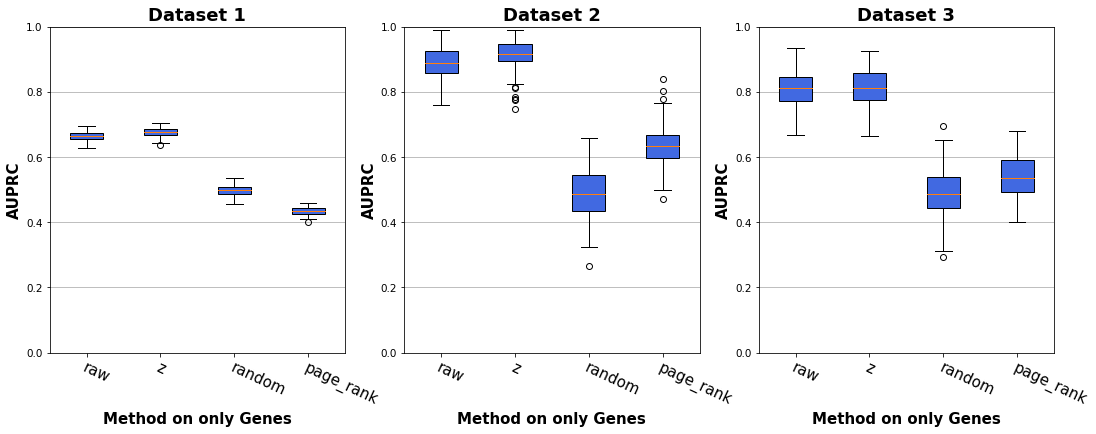

In [12]:
show_box_plot(metrics_by_method_entity["gene_nodes"]["auroc"], 'Method on only Genes', 'AUROC',  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


#### Metabolites

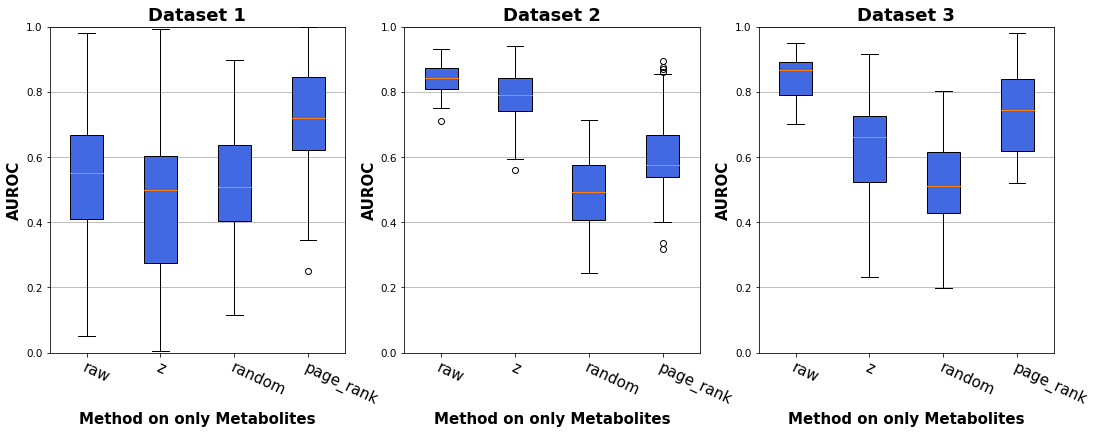

In [18]:
show_box_plot(metrics_by_method_entity["metabolite_nodes"]["auroc"], 'Method on only Metabolites', 'AUROC',  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


#### miRNAs

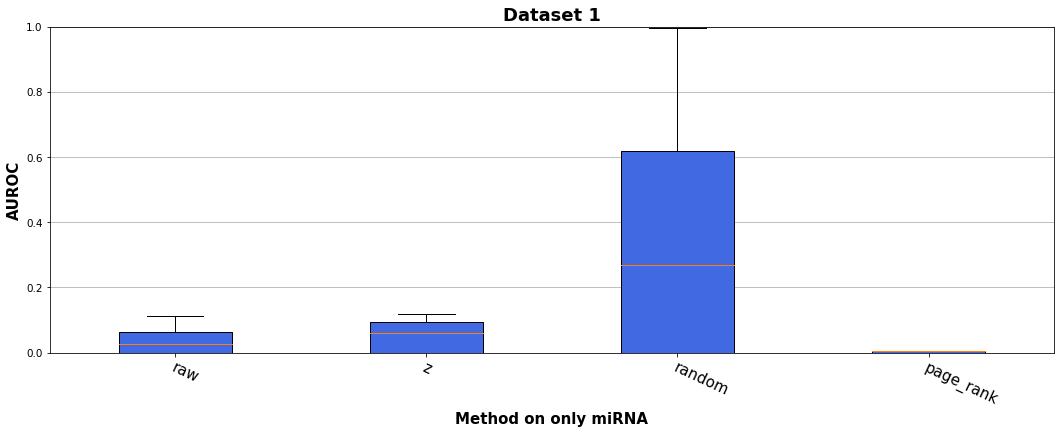

In [33]:
show_box_plot(metrics_by_method_entity["mirna_nodes"]["auroc"], 'Method on only miRNA', 'AUROC',  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


### 4.2. Metrics AUPRC

#### Genes

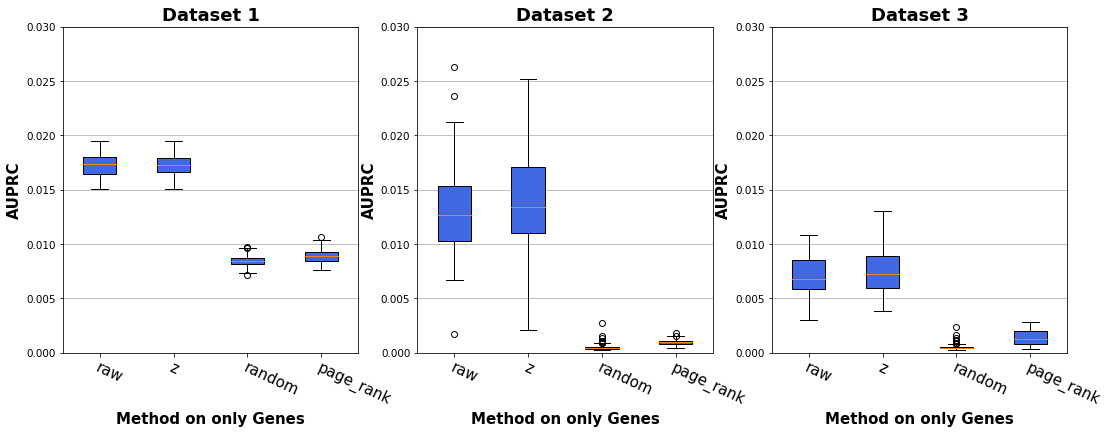

In [21]:
show_box_plot(metrics_by_method_entity["gene_nodes"]["auprc"], 'Method on only Genes', 'AUPRC', y_lim = [0, 0.03],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


#### Metabolites

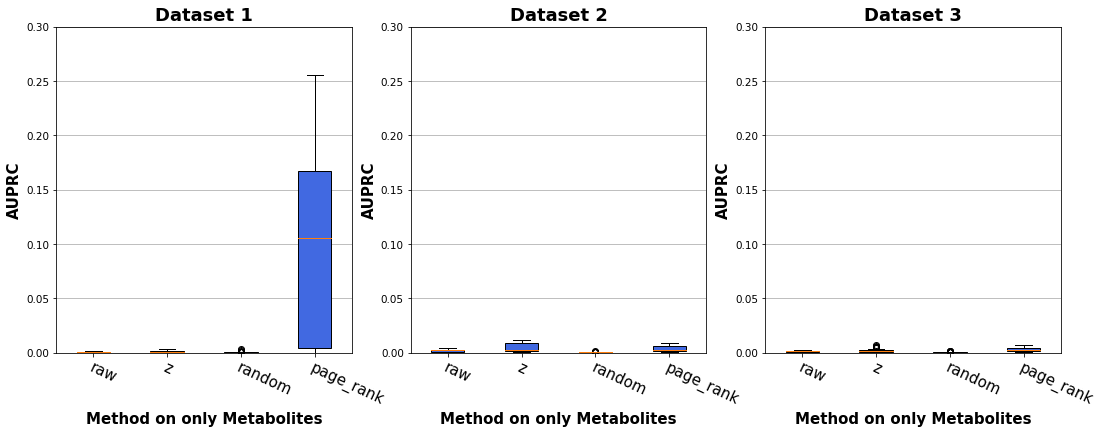

In [8]:
show_box_plot(metrics_by_method_entity["metabolite_nodes"]["auprc"], 'Method on only Metabolites', 'AUPRC', y_lim = [0, 0.30],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


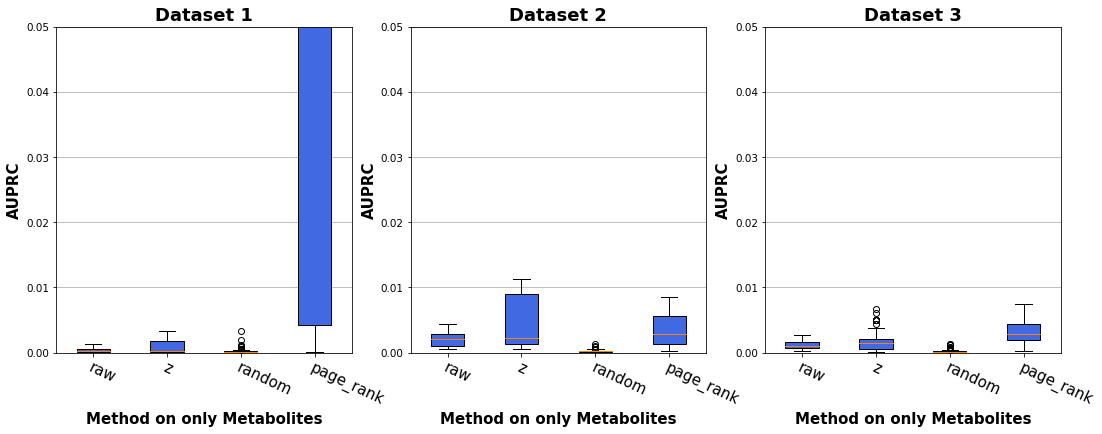

In [9]:
show_box_plot(metrics_by_method_entity["metabolite_nodes"]["auprc"], 'Method on only Metabolites', 'AUPRC', y_lim = [0, 0.05],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


#### miRNAs

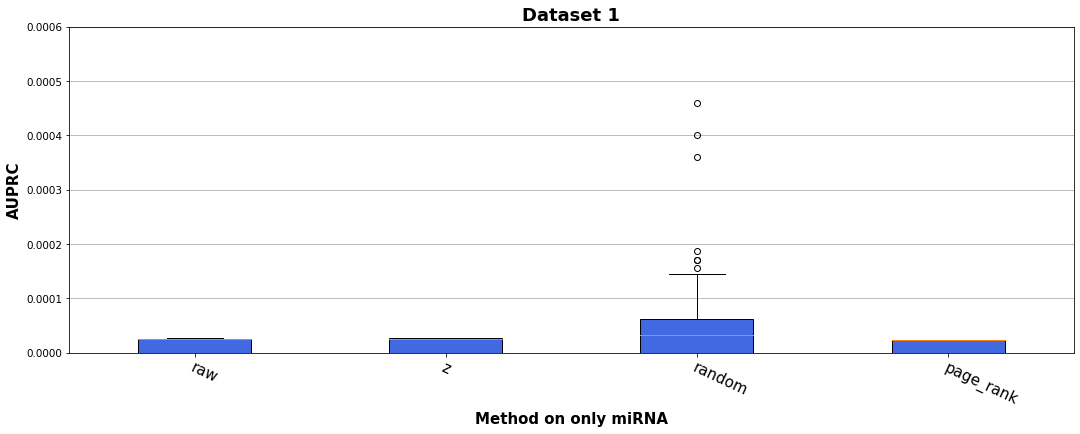

In [27]:
show_box_plot(metrics_by_method_entity["mirna_nodes"]["auprc"], 'Method on only miRNA', 'AUPRC', y_lim = [0, 0.0006],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])